In [1]:
import os
import numpy as np
from collections import defaultdict
import gzip
import pandas as pd

import sys

sys.path.append("../2_train_models")
from data_loading import extract_peaks, extract_observed_profiles
from file_configs import MergedFilesConfig

sys.path.append("../5_modisco")
from modiscolite_utils import load_scores

from plot_utils import get_continuous_cmap
from other_motif_utils import trim_motif_by_thresh, trim_two_motifs_by_thresh, plot_motif_on_ax, compute_per_position_ic
from report_utils import load_modisco_results

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# need to specify for every expt

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

In [3]:
cell_type = "K562"
model_type = "strand_merged_umap"
data_type = "procap"

in_window = 2114
out_window = 1000

In [4]:
config = MergedFilesConfig(cell_type, model_type, data_type)

proj_dir = config.proj_dir

figures_dir = proj_dir + "figures/"

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

slice_len = config.slice

peak_path = config.all_peak_path

modisco_results_path = config.modisco_profile_results_path

scores_path = config.profile_onehot_scores_path

In [5]:
from load_annotations_utils import load_coords_with_summits

coords = load_coords_with_summits(peak_path, in_window=in_window)

In [6]:
scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

modisco_results = load_modisco_results(modisco_results_path)

counts_modisco_results = load_modisco_results(modisco_results_path.replace("profile", "counts"))

true_profs = extract_observed_profiles(config.plus_bw_path,
                                       config.minus_bw_path,
                                       peak_path,
                                       out_window=out_window)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [7]:
pred_logcounts = np.load(config.pred_logcounts_all_path)

In [8]:
len(coords), scores.shape, true_profs.shape, pred_profs.shape, pred_logcounts.shape

(30534, (30534, 1000, 4), (30534, 2, 1000), (30534, 2, 1000), (30534, 1))

In [9]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type, in_window)

## Main Large Plot

In [10]:
def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False,
                     color = None, tick_len=3, tick_fontsize=6):
    assert len(profiles.shape) == 3

    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]
    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    
    profs_norm = normalize(profiles, axis=-1)

    # Compute the mean profiles across all examples
    profs_mean = np.mean(profs_norm, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color=color, linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color=color, alpha = 0.6, linewidth=0.5)

    # Set axes
    max_mean_val = np.max(profs_mean)
    
    if tick_len < 3:
        mean_ylim = max_mean_val * 1.02  # Make 5% higher
    else:
        mean_ylim = max_mean_val * 1.
        
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        for side in ["left", "top", "right", "bottom"]:
            ax.spines[side].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=tick_fontsize)
        ax.tick_params("x", length=tick_len)
        
        for side in ["left", "top", "right"]:
            ax.spines[side].set_visible(False)
            
        if tick_len < 3:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 6, mean_ylim / 7,
                                     clip_on=False, zorder=50, color="white")
        else:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                     clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        

def extract_profs_at_motifs(motif_hits, coords, true_profs, pred_profs,
                             in_window, out_window, slice_len, prof_width=200):
        
    def convert_motif_coords_to_prof_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - out_window) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_prof_coords(coords, coord_indexes,
                                                                   motif_starts, motif_ends)
    
    # Get indices of profile above motif
    motif_centers = (motif_starts + motif_ends) // 2
    motif_prof_starts = motif_centers - prof_width
    motif_prof_ends = motif_centers + prof_width
    
    # For each seqlet, fetch the true/predicted profiles
    true_motif_profs = []
    pred_motif_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, motif_prof_starts, motif_prof_ends, motif_rcs):
        if not (prof_start < 0 or prof_end > out_window):
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
            if rc:
                true_prof = true_prof[::-1, ::-1]
                pred_prof = pred_prof[::-1, ::-1]
        
            true_motif_profs.append(true_prof)
            pred_motif_profs.append(pred_prof)

    true_motif_profs = np.stack(true_motif_profs)
    pred_motif_profs = np.stack(pred_motif_profs)
    
    return true_motif_profs, pred_motif_profs

def plot_cwm_weight_as_circle(ax, cwm_weight):
    cmap = get_continuous_cmap(["#D0F2F8", "#94D3E7", "#275A95", "#212158"])
    cmap_color = cmap(cwm_weight)
    ax.add_patch(plt.Circle((0.5, 0.5), cwm_weight * 0.48,
                            facecolor = cmap_color, edgecolor="#0C0D40"))
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(xlim=[0, 1], ylim=[0, 1], aspect=1)

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19] [7526 5028 3366 2003 1079 610 280 175 92 57 24 13 6 7 4 4 0 0]
[1, 4, 7.5] ['1', '4', '7+']
[1, 2, 3, 4, 5, 6, 7]


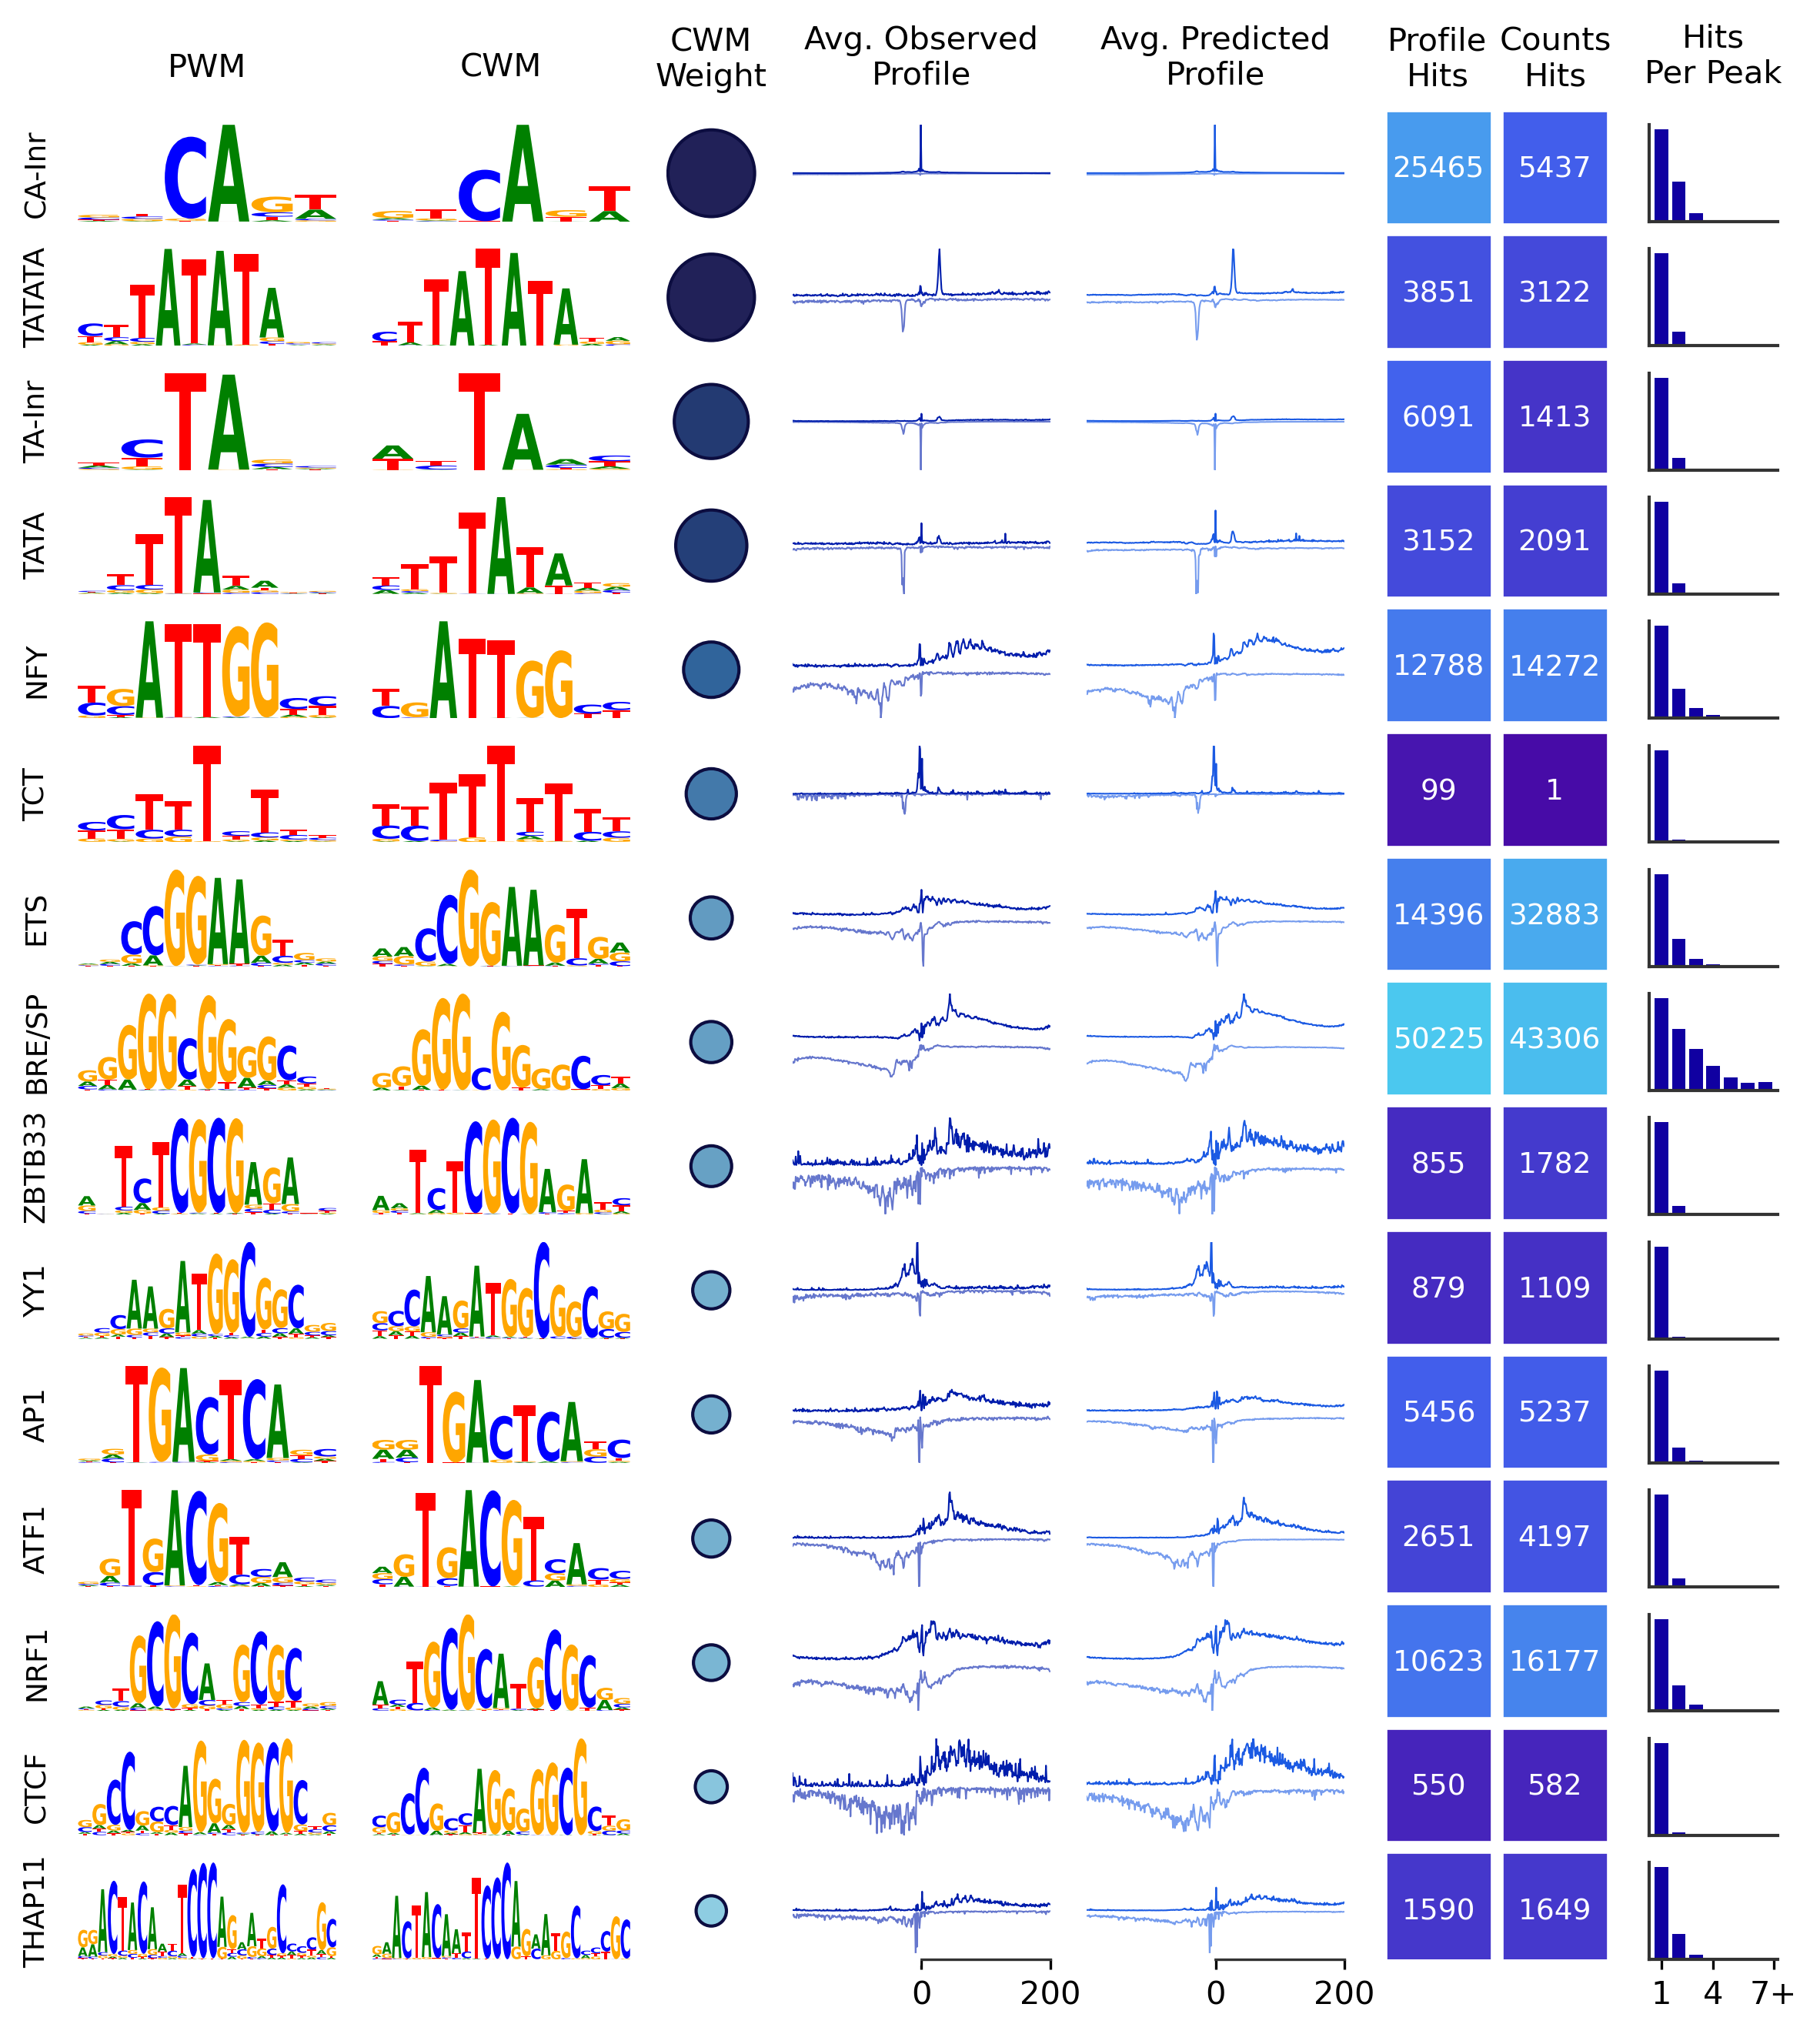

In [21]:
def pick_middle_peak_index(peak_indexes):
    peak_indexes = sorted(list(set(peak_indexes)))
    return peak_indexes[len(peak_indexes) // 2]


def plot_modisco_hits(modisco_results, patterns_to_keep,
                      motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      motif_names_list = motif_names,
                      prof_width=200, save_path=None):
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    ### first, load up all the data used in the plot
    
    pwms_list = []
    cwms_list = []
    cwm_weights = []
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    
    motif_hit_counts = defaultdict(lambda : [])
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        ppm = pattern["sequence"][:]
        pwm = ppm * compute_per_position_ic(ppm)[:, None]
        pwms_list.append(pwm)
        
        cwm = pattern["contrib_scores"][:]
        cwms_list.append(cwm)
        
        cwm_weight = np.max(cwm.sum(axis=-1))
        cwm_weights.append(cwm_weight)

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits["profile"][motif_hits["profile"]["motif_index"] == ax_row_i]
       
        # remove duplicate motif hits, double-called because peaks were too close together
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_peak_index}).reset_index()
        
        #print(pattern_name, ax_row_i, set(motif_hits_subset["motif"]))
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        hist_y, hist_x = np.histogram(hit_counts_by_peak,
                                      bins=range(1, 20))  # 20 == arbitrarily large number
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)
        
        motif_hit_counts["profile"].append(hit_counts_by_peak.sum())
        
        # repeat for counts
        motif_hits_subset = motif_hits["counts"][motif_hits["counts"]["motif_index"] == ax_row_i]
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_peak_index}).reset_index()
        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        motif_hit_counts["counts"].append(hit_counts_by_peak.sum())

        
    ### sort everything identically
        
    heatmap_prof_data = np.array(motif_hit_counts["profile"])
    heatmap_counts_data = np.array(motif_hit_counts["counts"])
    
    # previous sort order
    #sort_order = np.argsort(heatmap_prof_data)[::-1]
    sort_order = np.argsort(cwm_weights)[::-1]
    
    heatmap_prof_data = heatmap_prof_data[sort_order]
    heatmap_counts_data = heatmap_counts_data[sort_order]
    heatmap_data = np.array((heatmap_prof_data, heatmap_counts_data)).T
    pwms = np.array(pwms_list)[sort_order]
    cwms = np.array(cwms_list)[sort_order]
    cwm_weights = np.array(cwm_weights)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    motif_names_list = np.array(motif_names_list)[sort_order]
    
    # normalize so max is 1
    cwm_weights = cwm_weights / np.max(cwm_weights)
    
    
    ### with data all loaded, start building plot

    fig, axes = plt.subplots(len(patterns_to_keep) + 1, 7,
                             figsize=(9.5,0.7 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,2,0.7,2,2,1.8,1],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.17})

    # the top row of subplots are fake (for padding), so remove/hide
    for ax in axes[0, :]:
        ax.remove()

    # modify the subplot arrangement to draw heatmap over a whole column
    axes[0,5].set_axis_off()
    gs1 = axes[0,5].get_gridspec()
    for ax in axes[1:, 5]:
        ax.remove()
    heatmap = fig.add_subplot(gs1[:, 5])

    for ax_row_i in range(len(patterns_to_keep)):
        pwm = pwms[ax_row_i]
        cwm = cwms[ax_row_i]
        cwm_weight = cwm_weights[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ax_row = axes[ax_row_i+1]
        
        ### plot motif PWM, CWM, CWM height
        
        pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
        plot_motif_on_ax(pwm_trim, ax_row[0])
        plot_motif_on_ax(cwm_trim, ax_row[1])
        
        plot_cwm_weight_as_circle(ax_row[2], cwm_weight)
        
        ax_row[0].set_ylabel(motif_names_list[ax_row_i], fontsize=9, labelpad=5)
        
        if ax_row_i == 0:
            ax_row[0].set_title("PWM", y=1.3, fontsize=10)
            ax_row[1].set_title("CWM", y=1.3, fontsize=10)
            ax_row[2].set_title("CWM\nWeight", y=1.25, fontsize=10)
            
            
        ### plot true/pred profiles

        plot_avg_profile(true_profs, ax_row[3],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#001DAC")
        if ax_row_i == 0:
            ax_row[3].set_title("Avg. Observed\nProfile\n", fontsize=10, pad=1.5)

        plot_avg_profile(pred_profs, ax_row[4],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#1B5AE3")
        if ax_row_i == 0:
            ax_row[4].set_title("Avg. Predicted\nProfile\n", fontsize=10, pad=1.5)

        ### plot motif complexity histograms
            
        stop_after = 6
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[6].bar(hist_x, hist_y, color="#1000A1", alpha=1)#"#2929ea", alpha=1)

        ax_row[6].tick_params("both", length=3)
        ax_row[6].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.2]
            xticks = xticks[::3]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels = xticklabels[::3]
            xticklabels.append(str(hist_x[-1]) + "+")
            print(xticks, xticklabels)
            print(hist_x)
            ax_row[6].set_xticks(xticks, xticklabels)
        else:
            ax_row[6].set_xticks([])

        for side in ["left", "bottom"]:
            ax_row[6].spines[side].set_linewidth(1)
            ax_row[6].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            ax_row[6].spines[side].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[6].set_title("Hits\nPer Peak\n", fontsize=10, pad=1.5)

    ### plot heatmaps (columns 2 and 3)

    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    heatmap.imshow(np.sqrt(np.concatenate((heatmap_data.T, heatmap_data.T)).T), aspect = "auto", cmap=cmap)

    heatmap.set_xticks(np.arange(3)-.5, minor=True)
    heatmap.xaxis.set_ticks_position("top")
    heatmap.set_xticks([-0.01,1.01], ["Profile\nHits", "Counts\nHits"], fontsize=10)
    heatmap.tick_params(length=0, pad=0)

    # format heatmaps to look better
    heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
    heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
    heatmap.tick_params(which="major", bottom=False, left=False, top=False)
    heatmap.set_yticklabels([])
    for side in ["left", "top", "bottom"]:
        heatmap.spines[side].set_visible(False)
    heatmap.spines["right"].set_color("w")
    heatmap.set_yticks(np.arange(len(heatmap_data)+1)-.5, minor=True)
    heatmap.set_ylim(len(heatmap_data) - 0.6, -0.6)

    heatmap.set_xlim(-0.5, 1.5)

    # add text on top of heatmaps
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if not np.isnan(heatmap_data[i,j]):
                text = heatmap.text(j, i+0.02, int(heatmap_data[i,j]),
                           ha="center", va="center", color="w", fontsize=9)
            else:
                text = heatmap.text(j-0.03, i+0.02, 0,
                           ha="center", va="center", color="#333333", fontsize=9)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits(modisco_results,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len,
                  save_path = figures_dir + "2main.png")

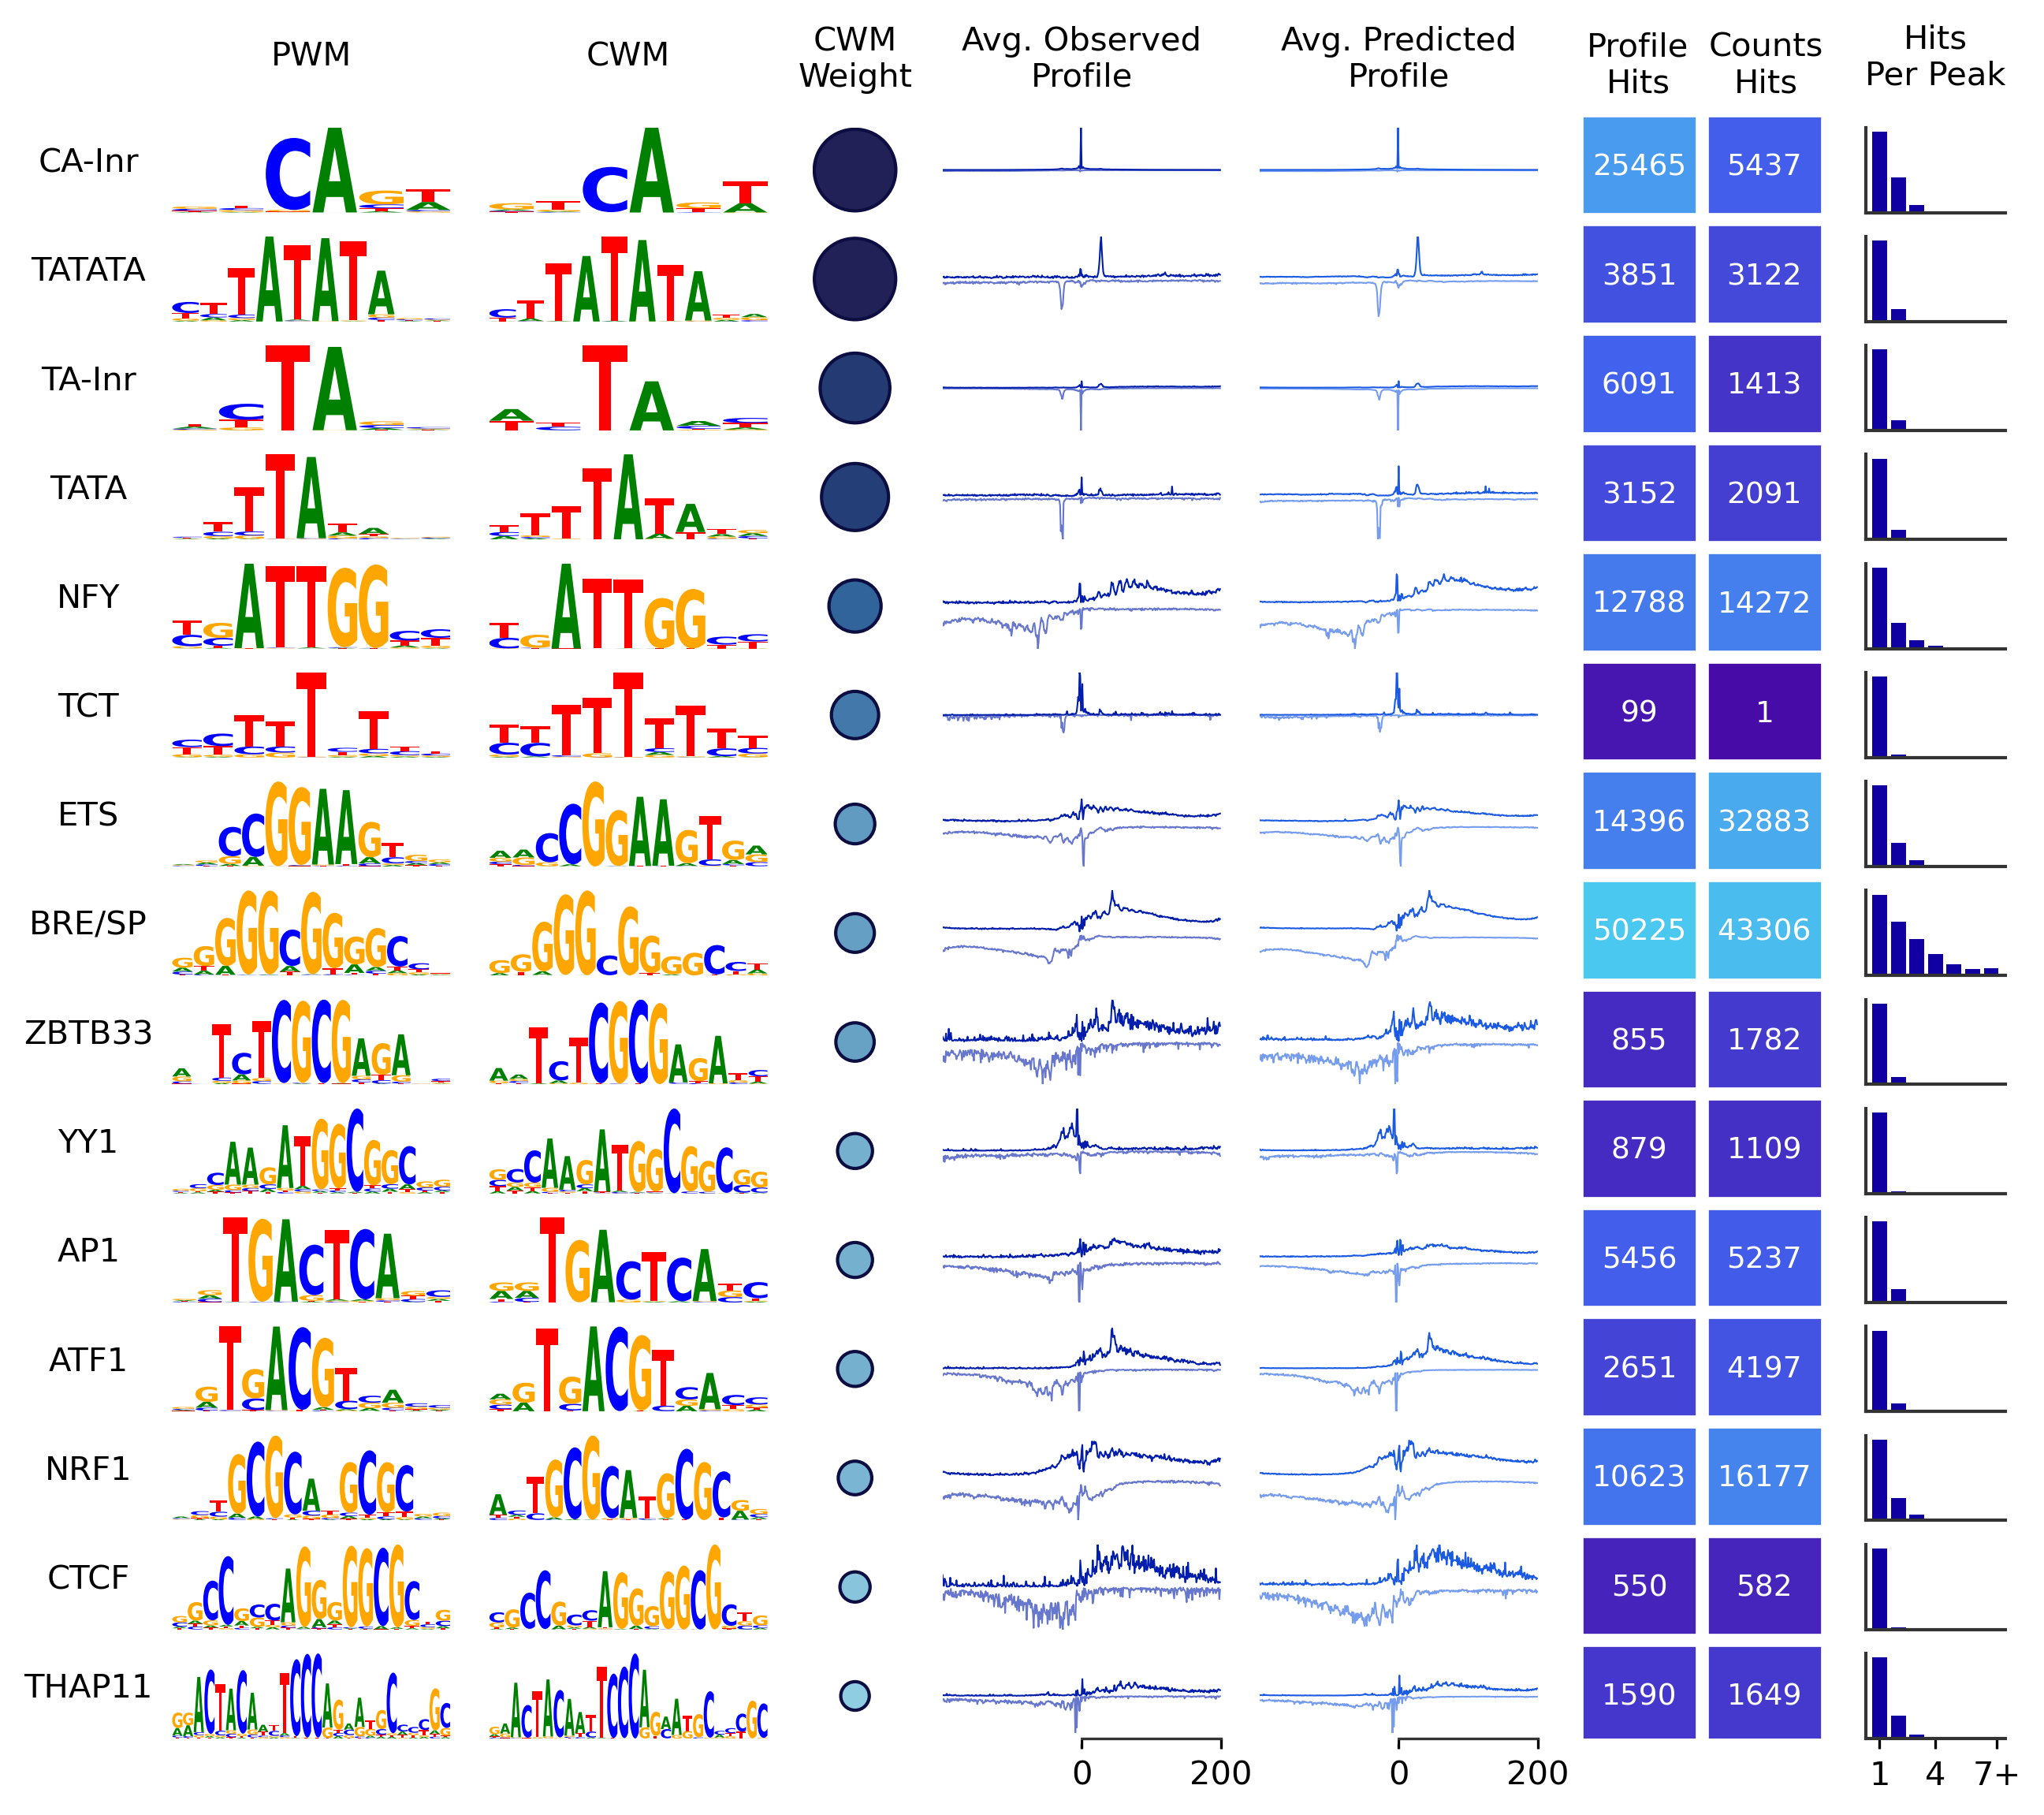

In [26]:
def plot_modisco_hits(modisco_results, patterns_to_keep,
                      motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      motif_names_list = motif_names,
                      prof_width=200, save_path=None):
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    ### first, load up all the data used in the plot
    
    pwms_list = []
    cwms_list = []
    cwm_weights = []
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    motif_hit_counts = defaultdict(lambda : [])
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        ppm = pattern["sequence"][:]
        pwm = ppm * compute_per_position_ic(ppm)[:, None]
        pwms_list.append(pwm)
        
        cwm = pattern["contrib_scores"][:]
        cwms_list.append(cwm)
        
        cwm_weight = np.max(cwm.sum(axis=-1))
        cwm_weights.append(cwm_weight)
        
        
        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits["profile"][motif_hits["profile"]["motif_index"] == ax_row_i]
       
        # remove duplicate motif hits, double-called because peaks were too close together
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_peak_index}).reset_index()
        
        #print(pattern_name, ax_row_i, set(motif_hits_subset["motif"]))
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        hist_y, hist_x = np.histogram(hit_counts_by_peak,
                                      bins=range(1, 20))  # 20 == arbitrarily large number
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)
        
        motif_hit_counts["profile"].append(hit_counts_by_peak.sum())
        
        # repeat for counts
        motif_hits_subset = motif_hits["counts"][motif_hits["counts"]["motif_index"] == ax_row_i]
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_peak_index}).reset_index()
        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        motif_hit_counts["counts"].append(hit_counts_by_peak.sum())

    heatmap_prof_data = np.array(motif_hit_counts["profile"])
    heatmap_counts_data = np.array(motif_hit_counts["counts"])
    
        
    ### sort everything identically
    
    # previous sort order
    #sort_order = np.argsort(heatmap_prof_data)[::-1]
    sort_order = np.argsort(cwm_weights)[::-1]
    
    heatmap_prof_data = heatmap_prof_data[sort_order]
    heatmap_counts_data = heatmap_counts_data[sort_order]
    heatmap_data = np.array((heatmap_prof_data, heatmap_counts_data)).T
    pwms = np.array(pwms_list)[sort_order]
    cwms = np.array(cwms_list)[sort_order]
    cwm_weights = np.array(cwm_weights)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    motif_names_list = np.array(motif_names_list)[sort_order]
    
    # normalize so max is 1
    cwm_weights = cwm_weights / np.max(cwm_weights)
    
    
    ### with data all loaded, start building plot

    fig, axes = plt.subplots(len(patterns_to_keep) + 1, 7,
                             figsize=(10, 0.6 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,2,0.7,2,2,1.8,1],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.17})

    # the top row of subplots are fake (for padding), so remove/hide
    for ax in axes[0, :]:
        ax.remove()

    # modify the subplot arrangement to draw heatmap over a whole column
    axes[0,5].set_axis_off()
    gs1 = axes[0,5].get_gridspec()
    for ax in axes[1:, 5]:
        ax.remove()
    heatmap = fig.add_subplot(gs1[:, 5])

    for ax_row_i in range(len(patterns_to_keep)):
        pwm = pwms[ax_row_i]
        cwm = cwms[ax_row_i]
        cwm_weight = cwm_weights[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ax_row = axes[ax_row_i+1]
        
        ### plot motif PWM, CWM, CWM height
        
        pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
        plot_motif_on_ax(pwm_trim, ax_row[0])
        plot_motif_on_ax(cwm_trim, ax_row[1])
        
        plot_cwm_weight_as_circle(ax_row[2], cwm_weight)
        
        ax_row[0].set_ylabel(motif_names_list[ax_row_i],
                             fontsize=10, labelpad=22, rotation=0, y=0.4)
        #ax_row[0].yaxis.set_label_coords(-0.1,1.02)
        
        if ax_row_i == 0:
            ax_row[0].set_title("PWM", y=1.5, fontsize=10)
            ax_row[1].set_title("CWM", y=1.5, fontsize=10)
            ax_row[2].set_title("CWM\nWeight", y=1.25, fontsize=10)
            
            
        ### plot true/pred profiles

        plot_avg_profile(true_profs, ax_row[3],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#001DAC")
        if ax_row_i == 0:
            ax_row[3].set_title("Avg. Observed\nProfile\n", fontsize=10, pad=1.5)

        plot_avg_profile(pred_profs, ax_row[4],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#1B5AE3")
        if ax_row_i == 0:
            ax_row[4].set_title("Avg. Predicted\nProfile\n", fontsize=10, pad=1.5)

        ### plot motif complexity histograms
            
        stop_after = 6
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[6].bar(hist_x, hist_y, color="#1000A1", alpha=1)#"#2929ea", alpha=1)

        ax_row[6].tick_params("both", length=3)
        ax_row[6].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.3]
            xticks = xticks[::3]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels = xticklabels[::3]
            xticklabels.append(str(hist_x[-1]) + "+")
            ax_row[6].set_xticks(xticks, xticklabels)
        else:
            ax_row[6].set_xticks([])

        for side in ["left", "bottom"]:
            ax_row[6].spines[side].set_linewidth(1)
            ax_row[6].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            ax_row[6].spines[side].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[6].set_title("Hits\nPer Peak\n", fontsize=10, pad=1.5)

    ### plot heatmaps (columns 2 and 3)

    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    heatmap.imshow(np.sqrt(np.concatenate((heatmap_data.T, heatmap_data.T)).T), aspect = "auto", cmap=cmap)

    heatmap.set_xticks(np.arange(3)-.5, minor=True)
    heatmap.xaxis.set_ticks_position("top")
    heatmap.set_xticks([-0.01,1.01], ["Profile\nHits", "Counts\nHits"], fontsize=10)
    heatmap.tick_params(length=0, pad=0)

    # format heatmaps to look better
    heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
    heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
    heatmap.tick_params(which="major", bottom=False, left=False, top=False)
    heatmap.set_yticklabels([])
    for side in ["left", "top", "bottom"]:
        heatmap.spines[side].set_visible(False)
    heatmap.spines["right"].set_color("w")
    heatmap.set_yticks(np.arange(len(heatmap_data)+1)-.5, minor=True)
    heatmap.set_ylim(len(heatmap_data) - 0.6, -0.6)

    heatmap.set_xlim(-0.5, 1.5)

    # add text on top of heatmaps
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if not np.isnan(heatmap_data[i,j]):
                text = heatmap.text(j, i+0.02, int(heatmap_data[i,j]),
                           ha="center", va="center", color="w", fontsize=9)
            else:
                text = heatmap.text(j-0.03, i+0.02, 0,
                           ha="center", va="center", color="#333333", fontsize=9)

    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits(modisco_results,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len,
                  save_path = figures_dir + "2main_squish.png")

## Other Plots

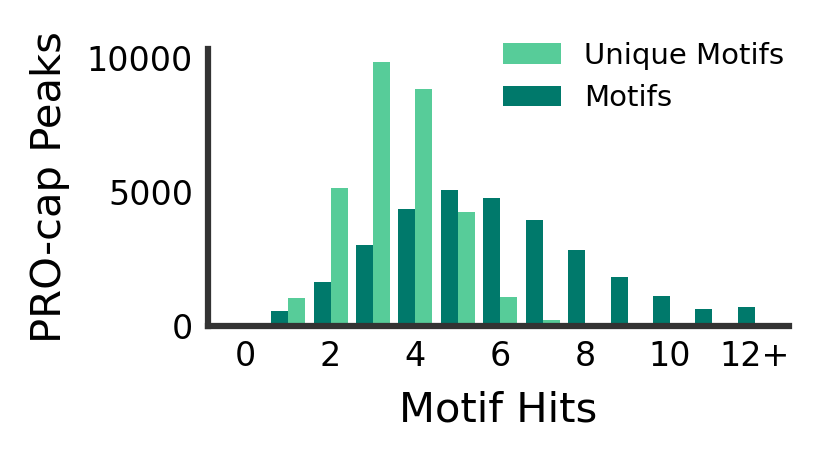

In [11]:
def plot_motif_complexity(motif_hit_counts, save_path = None):
    plt.figure(figsize=(2.5,1.2), dpi=300)
    bar_width = 0.4
    
    # non-unique motif hits
    motif_hits_per_peak = motif_hit_counts.sum(axis=1)
    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))
    stop_point = 12
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]
    
    plt.bar(hist_x, hist_y, color="#00796b", alpha=1, width=bar_width, label="Motifs")
    
    # unique motif hits
    uniq_hits_per_peak = (motif_hit_counts > 0).sum(axis=-1).astype(np.int32)
    hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
    stop_point2 = 9
    hist_y2 = list(hist_y2[:stop_point2]) + [np.sum(hist_y2[stop_point2:])]
    hist_x2 = np.array(list(hist_x2[:stop_point2]) + [stop_point2])
    
    plt.bar(hist_x2 + bar_width, hist_y2, color="#57cc99", alpha=1, width=bar_width, label="Unique Motifs")
    
    plt.xlabel("Motif Hits", fontsize=10)
    plt.ylabel("PRO-cap Peaks", fontsize=10)
    
    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")
            
    plt.xticks(np.array(hist_x[::2]) + bar_width / 2, xticklabels[::2])
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0, labelsize=8)
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    #plt.legend(frameon=False, bbox_to_anchor=(0.5,1.65), loc="upper center", fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], frameon=False, fontsize=7,
              bbox_to_anchor=(0.75,1.12), loc="upper center")
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
    
plot_motif_complexity(motif_hit_counts["profile"],
                      save_path = figures_dir + "2_motif_complexity.png")

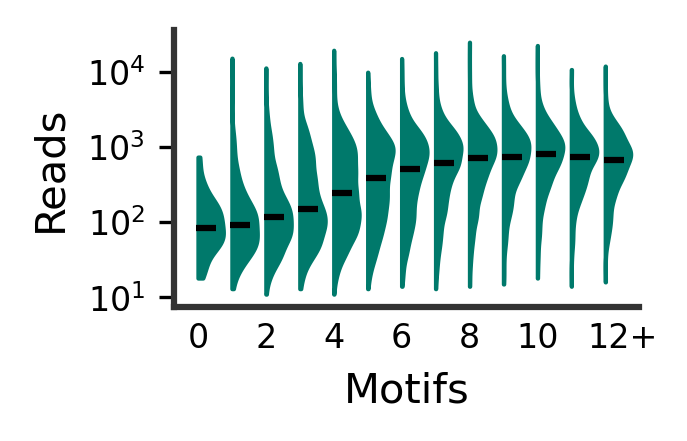

In [12]:
from plot_utils import jitter_dots

def plot_counts_by_num_motifs(motif_hit_counts, true_profs, max_num_motifs=12, save_path = None):
    true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
    
    motif_hit_counts = motif_hit_counts.sum(axis=-1)
    motif_hit_counts_clipped = np.clip(motif_hit_counts, 0, max_num_motifs)
    
    counts_per_num_motifs = []
    median_counts_per_num_motifs = []
    for num_motifs in range(max_num_motifs + 1):
        counts_per_i_motifs = true_logcounts[motif_hit_counts_clipped == num_motifs]
        counts_per_num_motifs.append(counts_per_i_motifs)
        median_counts_per_num_motifs.append(np.median(counts_per_i_motifs))
    
    plt.figure(figsize=(2.,1.2), dpi=300)

    v1 = plt.violinplot(counts_per_num_motifs, points=200,
                       positions=np.arange(0, len(counts_per_num_motifs)),
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=1.5)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor("#00796b")
        b.set_facecolor("#00796b")
        b.set_alpha(1)

    plt.scatter(np.arange(max_num_motifs + 1) + 0.25, median_counts_per_num_motifs,
                marker="_", c="k", s=24, zorder=1)

    plt.xlabel("Motifs", fontsize=10)
    plt.ylabel("Reads", fontsize=10)
    
    xticks = list(range(0, max_num_motifs + 1, 2))
    xticklabels = [str(i) for i in xticks]
    xticklabels[-1] = xticklabels[-1] + "+"
    xticks[-1] = xticks[-1] + 0.5
    plt.xticks(xticks, xticklabels)
    plt.tick_params("x", length=0)
    plt.tick_params("both", labelsize=8)
    plt.xlim(-0.7, max_num_motifs + 1)
    
    yticks = [int(tick) for tick in plt.gca().get_yticks()][1:-1]
    plt.yticks(yticks, [r'$10^' + str(tick) + "$" for tick in yticks])
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()

plot_counts_by_num_motifs(motif_hit_counts["profile"], true_profs,
                          save_path = figures_dir + "2_motifs_vs_counts.png")

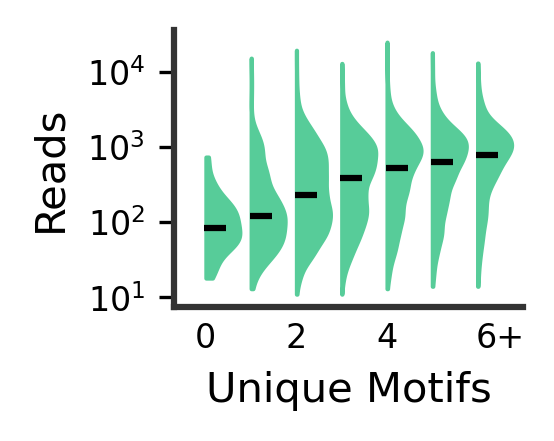

In [13]:
from plot_utils import jitter_dots

def plot_counts_by_num_uniq_motifs(motif_hit_counts, true_profs, max_num_motifs=6, save_path = None):
    true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
    
    motif_hit_counts = (motif_hit_counts > 0).sum(axis=-1)
    motif_hit_counts_clipped = np.clip(motif_hit_counts, 0, max_num_motifs)
    
    counts_per_num_motifs = []
    median_counts_per_num_motifs = []
    for num_motifs in range(max_num_motifs + 1):
        counts_per_i_motifs = true_logcounts[motif_hit_counts_clipped == num_motifs]
        counts_per_num_motifs.append(counts_per_i_motifs)
        median_counts_per_num_motifs.append(np.median(counts_per_i_motifs))
    
    plt.figure(figsize=(1.5,1.2), dpi=300)

    v1 = plt.violinplot(counts_per_num_motifs, points=200,
                       positions=np.arange(0, len(counts_per_num_motifs)),
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=1.5)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor("#57cc99")
        b.set_facecolor("#57cc99")
        b.set_alpha(1)

    plt.scatter(np.arange(max_num_motifs + 1) + 0.21, median_counts_per_num_motifs,
                marker="_", c="k", s=28, zorder=1)

    plt.xlabel("Unique Motifs", fontsize=10)
    plt.ylabel("Reads", fontsize=10)
    
    xticks = list(range(0, max_num_motifs + 1, 2))
    xticklabels = [str(i) for i in xticks]
    xticklabels[-1] = xticklabels[-1] + "+"
    xticks[-1] = xticks[-1] + 0.5
    plt.xticks(xticks, xticklabels)
    plt.tick_params("x", length=0)
    plt.tick_params("both", labelsize=8)
    plt.xlim(-0.7, max_num_motifs + 1)
    
    yticks = [int(tick) for tick in plt.gca().get_yticks()][1:-1]
    plt.yticks(yticks, [r'$10^' + str(tick) + "$" for tick in yticks])
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)

    plt.show()


plot_counts_by_num_uniq_motifs(motif_hit_counts["profile"], true_profs,
                          save_path = figures_dir + "2_motifs_vs_counts_uniq.png")

In [15]:
# quantifying sentences in the text of the paper

# what fraction of peaks have 10 or fewer motifs?
tmp = motif_hit_counts["profile"].sum(axis=-1)
np.sum(tmp < 11) / len(tmp)

0.9559507434335495

In [16]:
# what fraction of peaks have 6 or fewer unique motifs?
tmp = (motif_hit_counts["profile"] > 0).sum(axis=-1)
np.sum(tmp < 7) / len(tmp)

0.9927949171415471

## Linear Models Using Motif Hits

In [10]:
import statsmodels.api as sm

In [11]:
true_logcounts = np.log1p(true_profs.sum(axis=(-1,-2)))

In [12]:
# read counts ~ predicted read counts (to get baseline R^2)

model = sm.OLS(true_logcounts,
               sm.add_constant(pred_logcounts))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 4.036e+04
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:43:28   Log-Likelihood:                -37412.
No. Observations:               30534   AIC:                         7.483e+04
Df Residuals:                   30532   BIC:                         7.485e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2777      0.023     54.718      0.000       1.232       1.323
x1             0.7864      0.004    200.891      0.000       0.779       0.794
==============================================================================
Omnibus:                      673.540   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.489
Skew:                          -0.216   Prob(JB):                    8.72e-236
Kurtosis:                       3.815   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# read counts ~ # of motifs counted per peak

model = sm.OLS(true_logcounts,
               sm.add_constant(motif_hit_counts["profile"].sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4568.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:50:37   Log-Likelihood:                -48144.
No. Observations:               30534   AIC:                         9.629e+04
Df Residuals:                   30532   BIC:                         9.631e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8237      0.017    285.485      0.000       4.791       4.857
x1             0.1796      0.003     67.587      0.000       0.174       0.185
==============================================================================
Omnibus:                      450.610   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.783
Skew:                          -0.156   Prob(JB):                     2.45e-72
Kurtosis:                       2.598   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# read counts ~ # of *unique* motifs counted per peak

model = sm.OLS(true_logcounts,
               sm.add_constant((motif_hit_counts["profile"] > 0).sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1965.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:51:06   Log-Likelihood:                -49320.
No. Observations:               30534   AIC:                         9.864e+04
Df Residuals:                   30532   BIC:                         9.866e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9742      0.021    232.249      0.000       4.932       5.016
x1             0.2598      0.006     44.330      0.000       0.248       0.271
==============================================================================
Omnibus:                     1014.967   Durbin-Watson:                   1.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.267
Skew:                          -0.254   Prob(JB):                    3.51e-150
Kurtosis:                       2.467   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model = sm.OLS(true_logcounts,
               sm.add_constant(np.array([(motif_hit_counts["profile"] > 0).sum(axis=-1),
                                         motif_hit_counts["profile"].sum(axis=-1)]).T))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     2338.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:51:10   Log-Likelihood:                -48097.
No. Observations:               30534   AIC:                         9.620e+04
Df Residuals:                   30531   BIC:                         9.622e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6976      0.021    220.603      0.000       4.656       4.739
x1             0.0662      0.007      9.709      0.000       0.053       0.080
x2             0.1620      0.003     50.469      0.000       0.156       0.168
==============================================================================
Omnibus:                      429.421   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.222
Skew:                          -0.163   Prob(JB):                     2.39e-71
Kurtosis:                       2.614   Cond. No.                         23.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# motif identity matters

model = sm.OLS(true_logcounts,
               sm.add_constant(motif_hit_counts["profile"]))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     727.7
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:51:25   Log-Likelihood:                -45604.
No. Observations:               30534   AIC:                         9.124e+04
Df Residuals:                   30518   BIC:                         9.137e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0551      0.017    291.389      0.000       5.021       5.089
x1             0.1284      0.003     40.157      0.000       0.122       0.135
x2             0.0940      0.007     12.909      0.000       0.080       0.108
x3             0.2644      0.007     36.183      0.000       0.250       0.279
x4             0.1425      0.006     22.383      0.000       0.130       0.155
x5             0.3845      0.008     48.461      0.000       0.369       0.400
x6             0.3958      0.018     22.185      0.000       0.361       0.431
x7            -0.3482      0.017    -20.018      0.000      -0.382      -0.314
x8             0.2829      0.019     14.988      0.000       0.246       0.320
x9             0.5252      0.030     17.381      0.000       0.466       0.584
x10           -0.2314      0.013    -17.841      0.000      -0.257      -0.206
x11            0.1240      0.013      9.821      0.000       0.099       0.149
x12            0.0380      0.037      1.034      0.301      -0.034       0.110
x13            0.5122      0.028     18.422      0.000       0.458       0.567
x14            0.6147      0.096      6.380      0.000       0.426       0.804
x15           -0.2028      0.015    -13.177      0.000      -0.233      -0.173
==============================================================================
Omnibus:                       56.864   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.196
Skew:                          -0.103   Prob(JB):                     3.80e-13
Kurtosis:                       3.050   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# motif identity matters pt 2 - motif diversity is huge fraction of R^2

model = sm.OLS(true_logcounts,
               sm.add_constant(1 * (motif_hit_counts["profile"] > 0)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     633.0
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:56:18   Log-Likelihood:                -46137.
No. Observations:               30534   AIC:                         9.231e+04
Df Residuals:                   30518   BIC:                         9.244e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0091      0.022    231.467      0.000       4.967       5.051
x1             0.4925      0.016     30.347      0.000       0.461       0.524
x2             0.1336      0.014      9.547      0.000       0.106       0.161
x3             0.3150      0.013     24.541      0.000       0.290       0.340
x4             0.1673      0.013     12.688      0.000       0.141       0.193
x5             0.6300      0.014     45.618      0.000       0.603       0.657
x6             0.3929      0.021     18.495      0.000       0.351       0.435
x7            -0.5000      0.022    -23.145      0.000      -0.542      -0.458
x8             0.3425      0.028     12.220      0.000       0.288       0.397
x9             0.5768      0.032     17.802      0.000       0.513       0.640
x10           -0.3390      0.017    -19.991      0.000      -0.372      -0.306
x11            0.1197      0.016      7.719      0.000       0.089       0.150
x12           -0.0341      0.042     -0.812      0.417      -0.116       0.048
x13            0.5771      0.035     16.531      0.000       0.509       0.645
x14            0.6257      0.102      6.151      0.000       0.426       0.825
x15           -0.3033      0.020    -15.228      0.000      -0.342      -0.264
==============================================================================
Omnibus:                       60.429   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.743
Skew:                          -0.109   Prob(JB):                     6.45e-14
Kurtosis:                       3.010   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
print(np.corrcoef(np.log1p(true_profs.sum(axis=(-1,-2))),
                  motif_hit_counts["profile"].sum(axis=-1))[0, 1])

print(np.corrcoef(np.log1p(true_profs.sum(axis=(-1,-2))),
                  (motif_hit_counts["profile"] > 0).sum(axis=-1))[0, 1])

# old
# 0.24746003687035809
# 0.2439844679000564

# old-old
# 0.40659471662368574
# 0.3961906848304746

0.3607513148965286
0.24591042256909526


In [28]:
print(np.corrcoef(true_profs.sum(axis=(-1,-2)),
                  motif_hit_counts["profile"].sum(axis=-1))[0, 1])

print(np.corrcoef(true_profs.sum(axis=(-1,-2)),
                  (motif_hit_counts["profile"] > 0).sum(axis=-1))[0, 1])

# old
# 0.10879331951253167
# 0.16252300678015572

# old-old
# 0.2918226531436865
# 0.29476137133330976

0.21044530430401115
0.16955245456740323


In [29]:
from scipy.stats import spearmanr

print(spearmanr(true_profs.sum(axis=(-1,-2)),
                motif_hit_counts["profile"].sum(axis=-1)))

print(spearmanr(true_profs.sum(axis=(-1,-2)),
                (motif_hit_counts["profile"] > 0).sum(axis=-1)))

# old: 0.24 for both
# old-old: 0.44, 0.40

SignificanceResult(statistic=0.38200509065397137, pvalue=0.0)
SignificanceResult(statistic=0.2428175698589759, pvalue=0.0)


In [30]:
# fit is worse if you don't use logcounts

model = sm.OLS(true_profs.sum(axis=(-1,-2)),
               sm.add_constant(motif_hit_counts["profile"].sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1415.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          1.03e-302
Time:                        00:19:23   Log-Likelihood:            -2.5056e+05
No. Observations:               30534   AIC:                         5.011e+05
Df Residuals:                   30532   BIC:                         5.011e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        250.3896     12.789     19.578      0.000     225.322     275.457
x1            75.6490      2.011     37.614      0.000      71.707      79.591
==============================================================================
Omnibus:                    36828.270   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10518379.667
Skew:                           6.187   Prob(JB):                         0.00
Kurtosis:                      93.080   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model = sm.OLS(true_profs.sum(axis=(-1,-2)),
               sm.add_constant((motif_hit_counts["profile"] > 0).sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     903.7
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          1.09e-195
Time:                        00:20:18   Log-Likelihood:            -2.5081e+05
No. Observations:               30534   AIC:                         5.016e+05
Df Residuals:                   30532   BIC:                         5.016e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        244.9687     15.725     15.578      0.000     214.147     275.790
x1           129.3633      4.303     30.062      0.000     120.929     137.798
==============================================================================
Omnibus:                    36294.121   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9936209.294
Skew:                           6.032   Prob(JB):                         0.00
Kurtosis:                      90.547   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# how many motifs on average


# old:
"""
Avg. number of motifs per peak:
2.803259259259259
Median number of motifs per peak:
3.0
Avg. number of unique motifs per peak:
1.9537777777777778
Median number of unique motifs per peak:
2.0
"""

print("Avg. number of motifs per peak:")
print(np.mean(motif_hit_counts["profile"].sum(axis=-1)))
print("Median number of motifs per peak:")
print(np.median(motif_hit_counts["profile"].sum(axis=-1)))

print("Avg. number of unique motifs per peak:")
print(np.mean((motif_hit_counts["profile"] > 0).sum(axis=-1)))
print("Median number of unique motifs per peak:")
print(np.median((motif_hit_counts["profile"] > 0).sum(axis=-1)))

Avg. number of motifs per peak:
5.8375581319185175
Median number of motifs per peak:
6.0
Avg. number of unique motifs per peak:
3.4555904892906266
Median number of unique motifs per peak:
3.0


Num peaks with no motifs found:
101
Fraction of peaks with no motifs found:
0.003307788039562455
Num peaks with <2 motifs found:
648
Fraction of peaks with <2 motifs found:
0.021222244055806642


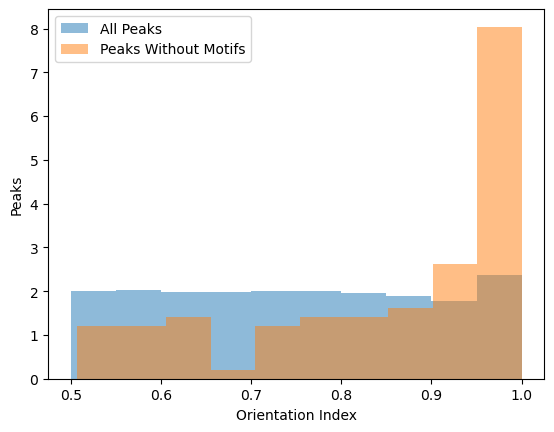

Fraction of no-motif peaks with OI = 1:
0.27722772277227725


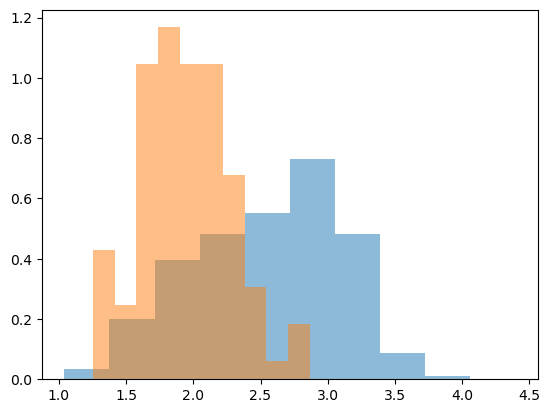

In [14]:
# Peaks with no motifs

print("Num peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0))
print("Fraction of peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0) / motif_hit_counts["profile"].shape[0])

print("Num peaks with <2 motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) < 2))
print("Fraction of peaks with <2 motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) < 2) / motif_hit_counts["profile"].shape[0])


def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)
peaks_no_motifs_ois = ois[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(ois, density=True, alpha=0.5, label="All Peaks")
plt.hist(peaks_no_motifs_ois, density=True, alpha=0.5, label="Peaks Without Motifs")
plt.legend()
plt.xlabel("Orientation Index")
plt.ylabel("Peaks")
plt.show()

print("Fraction of no-motif peaks with OI = 1:")
print(np.sum(peaks_no_motifs_ois == 1) / peaks_no_motifs_ois.shape[0])

true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
peaks_no_motifs_logcounts = true_logcounts[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(true_logcounts, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_logcounts, density=True, alpha=0.5)
plt.show()

Fraction of peaks with no motifs found:
0.12


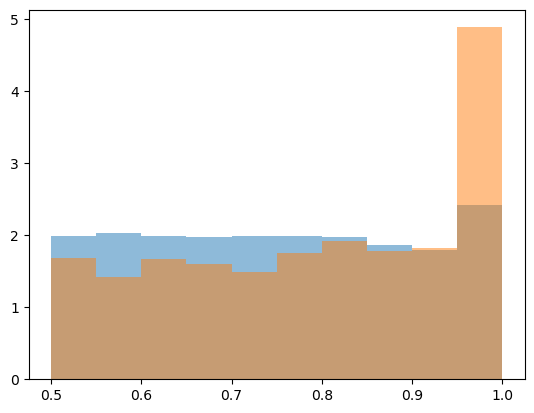

Fraction of no-motif peaks with OI = 1:
0.15308641975308643


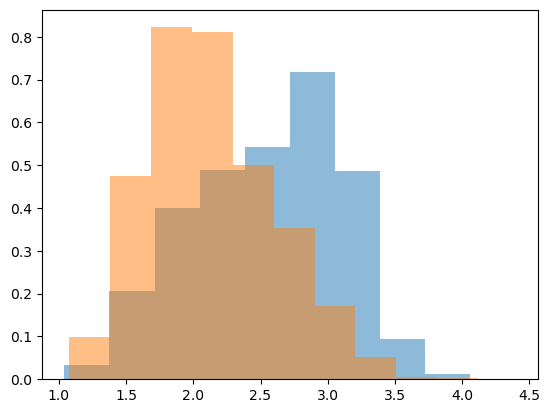

In [504]:
# OLD

print("Fraction of peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0) / motif_hit_counts["profile"].shape[0])


def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)
peaks_no_motifs_ois = ois[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(ois, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_ois, density=True, alpha=0.5)
plt.show()

print("Fraction of no-motif peaks with OI = 1:")
print(np.sum(peaks_no_motifs_ois == 1) / peaks_no_motifs_ois.shape[0])


true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
peaks_no_motifs_logcounts = true_logcounts[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(true_logcounts, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_logcounts, density=True, alpha=0.5)
plt.show()

In [35]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

ccre_bed = get_ccre_bed(cell_type, proj_dir)

ccre_annots = find_peak_overlap_labels(coords, ccre_bed, in_window, out_window)

In [36]:
# Peaks with no motifs

num_promoters_no_motifs = np.sum(motif_hit_counts["profile"][ccre_annots["PLS"]].sum(axis=-1) == 0)
num_promoters = np.sum(ccre_annots["PLS"])

print("Num promoters with no motifs, num promoters:")
print(num_promoters_no_motifs, num_promoters)
print("Fraction of promoters with no motifs found:")
print(num_promoters_no_motifs / num_promoters)

Num promoters with no motifs, num promoters:
7 16960
Fraction of promoters with no motifs found:
0.0004127358490566038


In [38]:
# Peaks with no motifs

num_enhancers_no_motifs = np.sum(motif_hit_counts["profile"][ccre_annots["dELS"]].sum(axis=-1) == 0)
num_enhancers = np.sum(ccre_annots["dELS"])

print("Num enhancers with no motifs, num enhancers:")
print(num_enhancers_no_motifs, num_enhancers)
print("Fraction of enhancers with no motifs found:")
print(num_enhancers_no_motifs / num_enhancers)

Num enhancers with no motifs, num enhancers:
25 5648
Fraction of enhancers with no motifs found:
0.004426345609065156


In [39]:
[(key, np.sum(val)) for key, val in ccre_annots.items()]

[('CTCF-bound', 9049),
 ('dELS', 5648),
 ('DNase-only', 676),
 ('PLS', 16960),
 ('pELS', 17435),
 ('DNase-H3K4me3', 2335),
 ('CTCF-only', 280),
 ('Low-DNase', 10603)]

In [40]:
from load_annotations_utils import load_annotations, does_a_overlap_anything_in_b

gene_regions_files = {"genes" : proj_dir + "/annotations/gene_regions.bed",
                      "TSSs" : proj_dir + "/annotations/TSSs.bed",
                      "promoters" : proj_dir + "/annotations/promoters.bed",
                      "intergenic" : proj_dir + "/annotations/intergenic_regions.bed",
                      "exons" : proj_dir + "/annotations/exons.bed",
                      "introns" : proj_dir + "/annotations/introns.bed",
                      "utrs" : proj_dir + "/annotations/utrs.bed"}

def clean_coord_summits(coord):
    assert len(coord) >= 5, coord
    chrom, start, end, summit_pos, summit_neg = coord[:5]
    if summit_pos is None:
        summit_pos = summit_neg
    if summit_neg is None:
        summit_neg = summit_pos
    return (chrom, start, end, summit_pos, summit_neg)


def get_gene_region_overlap(coords, gene_regions_files, in_window=2114, out_window=1000):
    overlaps = dict()
    
    for region_name, region_filepath in gene_regions_files.items():
        regions = load_annotations(region_filepath, label=False)

        # get set of chromosomes included in peak set
        chroms = sorted(list(set(coord[0] for coord in coords)))

        # make dict of chromosome --> sorted list of regions
        regions_by_chrom = {chrom : sorted([c for c in regions if c[0] == chrom]) for chrom in chroms}
        
        overlap_bools = []
        for coord in coords:
            chrom, start, end, summit_pos, summit_neg = clean_coord_summits(coord)
            # adjust the starts and ends of peak coordinates so they only cover summits +/- 50 bp
            # (will probably get a lot of FP overlaps)
            coord_adjust = (chrom, min(summit_pos, summit_neg) - 50, max(summit_pos, summit_neg) + 50)

            overlap_bool = does_a_overlap_anything_in_b(coord_adjust, regions_by_chrom[chrom])
            overlap_bools.append(overlap_bool)
        
        overlaps[region_name] = np.array(overlap_bools)
        
    return overlaps

gene_region_annots = get_gene_region_overlap(coords, gene_regions_files)

In [41]:
# we will want to label regions as not-promoter anything, only if they aren't also a promoter

gene_region_names = list(gene_region_annots.keys())
for region in gene_region_names:
    if "promoters" in region or "TSSs" in region:
        continue
    if "_not_TSS" in region:  # this is here to avoid bugs if you re-run this cell again
        continue
        
    gene_region_annots[region + "_not_TSS"] = gene_region_annots[region] * (~ gene_region_annots["promoters"])

In [42]:
def load_annotations_with_strand(annot_bed):
    if annot_bed.endswith(".gz"):
        with gzip.open(annot_bed) as f:
            lines = [line.decode().split() for line in f]
    else:
        with open(annot_bed) as f:
            lines = [line.split() for line in f]

    coords = []
    for line in lines:
        chrom, start, end, strand = line[0], int(line[1]), int(line[2]), line[3]
        coords.append((chrom, start, end, strand))
    return coords


def get_dist_to_nearest_TSS(position, TSS_list):
    return 


def get_dist_to_TSS(coords, TSSs_bed, in_window=2114, out_window=1000):
    TSSs = load_annotations(TSSs_bed, label=False)

    # get set of chromosomes included in peak set
    chroms = sorted(list(set(coord[0] for coord in coords)))

    # make dict of chromosome --> sorted list of annotation regions
    TSSs_by_chrom = {chrom : np.array(sorted([t[1] for t in TSSs if t[0] == chrom])) for chrom in chroms}

    TSS_dists = []
    for coord in coords:
        chrom, _, _, summit_pos, summit_neg = clean_coord_summits(coord)
        summit_midpoint = (summit_pos + summit_neg) // 2

        dist_to_nearest_TSS = np.min(np.abs(TSSs_by_chrom[chrom] - summit_midpoint))
        TSS_dists.append(dist_to_nearest_TSS)

    return np.array(TSS_dists)


TSS_dists = get_dist_to_TSS(coords, gene_regions_files["TSSs"])

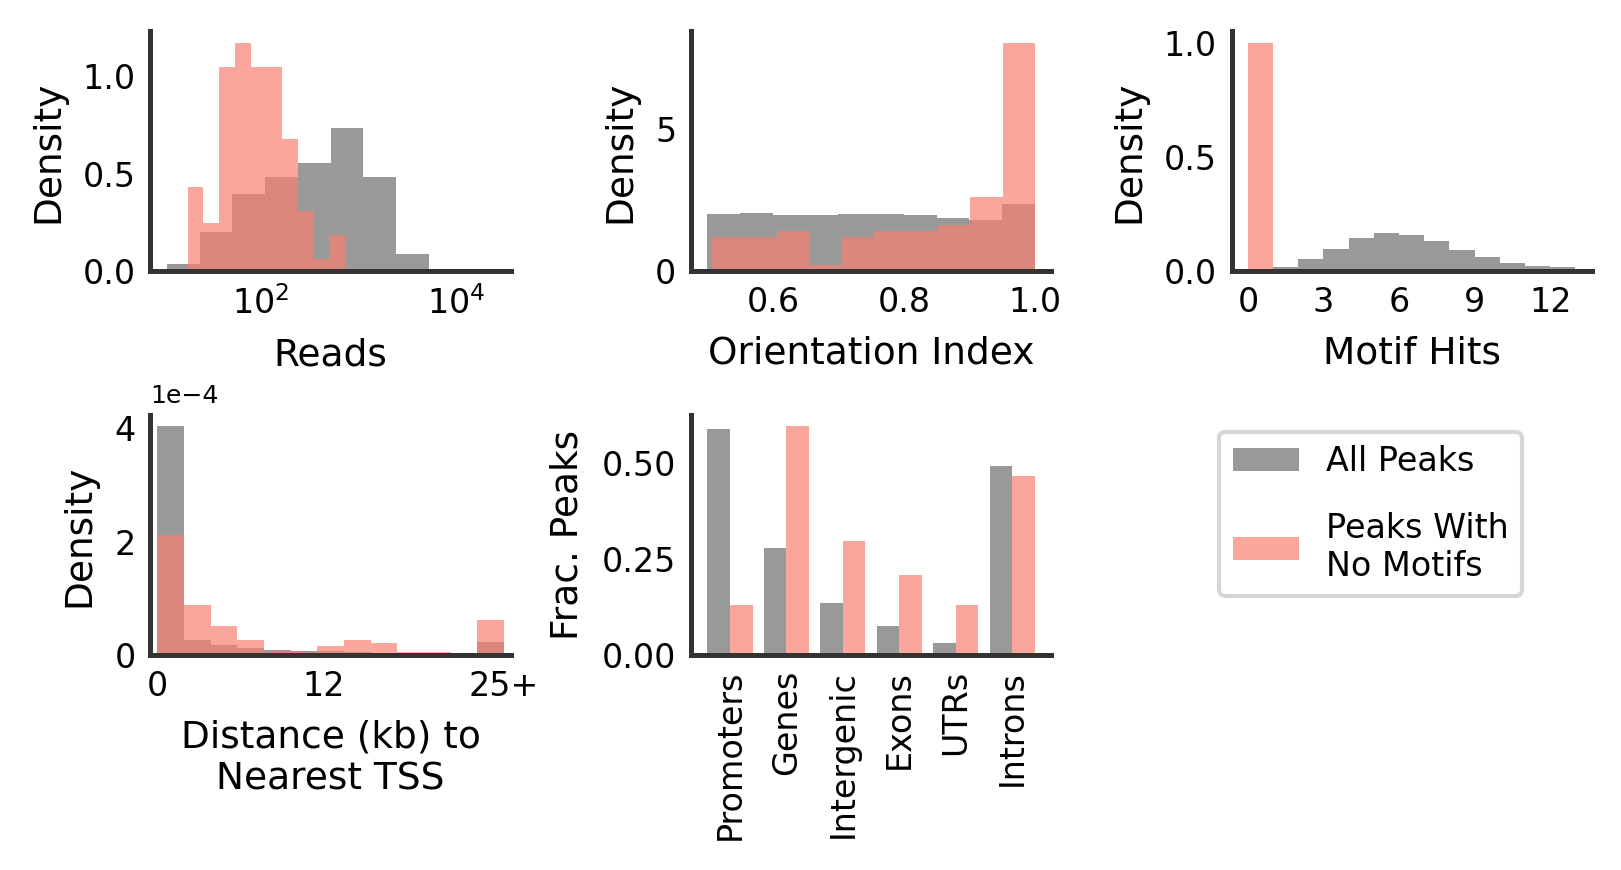

In [43]:
def make_ax_pretty(ax, linewidth=1.2, ax_color = "#333333", ticklabelsize=8):
    ax.spines["left"].set_linewidth(linewidth)
    ax.spines["bottom"].set_linewidth(linewidth)
    ax.spines["left"].set_color(ax_color)
    ax.spines["bottom"].set_color(ax_color)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    
    ax.tick_params(length=0, labelsize=ticklabelsize)
    

def make_plots_for_weird_sites(weird_site_indexes, true_profs, true_counts,
                               peak_hit_counts, gene_region_annots, TSS_dists):
    
    group_names = ["All Peaks", "Peaks With\nNo Motifs"]
    
    regions_to_labels = {"promoters" : "Promoters",
                        "genes" : "Genes",
                        "genes_not_TSS" : "Genes",
                        "exons" : "Exons",
                        "exons_not_TSS" : "Exons",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTRs",
                        "utrs_not_TSS" : "UTRs",
                        "introns" : "Introns"}
    regions_to_plot = ["promoters", "genes_not_TSS", "intergenic_not_TSS",
                       "exons_not_TSS", "utrs_not_TSS", "introns"]
    
    
    fig, axes = plt.subplots(2, 3, figsize=(6.2,2.7), dpi=300)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    axes = axes.flatten()
    
    # Counts histogram
    
    log_all_true_counts = np.log10(true_counts + 1)
    log_weird_site_true_counts = np.log10(true_counts[weird_site_indexes] + 1)
    
    axes[0].hist(log_all_true_counts, alpha=0.8, density=True, color="gray")
    axes[0].hist(log_weird_site_true_counts, alpha=0.7, density=True, color="salmon")
    
    axes[0].set_xlabel("Reads", fontsize=9)
    axes[0].set_ylabel("Density", fontsize=9)
    
    xticks = [2,4]
    axes[0].set_xticks(xticks, [r'$10^{' + str(i) + r'}$' for i in xticks])
    
    # OI histogram
    
    ois = get_orientation_indexes(true_profs)
    
    axes[1].hist(ois,
                 alpha=0.8, density=True, color="gray")
    axes[1].hist(ois[weird_site_indexes],
                 alpha=0.7, density=True, color="salmon")
    
    axes[1].set_xlabel("Orientation Index", fontsize=9)
    axes[1].set_ylabel("Density", fontsize=9)
    
    # Motif hits histogram
    
    motif_hits = peak_hit_counts.sum(axis=1)
    axes[2].hist(motif_hits,
             bins=range(14), alpha=0.8, density=True, color="gray")
    axes[2].hist(motif_hits[weird_site_indexes],
             bins=range(14), alpha=0.7, density=True, color="salmon")
    
    axes[2].set_xlabel("Motif Hits", fontsize=9)
    axes[2].set_ylabel("Density", fontsize=9)
    
    axes[2].set_xticks(range(0,14,3))
    
    #for axis in axes:
    #    make_ax_pretty(axis)
    
    # disappear unused axis
    #axes[-1].remove()
    
    #plt.show()
    #return
    # TSS distances histogram

    stop_point = 25000
    num_bins = int(np.ceil(stop_point / 2000))
    axes[3].hist([min(d, stop_point) for d in TSS_dists if d is not None],
             density=True, bins=num_bins,
             alpha=0.8, color="gray")
    axes[3].hist([min(d, stop_point) for d in TSS_dists[weird_site_indexes] if d is not None],
             density=True, bins=num_bins,
             alpha=0.7, color="salmon")

    axes[3].set_xlim(-500, stop_point + 500)
    axes[3].set_xlabel("Distance (kb) to\nNearest TSS", fontsize=9)
    axes[3].set_ylabel("Density", fontsize=9)
    axes[3].ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
    axes[3].yaxis.offsetText.set_fontsize(6)
    
    middle_tick = int(stop_point / 2000) * 1000
    axes[3].set_xticks([0, middle_tick, stop_point],
                       ["0", middle_tick // 1000, str(stop_point // 1000) + "+"])
    
    # Gene annotation regions double bar plot

    fracs_overall = []
    fracs_in_region = []
    for region_name in regions_to_plot:
        region_bools = gene_region_annots[region_name]
        frac_overall = sum(region_bools) / len(region_bools)
        frac_in_region = sum(region_bools[weird_site_indexes]) / len(region_bools[weird_site_indexes])
        fracs_overall.append(frac_overall)
        fracs_in_region.append(frac_in_region)

    barplot_x_vals = np.arange(len(fracs_overall))
    bar_width = 0.4
    b1 = axes[4].bar(barplot_x_vals, fracs_overall,
                 width=bar_width, label=group_names[0], color="gray", alpha=0.8)
    # Same thing, but offset the x.
    b2 = axes[4].bar(barplot_x_vals + bar_width, fracs_in_region,
                 width=bar_width, label=group_names[1], color="salmon", alpha=0.7)

    # x axis ticks need to be offset to go under center of two bars
    axes[4].set_xticks(barplot_x_vals + bar_width / 2,
                       labels=[regions_to_labels[region_name] for region_name in regions_to_plot],
                       rotation=90, fontsize=6)
    axes[4].set_ylabel("Frac. Peaks", fontsize=9)

    # will function as legend for all subplots
    axes[4].legend(bbox_to_anchor=(1.42,1), loc="upper left",
               frameon=True, labelspacing=1, fontsize=8)
    
    
    # cosmetics for each subplot
    for axis in axes:
        make_ax_pretty(axis)
    
    # disappear unused axis
    axes[-1].remove()
    
    plt.show()
    
    
make_plots_for_weird_sites(np.where(motif_hit_counts["profile"].sum(axis=-1) == 0)[0],
                           true_profs, true_profs.sum(axis=(-2,-1)),
                               motif_hit_counts["profile"], gene_region_annots, TSS_dists)

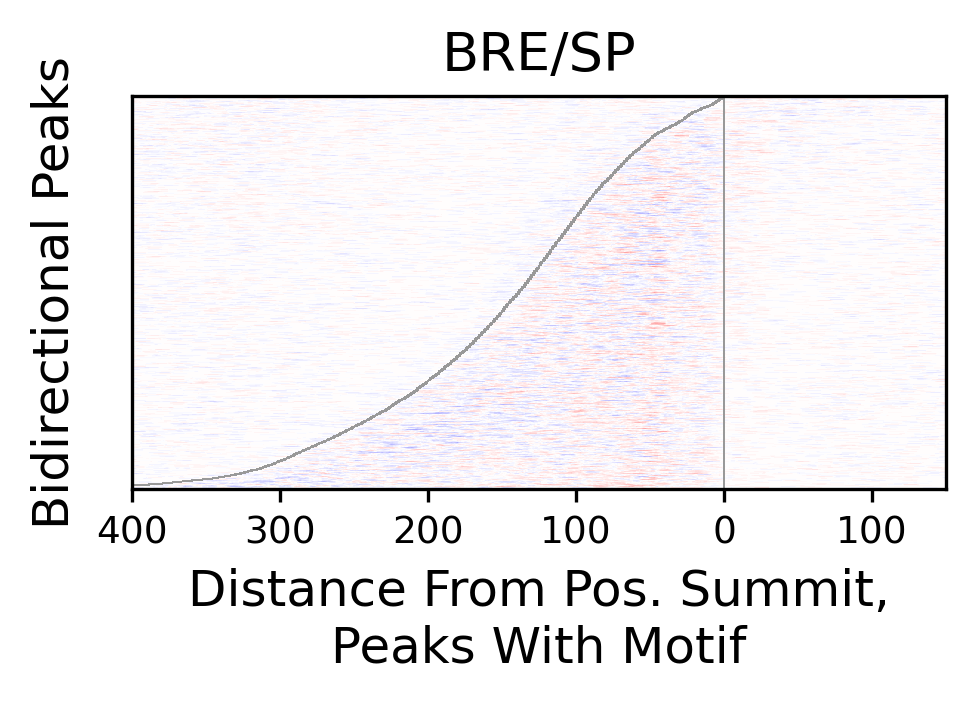

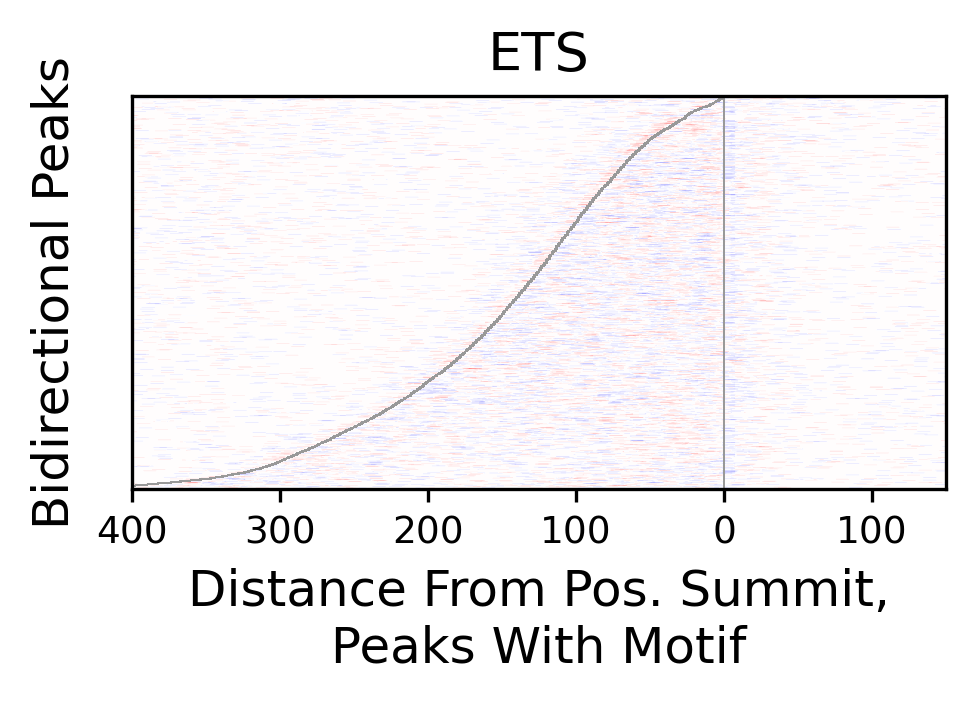

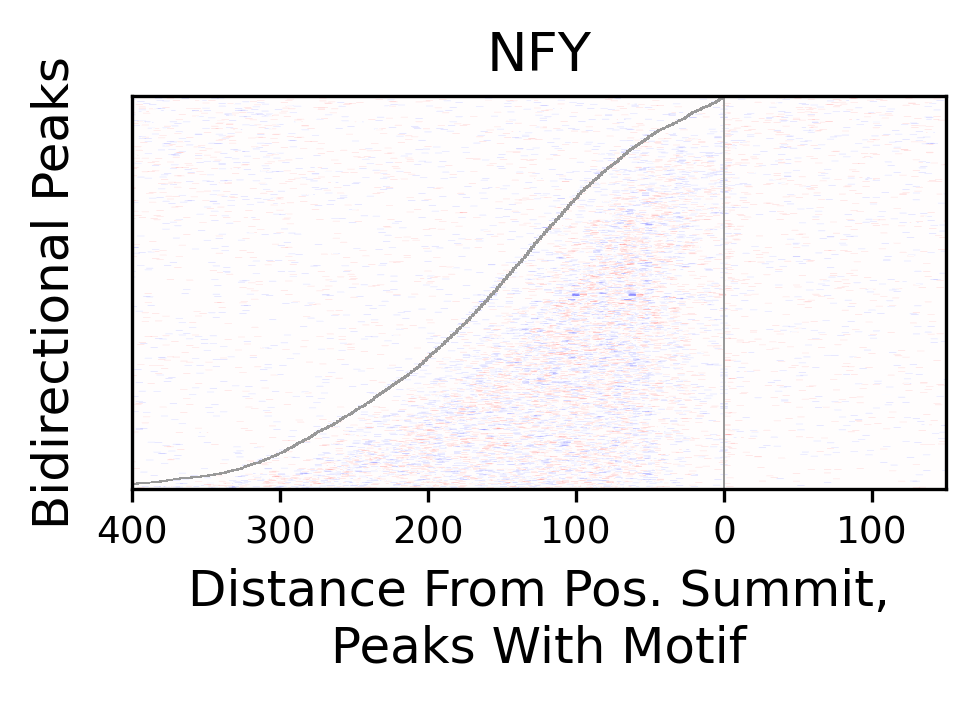

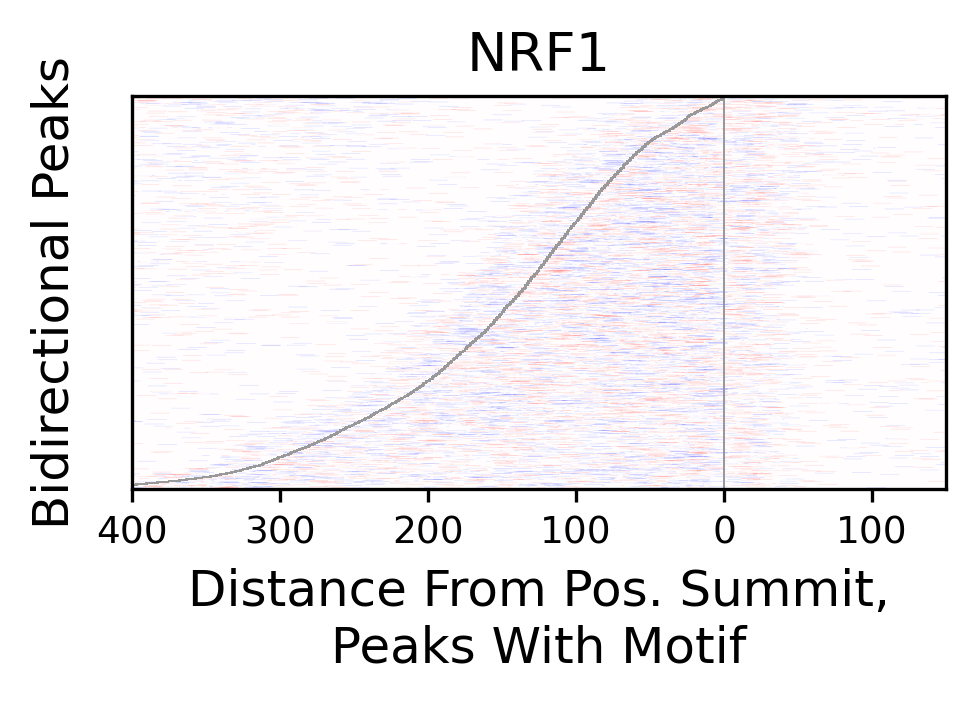

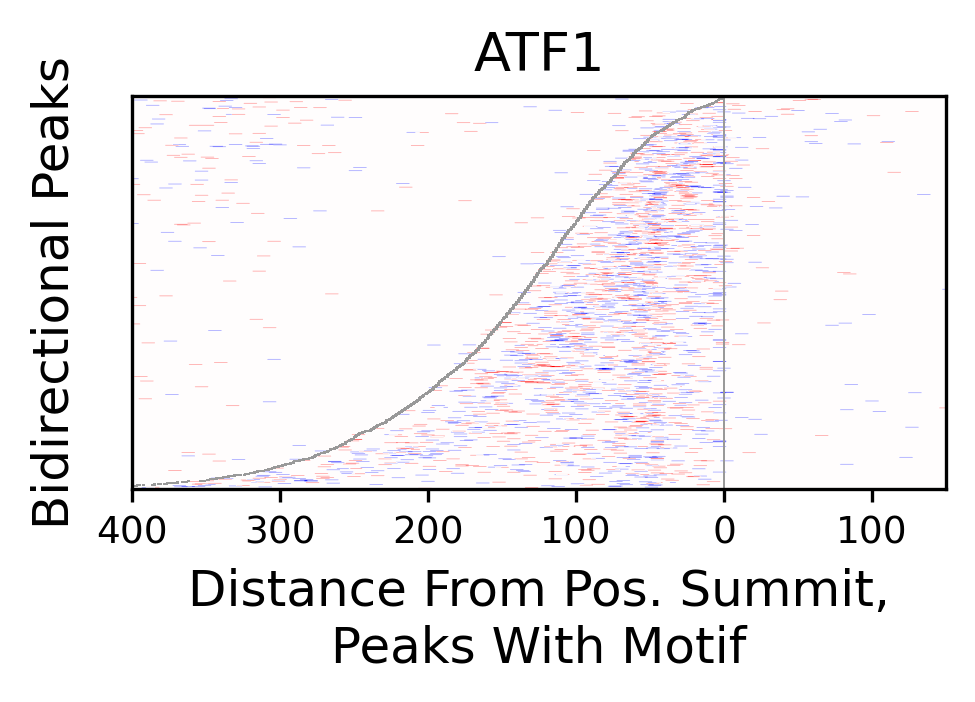

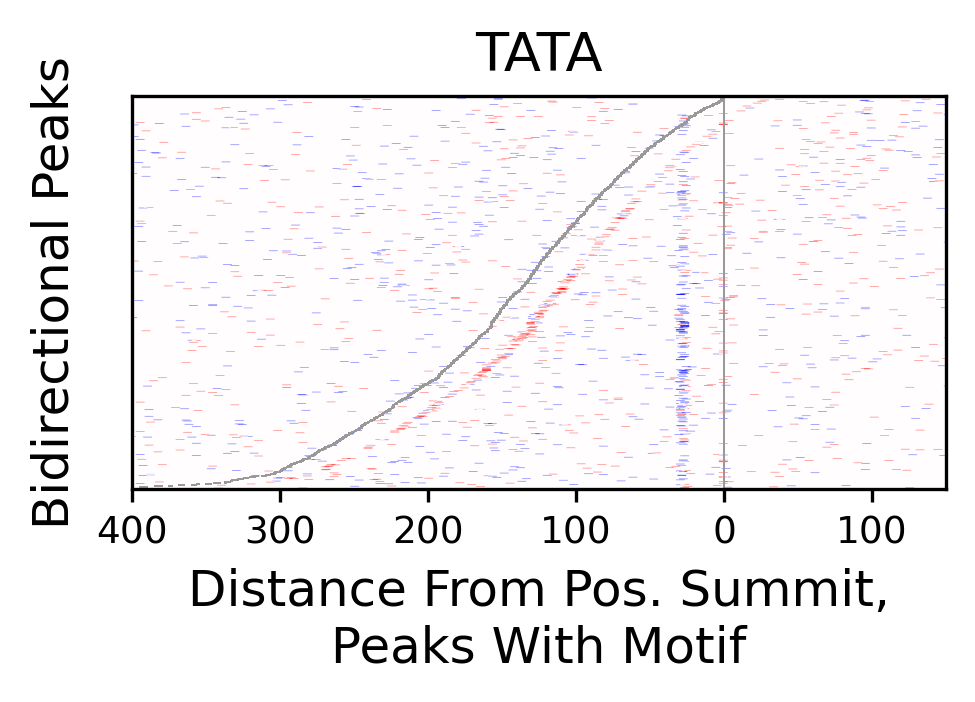

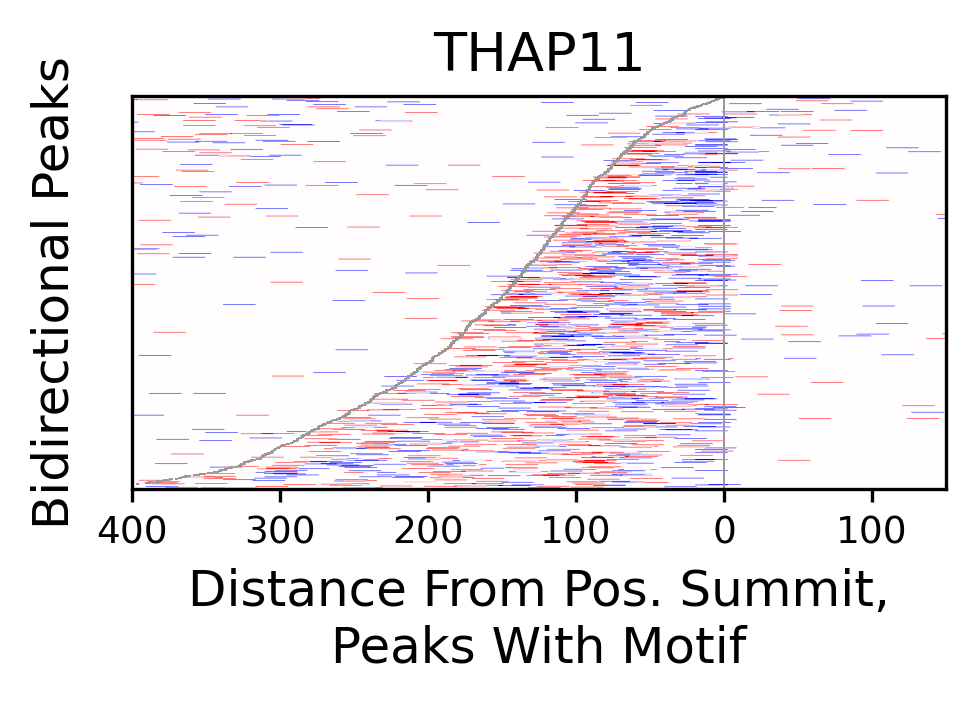

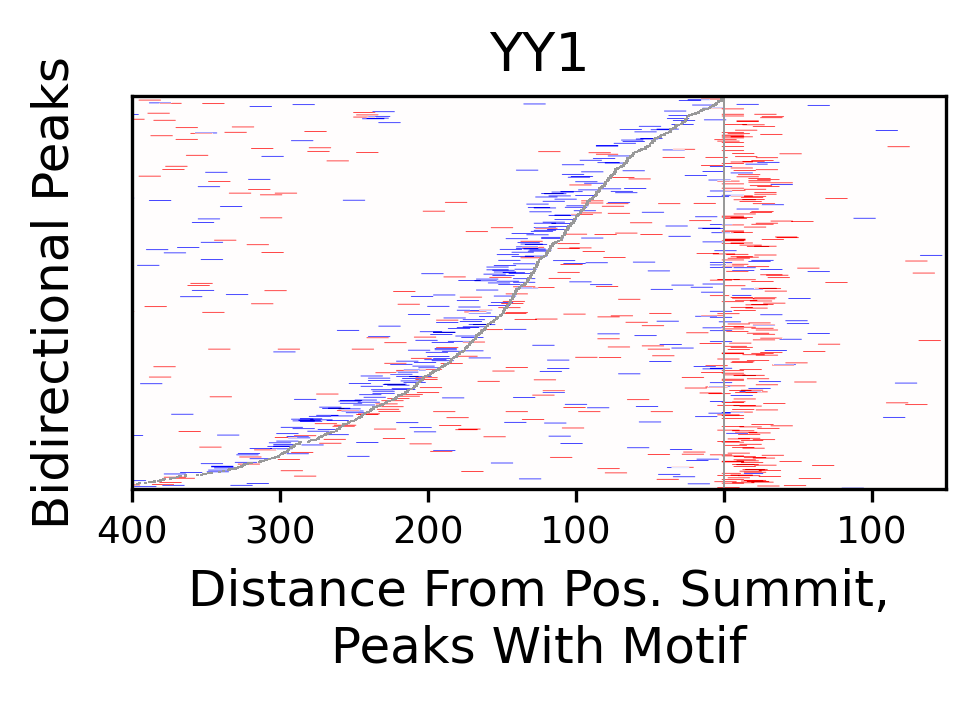

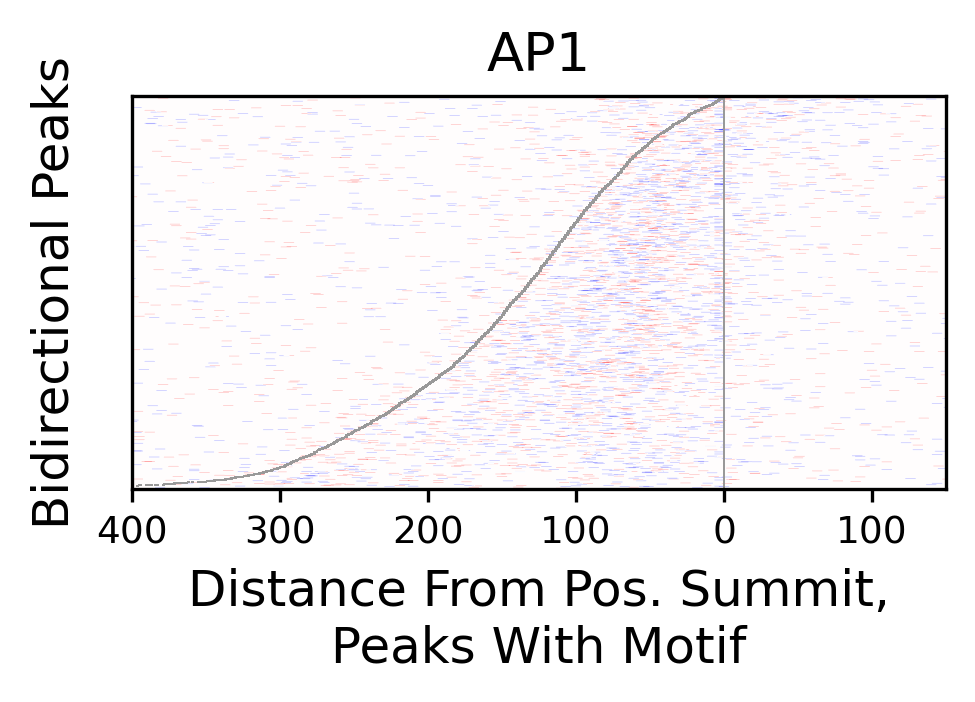

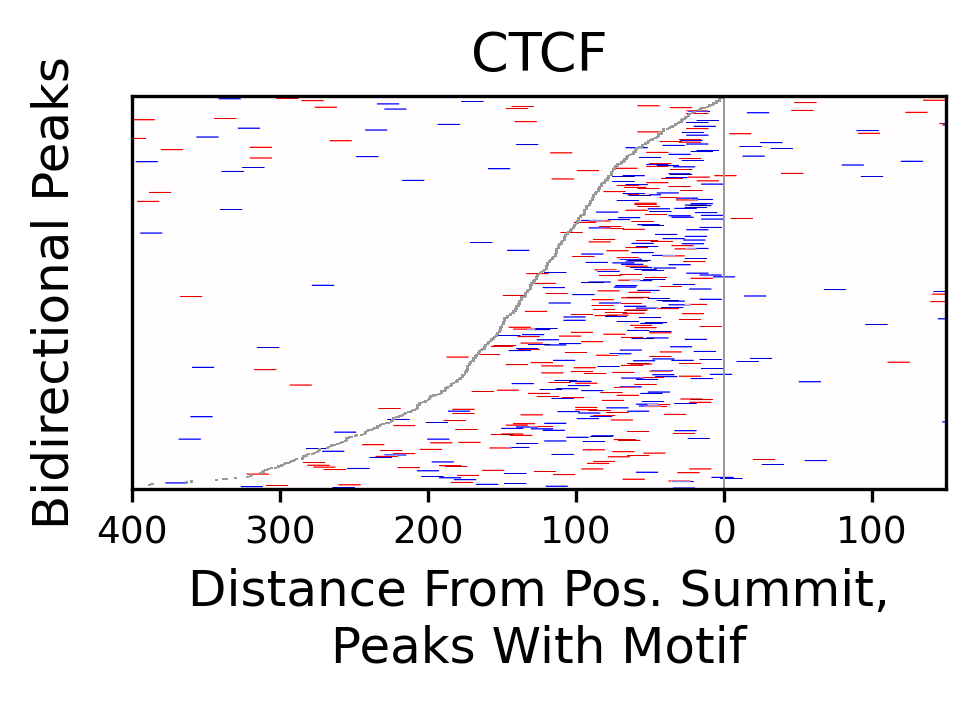

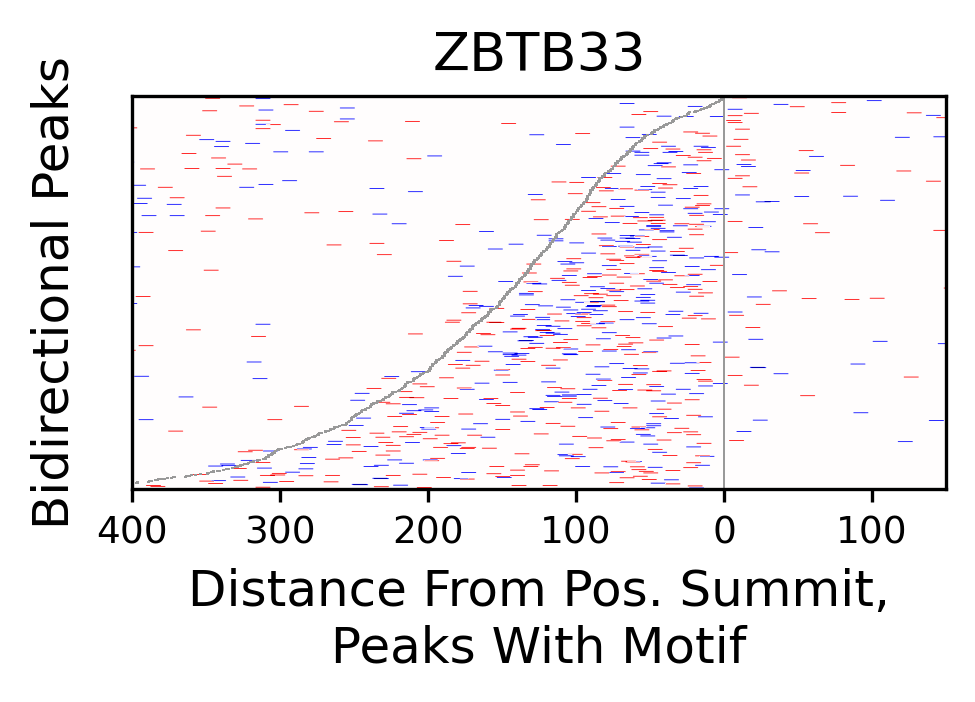

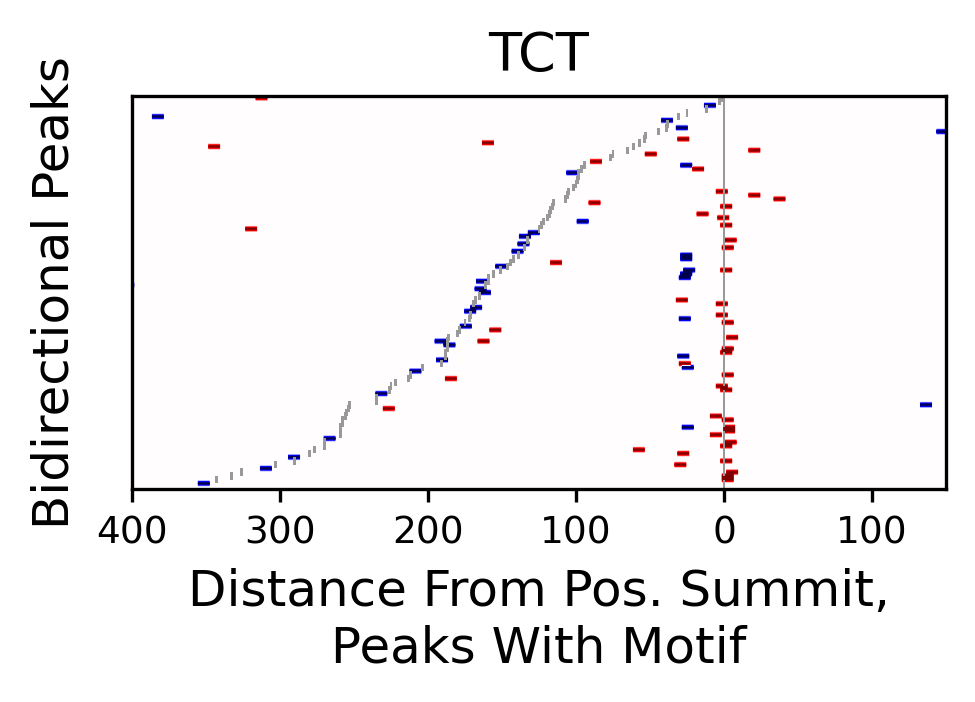

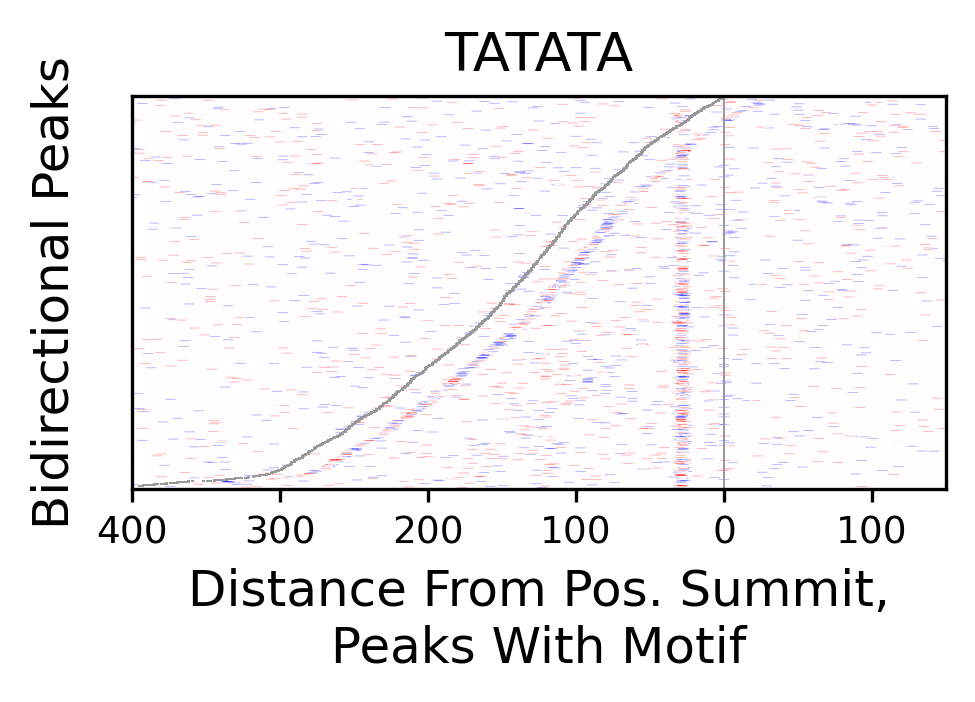

In [29]:
import matplotlib

def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


def plot_motif_pos_dist(motif_key, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", bi_center = True, draw_summit = False, all_peaks = False,
                        save_dir = None):
    
    assert uni_or_bi in ["uni", "bi"], uni_or_bi
    assert bi_center in [False, True], bi_center
    assert draw_summit in [False, True], draw_summit
    
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    peak_widths = []
    summit_bi_pairs = []
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["motif_index"] == motif_key]

        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            if summit_pos < summit_neg:
                continue  # sometimes the bidirectional peak is backwards from the usual way...
            if bi_center:
                summit = (summit_pos + summit_neg) // 2
            else:
                summit = summit_pos
            
        summit_offset = summit - peak_start - in_window // 2
        
        if hits_of_this_motif.shape[0] > 0:
            motif_hit_positions = np.zeros((out_window,))

            for _, hit in hits_of_this_motif.iterrows():
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                hit_start = hit_start - summit_offset
                hit_end = hit_end - summit_offset
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
                
        elif all_peaks:
            # add empty vector
            motif_hit_positions = np.zeros((out_window,))
            
            if peak_is_unidirectional:
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    summit_bi_pairs = np.array(summit_bi_pairs)
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][np.array(peak_widths).argsort()]
    summit_bi_pairs = summit_bi_pairs[np.array(peak_widths).argsort()]
    
    
    hit_positions = motif_hit_positions_across_peaks[uni_or_bi]
    
    if uni_or_bi == "bi":
        plt.figure(figsize=(3.5, 1.7), dpi=300)

        if draw_summit:
            for i in range(len(hit_positions)):
                for pos in summit_bi_pairs[i]:
                    summit_spot = pos + hit_positions.shape[-1] // 2
                    if hit_positions[i, summit_spot] == 0:
                        hit_positions[i, summit_spot] = np.nan

    else:
        plt.figure(figsize=(3.5, 1.7), dpi=300)
        
        if draw_summit:
            for i in range(len(hit_positions)):
                hit_positions[i, 500] = np.nan

    cmap = matplotlib.cm.get_cmap("seismic").copy()
    cmap.set_bad(color='#999999')
    plt.imshow(hit_positions, aspect="auto", cmap=cmap)

    #key_cap = key[0].upper() + key[1:]
    plt.title(motif_names[motif_key], fontsize=13)

    xticks = np.arange(0, out_window + 1, 100)
    plt.xticks(xticks, np.abs(xticks - out_window // 2), fontsize=9)

    if uni_or_bi == "bi" and bi_center:
        plt.xlim(250, out_window - 250)
    elif uni_or_bi == "bi":
        plt.xlim(100, out_window - 350)
    else:
        plt.xlim(100, out_window - 350)

    plt.gca().tick_params(length=3)


    if uni_or_bi == "bi":
        plt.ylabel("Bidirectional Peaks", fontsize=12, labelpad=10)
        if all_peaks:
            plt.xlabel("Distance From Pos. Summit", fontsize=12)
        else:
            plt.xlabel("Distance From Pos. Summit,\nPeaks With Motif", fontsize=12)
    else:
        plt.ylabel("Unidirectional Peaks", fontsize=12, labelpad=10)
        if all_peaks:
            plt.xlabel("Distance From Summit", fontsize=12)
        else:
            plt.xlabel("Distance From Summit,\nPeaks With Motif", fontsize=12)

    plt.yticks([])

    if save_dir is not None:
        fname = "_".join(["2_motif_pos_dist", motif_names[motif_key].replace("/","-"), uni_or_bi])
        plt.savefig(save_dir + fname + ".png",
                    bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()
        
for i in range(len(motif_names)):
    if motif_names[i] in ["CA-Inr", "TA-Inr"]:
        continue
        
    #plot_motif_pos_dist(i, motif_hits_peaks, coords, 
    #                    uni_or_bi = "uni", bi_center = True, draw_summit = True,
    #                    save_dir = figures_dir)

    plot_motif_pos_dist(i, motif_hits_peaks, coords, 
                        uni_or_bi = "bi", bi_center = False, draw_summit = True,
                        save_dir = figures_dir)
    

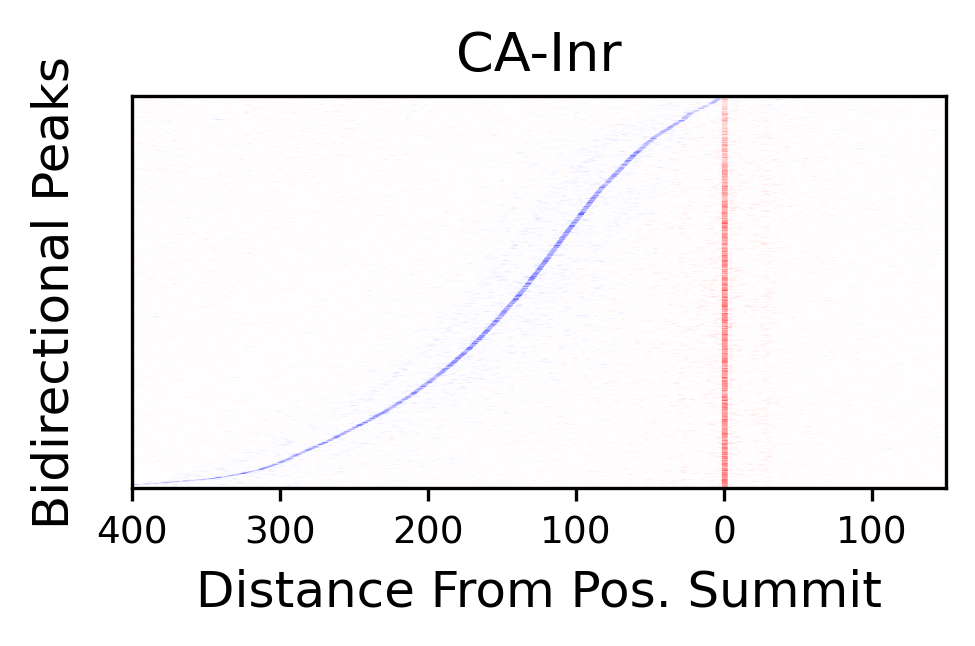

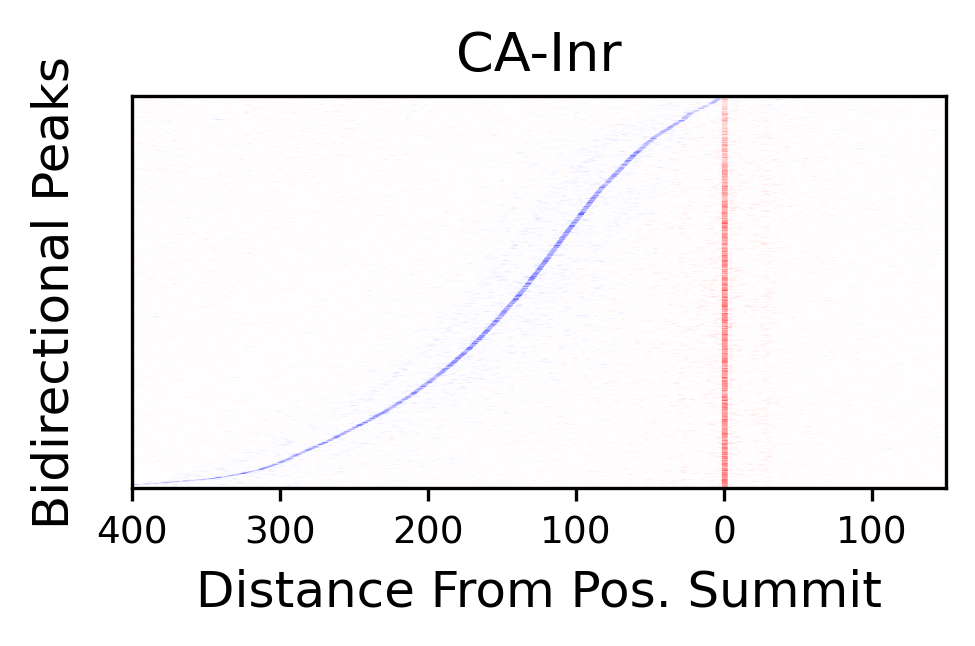

In [30]:
for i in range(len(motif_names)):
    if motif_names[i] in ["CA-Inr", "TA-Inr"]:
        #plot_motif_pos_dist(1, motif_hits_peaks, coords, 
        #                    uni_or_bi = "uni", draw_summit = False, all_peaks = True,
        #                    save_dir = figures_dir)

        plot_motif_pos_dist(1, motif_hits_peaks, coords, 
                            uni_or_bi = "bi", bi_center = False, draw_summit = False, all_peaks = True,
                            save_dir = figures_dir)

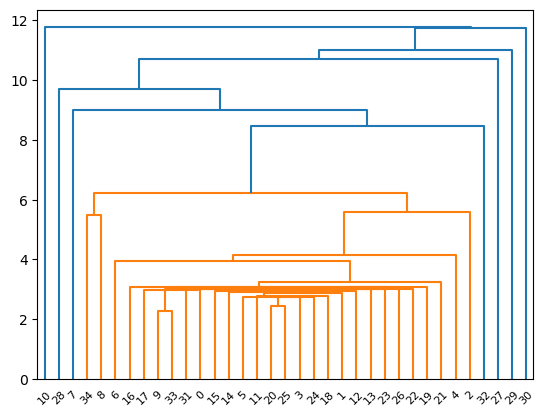

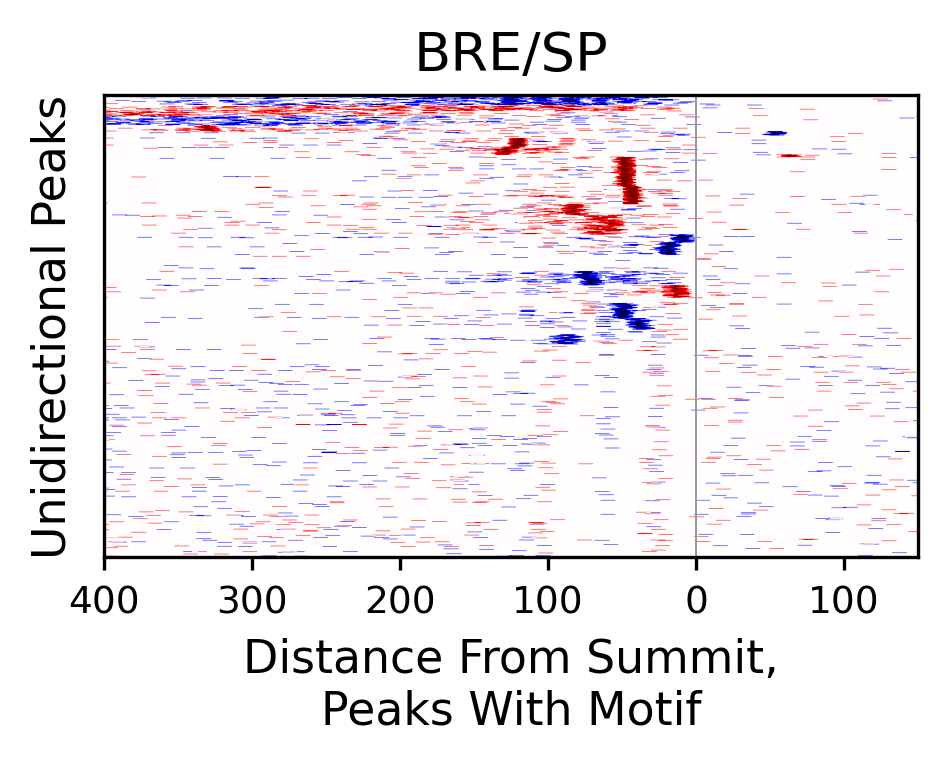

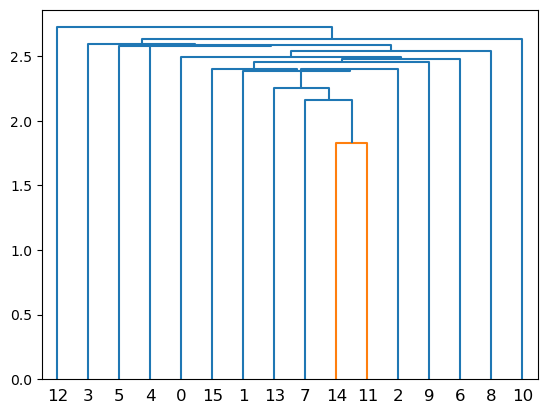

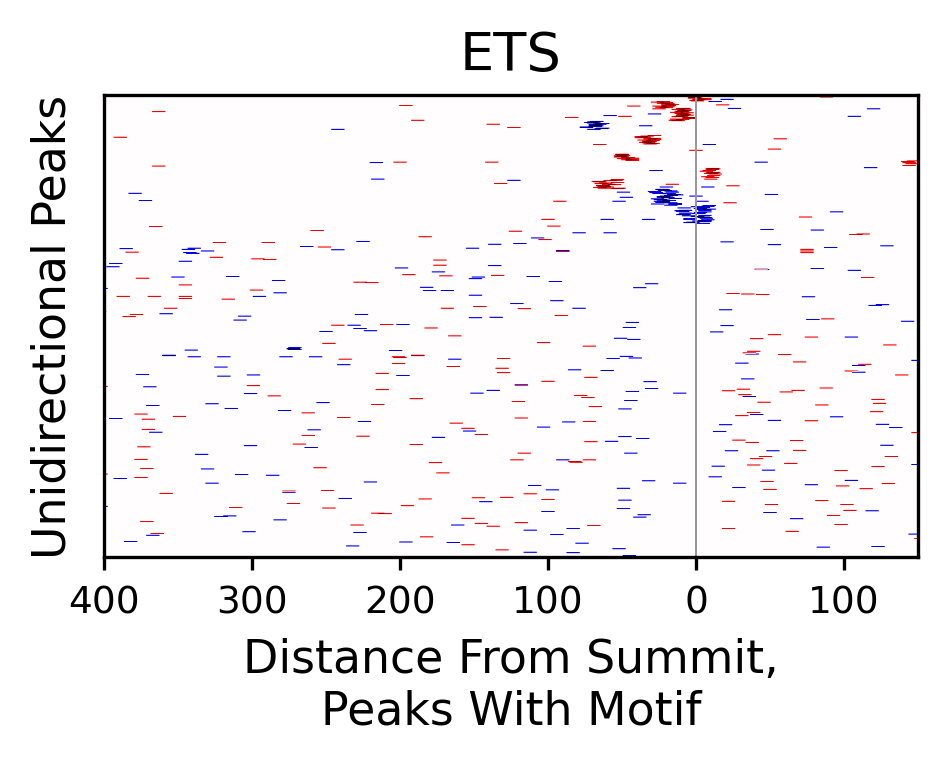

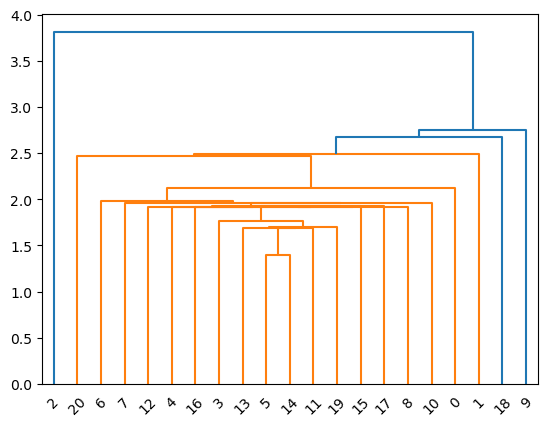

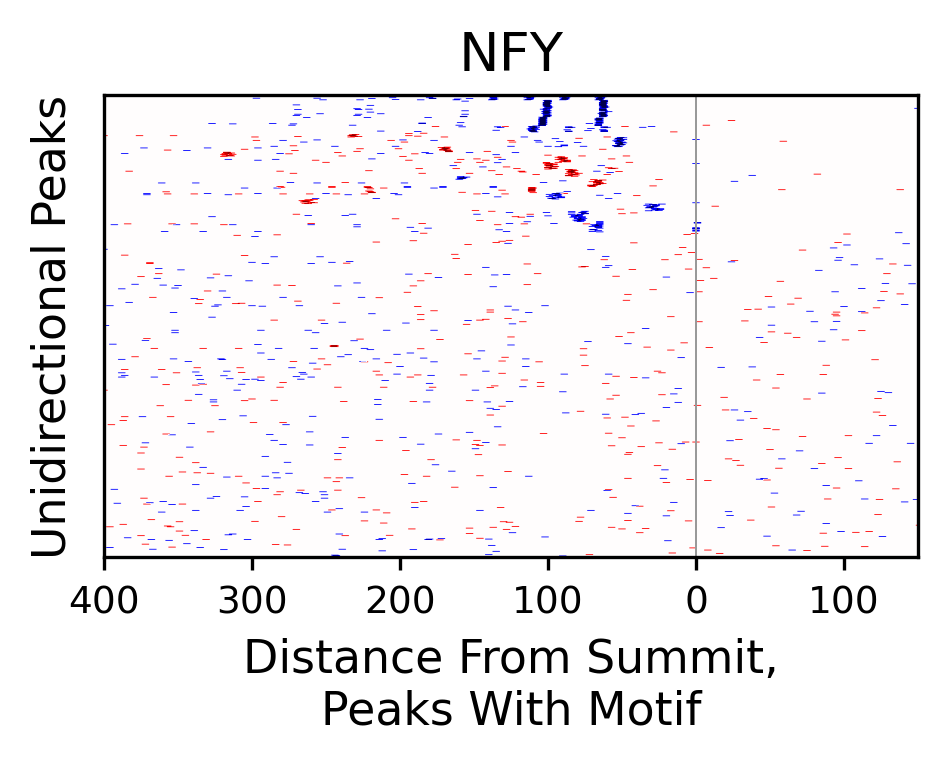

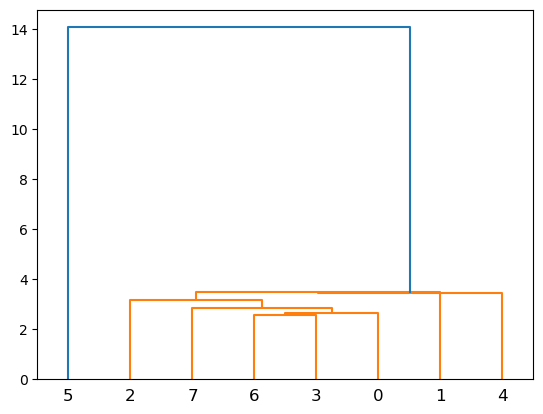

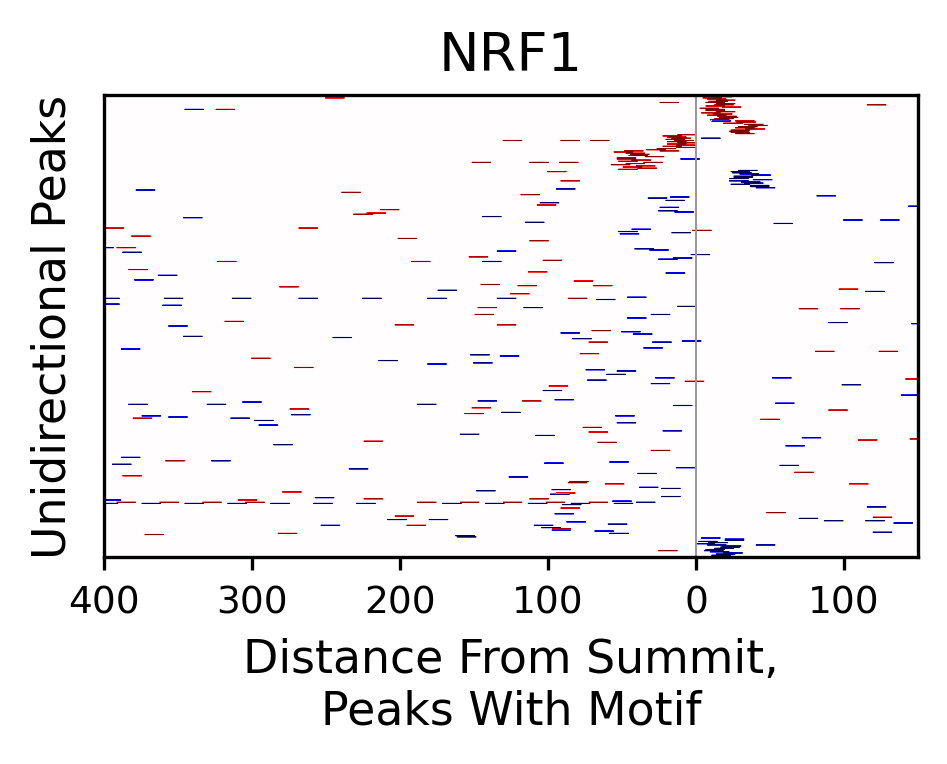

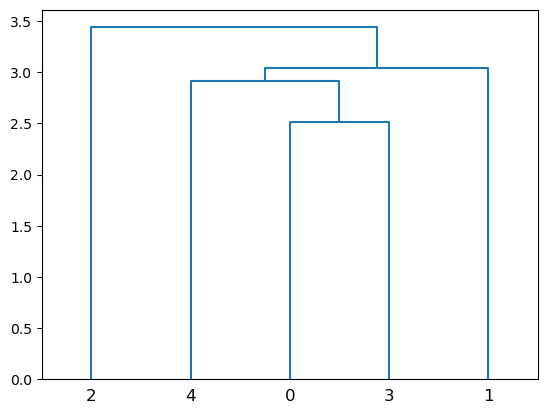

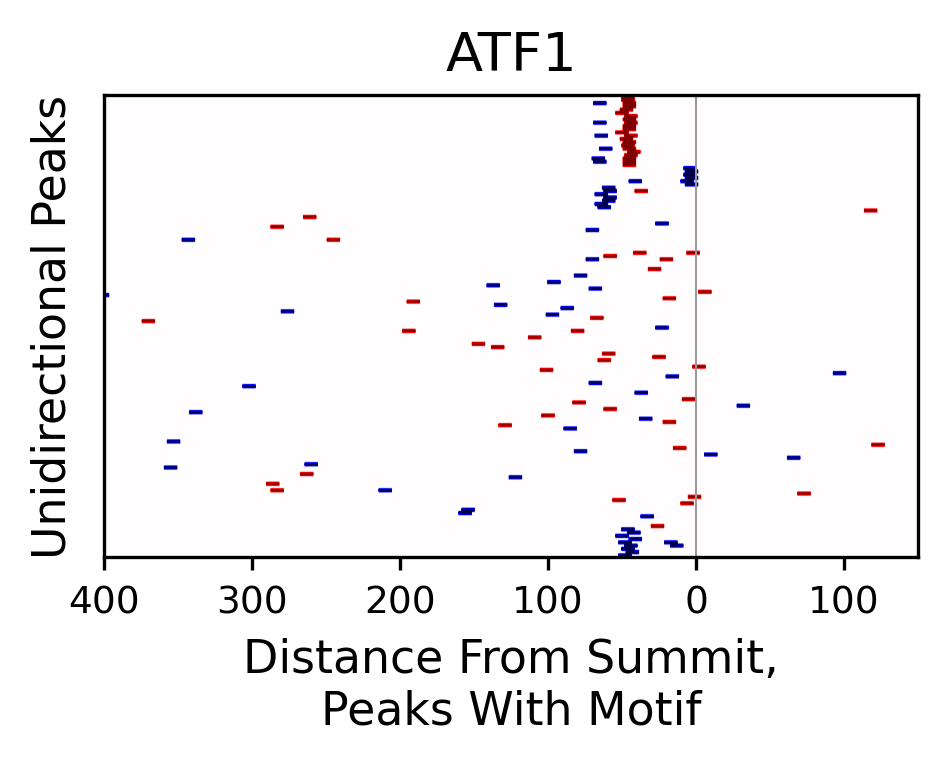

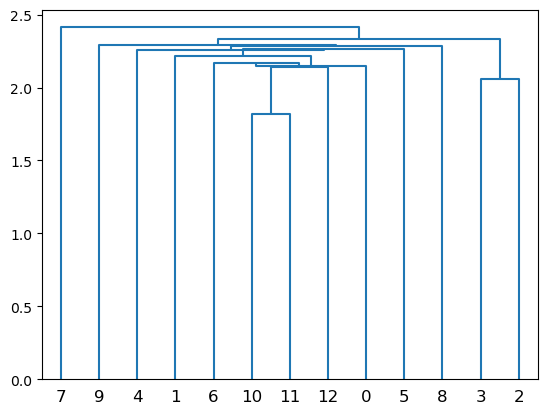

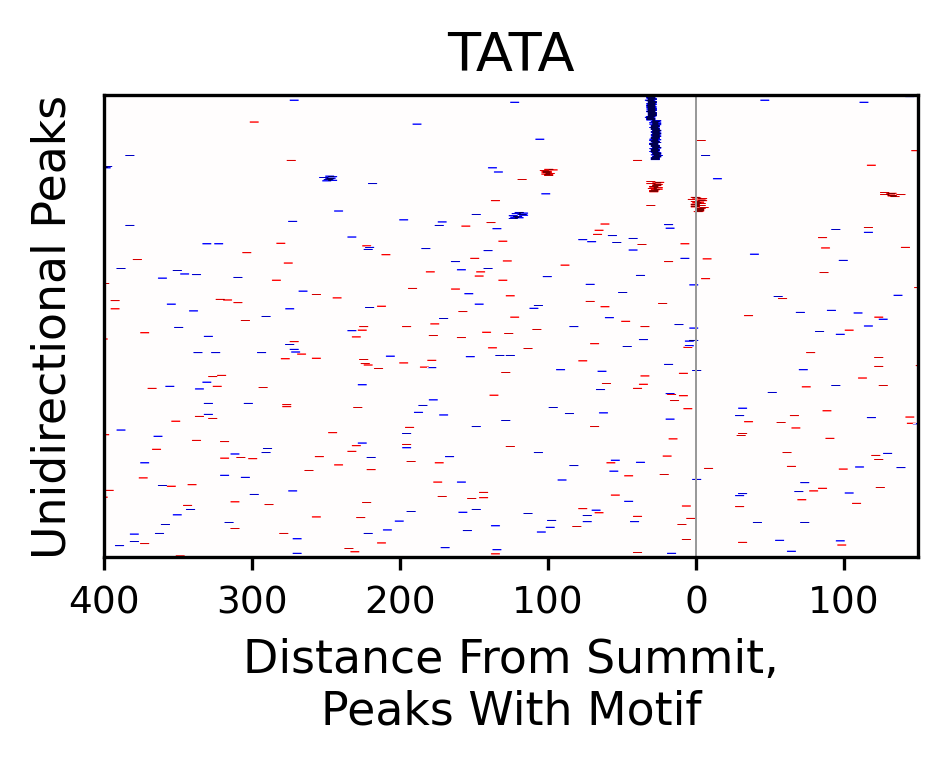

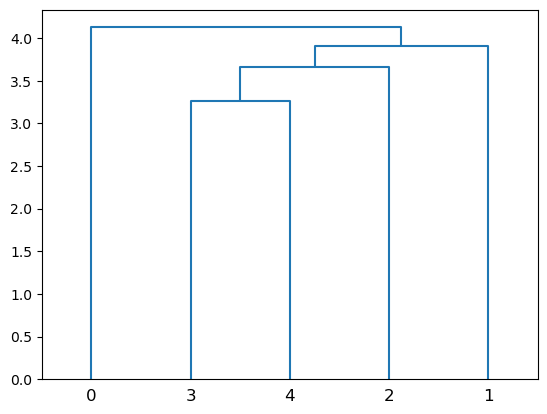

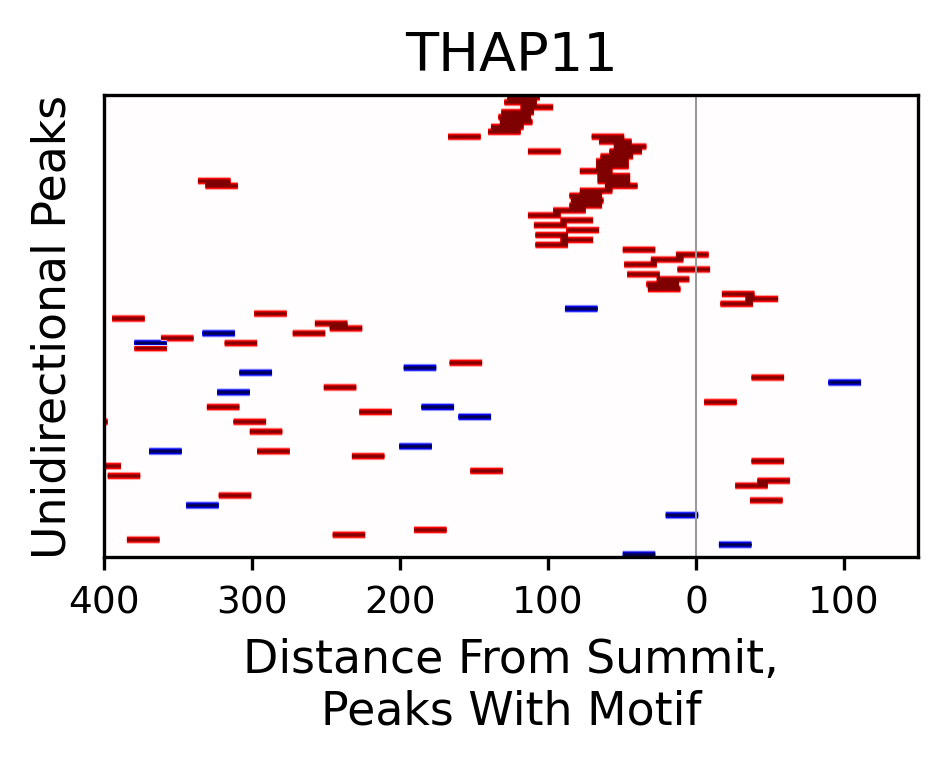

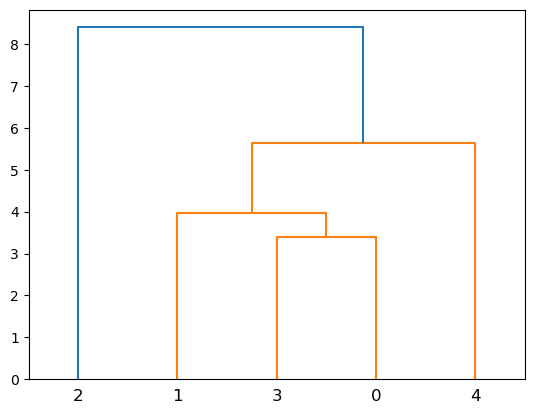

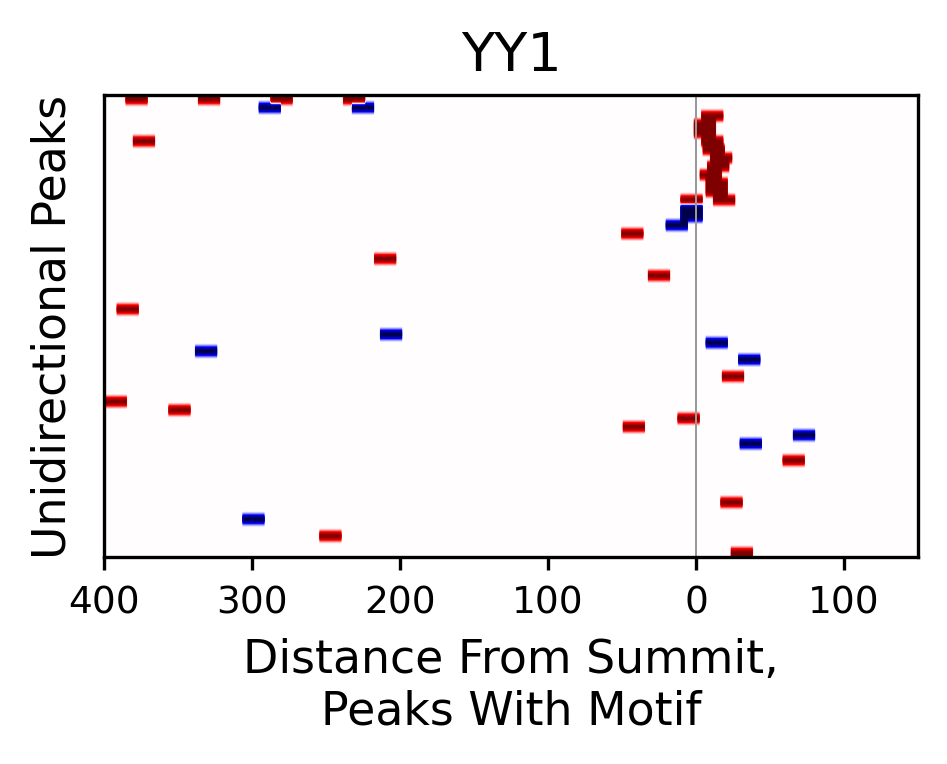

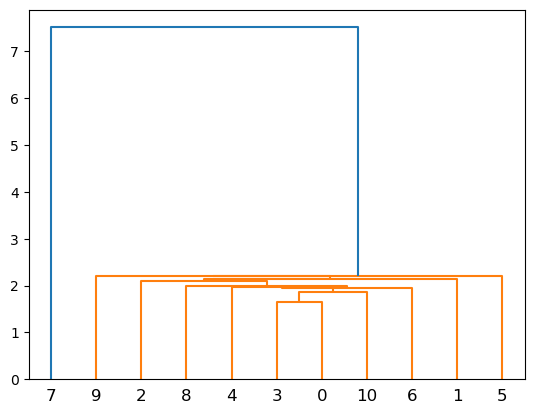

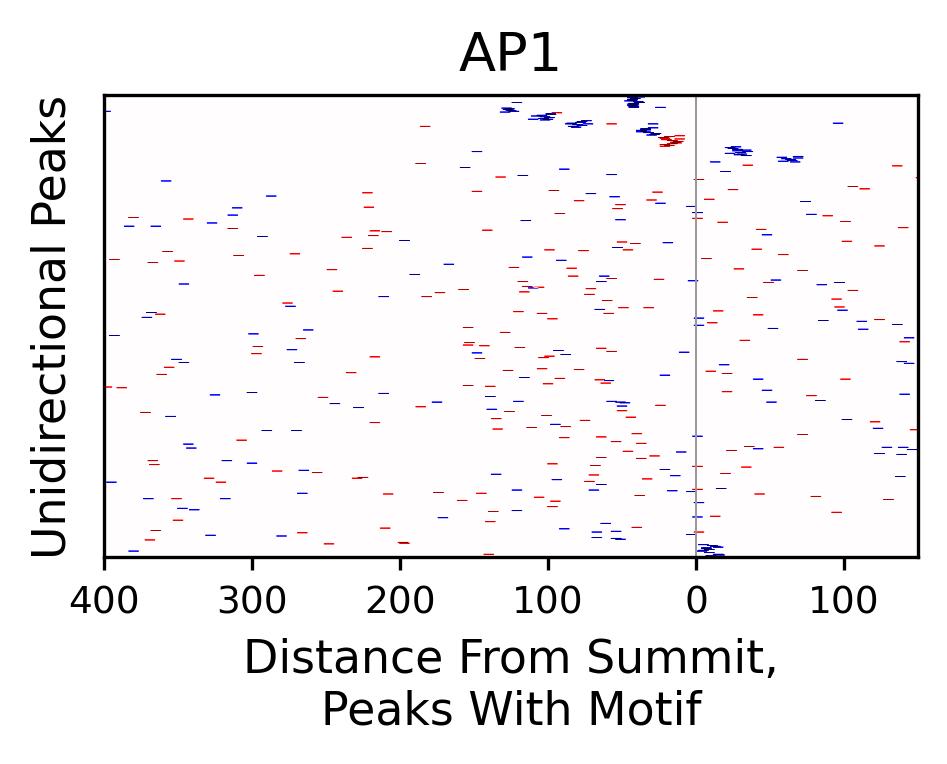

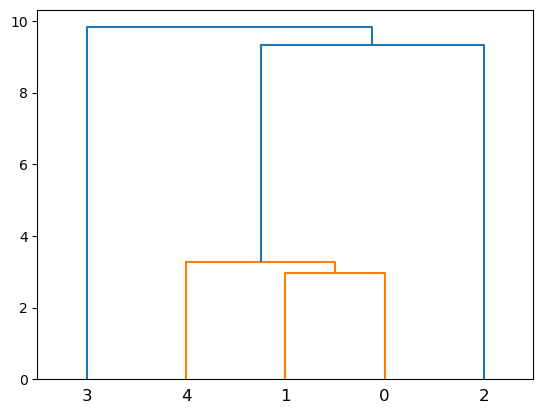

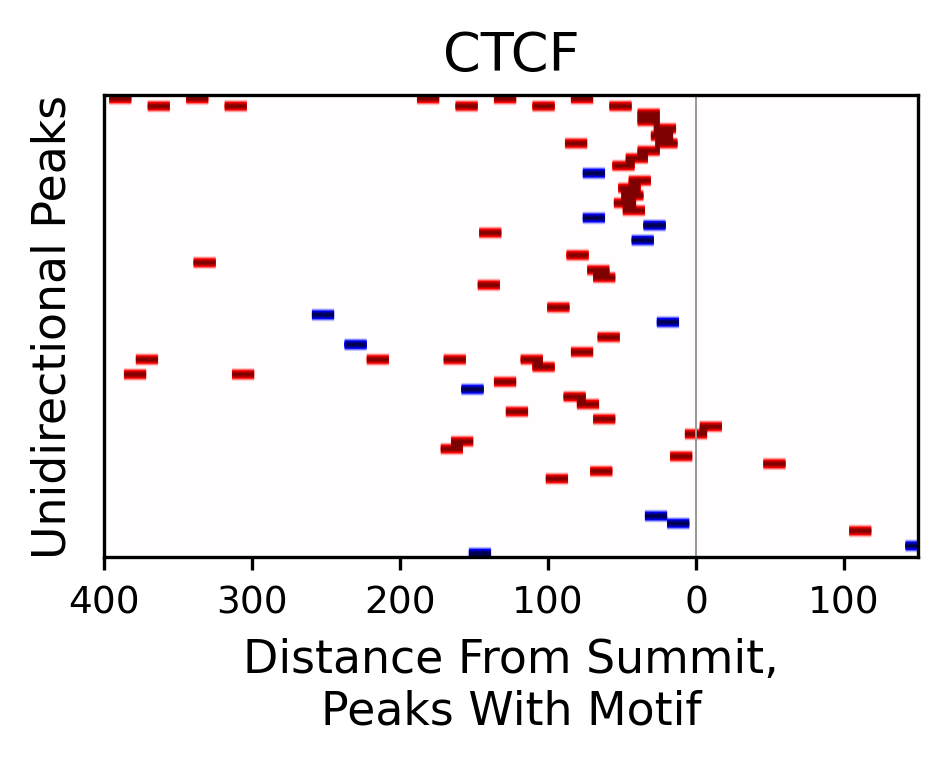

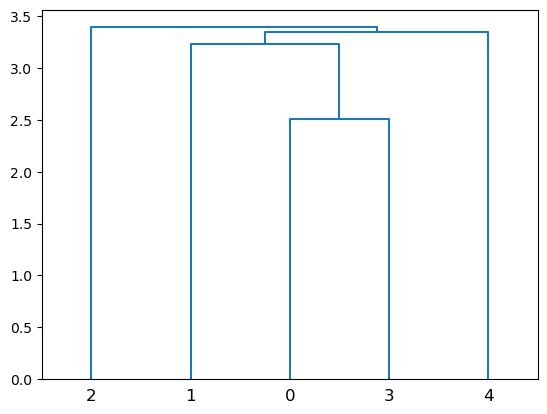

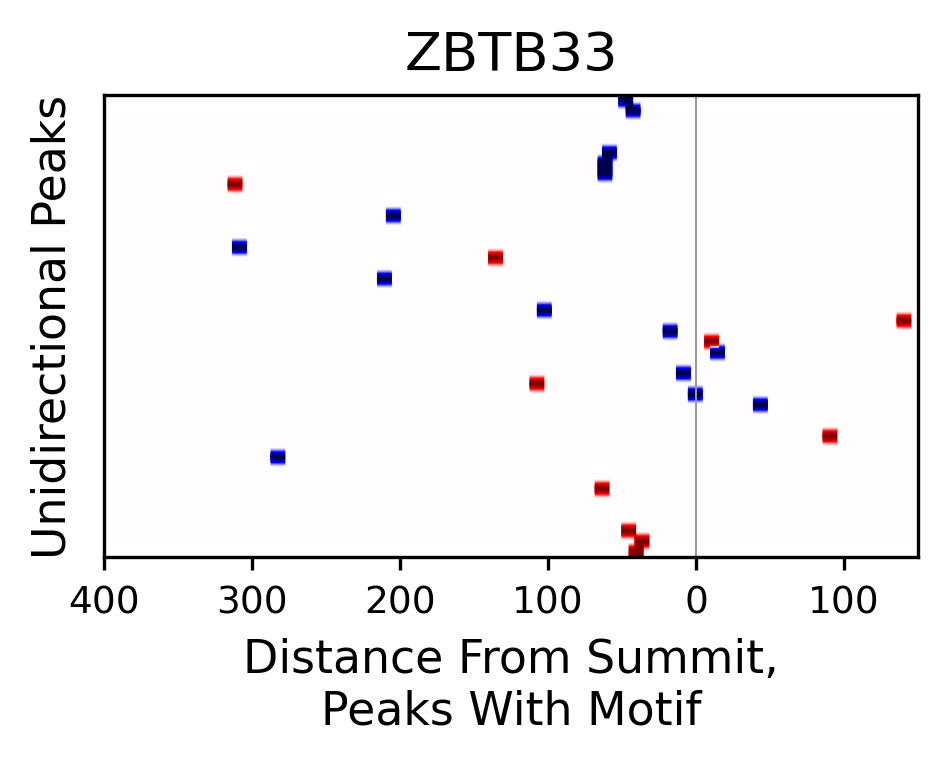

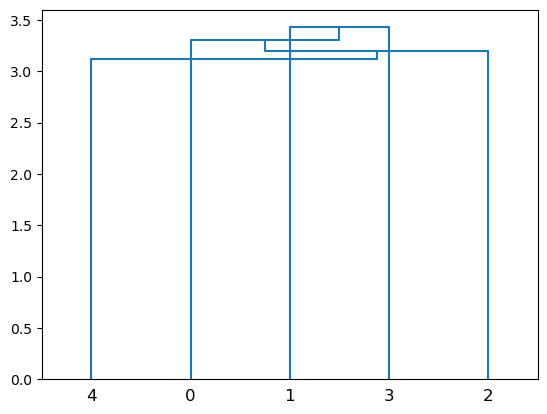

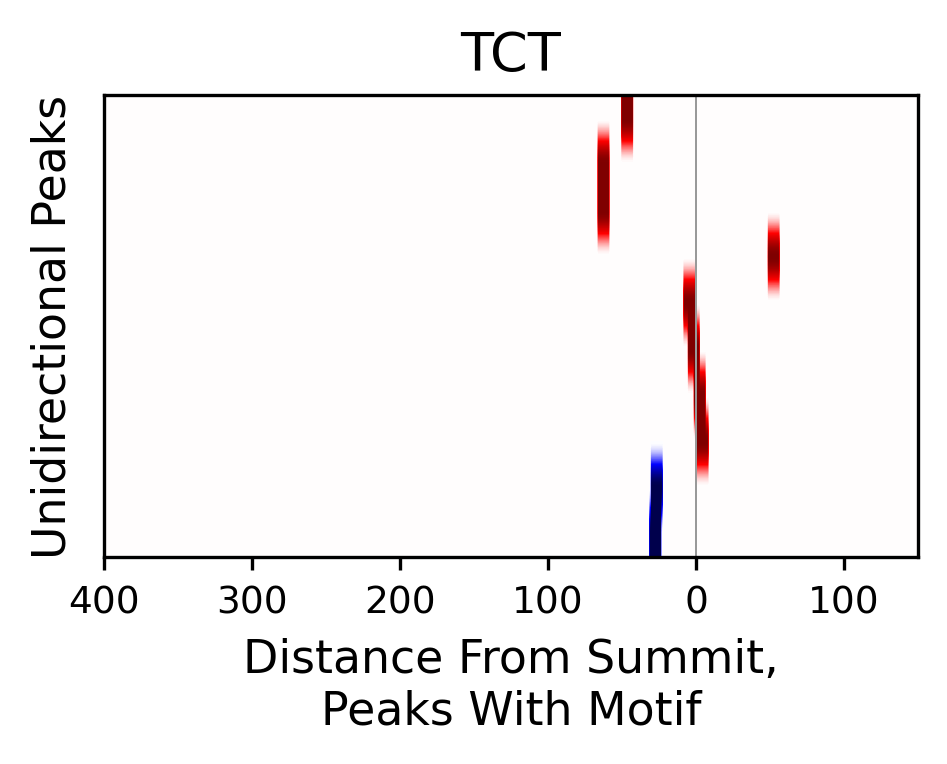

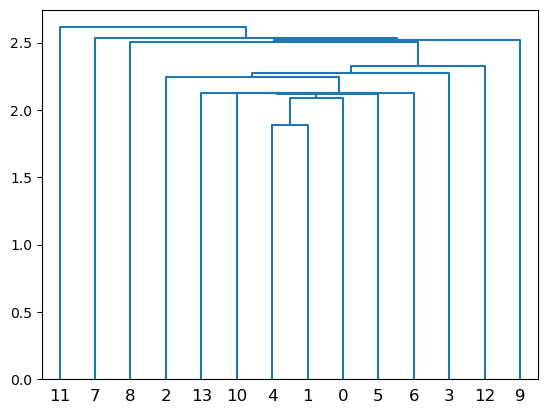

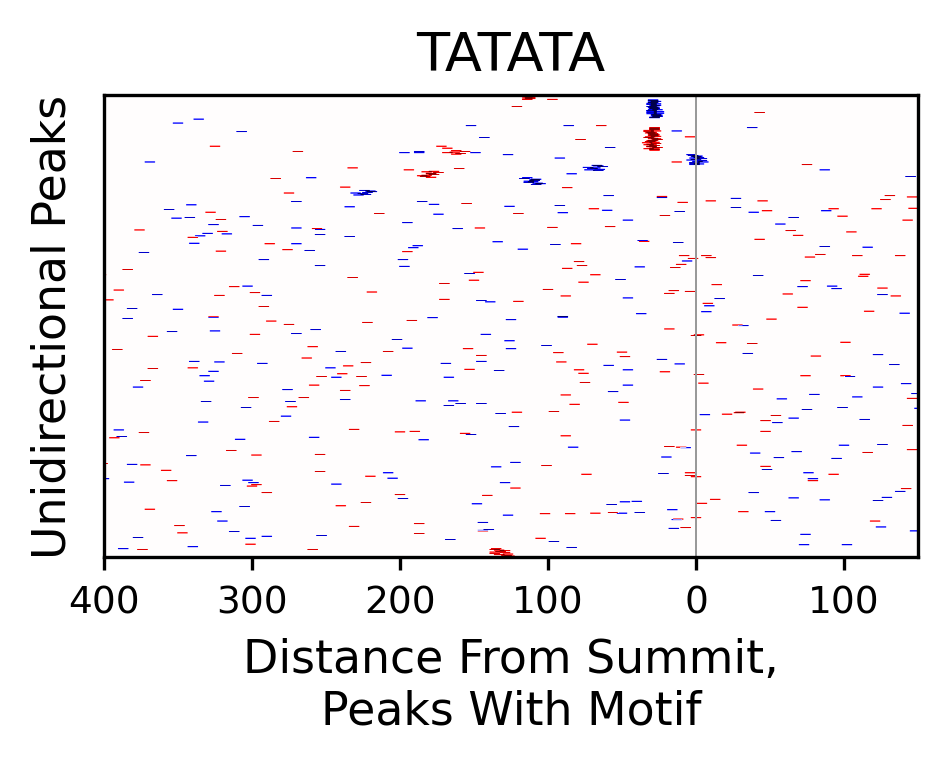

In [63]:
import matplotlib
import sklearn.cluster
import scipy.cluster.hierarchy


def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


def plot_motif_pos_dist(motif_key, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", bi_center = True, draw_summit = False, all_peaks = False,
                        save_dir = None):
    
    assert uni_or_bi in ["uni", "bi"], uni_or_bi
    assert bi_center in [False, True], bi_center
    assert draw_summit in [False, True], draw_summit
    
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    true_counts = true_profs.sum(axis=(-2,-1))
    
    peak_widths = []
    summit_bi_pairs = []
    peak_read_counts = []
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["motif_index"] == motif_key]

        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            if summit_pos < summit_neg:
                continue  # sometimes the bidirectional peak is backwards from the usual way...
            if bi_center:
                summit = (summit_pos + summit_neg) // 2
            else:
                summit = summit_pos
            
        summit_offset = summit - peak_start - in_window // 2
        
        if hits_of_this_motif.shape[0] > 0:
            motif_hit_positions = np.zeros((out_window,))

            for _, hit in hits_of_this_motif.iterrows():
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                hit_start = hit_start - summit_offset
                hit_end = hit_end - summit_offset
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
                peak_read_counts.append(true_counts[peak_index])
            
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
                
        elif all_peaks:
            # add empty vector
            motif_hit_positions = np.zeros((out_window,))
            
            if peak_is_unidirectional:
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
                peak_read_counts.append(true_counts[peak_index])
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    summit_bi_pairs = np.array(summit_bi_pairs)
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][np.array(peak_widths).argsort()]
    summit_bi_pairs = summit_bi_pairs[np.array(peak_widths).argsort()]
    
    
    hit_positions = motif_hit_positions_across_peaks[uni_or_bi]
    
    if uni_or_bi == "bi":
        plt.figure(figsize=(3.5, 3), dpi=300)

        if draw_summit:
            for i in range(len(hit_positions)):
                for pos in summit_bi_pairs[i]:
                    summit_spot = pos + hit_positions.shape[-1] // 2
                    if hit_positions[i, summit_spot] == 0:
                        hit_positions[i, summit_spot] = np.nan

    else:
        #plt.figure(figsize=(3.5, 2), dpi=300)
        #peak_read_counts = np.array(peak_read_counts)
                
        # code below is from Alex Tseng's modisco report code
        
        # Perform k-means clustering on the predicted profiles, with the strands pooled
        kmeans_clusters = max(5, len(hit_positions) // 50)  # Set number of clusters based on number of profiles, with minimum
        #kmeans_clusters = len(hit_positions)
        
        kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
        cluster_assignments = kmeans.fit_predict(hit_positions)
        
        kmeans_centers = kmeans.cluster_centers_
        Z = scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid")
        plt.figure()
        dn = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.optimal_leaf_ordering(Z, kmeans_centers))
        plt.show()
        #return
        
        # Perform hierarchical clustering on the cluster centers to determine optimal ordering
        kmeans_centers = kmeans.cluster_centers_
        cluster_order = scipy.cluster.hierarchy.leaves_list(
            #scipy.cluster.hierarchy.optimal_leaf_ordering(
                scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid")#, np.abs(kmeans_centers)
            #)
        )
        
        def calc_cluster_sort_order(hit_poses, cluster_is, clust_centers, counts):
            mses = []
            for cluster_i, center_vec in enumerate(clust_centers):
                #hits_in_cluster = hit_poses[cluster_is == cluster_i]
                #mses.append(np.mean(np.square(hits_in_cluster - center_vec[None,...])))
                #mses.append(np.max(np.abs(center_vec)))
                counts_for_cluster = counts[cluster_is == cluster_i]
                mses.append(np.mean(counts_for_cluster))
            cluster_order = np.argsort(mses)[::-1]
            return np.arange(0, len(clust_centers))[cluster_order]
        
        #cluster_order = calc_cluster_sort_order(hit_positions, cluster_assignments, kmeans_centers, peak_read_counts)

        # Order the profiles so that the cluster assignments follow the optimal ordering
        cluster_inds = [np.where(cluster_assignments == cluster_id)[0] for cluster_id in cluster_order]
        cluster_inds = np.concatenate(cluster_inds)
        hit_positions = hit_positions[cluster_inds]
        
        #
        #hit_positions = hit_positions[np.argsort(peak_read_counts)[::-1]]
        plt.figure(figsize=(3.5, 2), dpi=300)
        
        if draw_summit:
            for i in range(len(hit_positions)):
                hit_positions[i, 500] = np.nan
                
                
    cmap = matplotlib.cm.get_cmap("seismic").copy()
    cmap.set_bad(color='#999999')
    plt.imshow(hit_positions, aspect="auto", cmap=cmap)

    plt.title(motif_names[motif_key], fontsize=13)

    xticks = np.arange(0, out_window + 1, 100)
    plt.xticks(xticks, np.abs(xticks - out_window // 2), fontsize=9)

    if uni_or_bi == "bi" and bi_center:
        plt.xlim(250, out_window - 250)
    elif uni_or_bi == "bi":
        plt.xlim(100, out_window - 350)
    else:
        plt.xlim(100, out_window - 350)

    plt.gca().tick_params(length=3)


    if uni_or_bi == "bi":
        plt.ylabel("Bidirectional Peaks", fontsize=11)
        if all_peaks:
            plt.xlabel("Distance From Pos. Summit", fontsize=11)
        else:
            plt.xlabel("Distance From Pos. Summit,\nPeaks With Motif", fontsize=11)
    else:
        plt.ylabel("Unidirectional Peaks", fontsize=11)
        if all_peaks:
            plt.xlabel("Distance From Summit", fontsize=11)
        else:
            plt.xlabel("Distance From Summit,\nPeaks With Motif", fontsize=11)

    plt.yticks([])

    if save_dir is not None:
        fname = "_".join(["2_motif_pos_dist", motif_names[motif_key].replace("/","-"), uni_or_bi])
        plt.savefig(save_dir + fname + ".png",
                    bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()
        
for i in range(len(motif_names)):
    if motif_names[i] in ["CA-Inr", "TA-Inr"]:
        continue
        
    plot_motif_pos_dist(i, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", bi_center = True, draw_summit = True,
                        save_dir = figures_dir)

    #plot_motif_pos_dist(i, motif_hits_peaks, coords, 
    #                    uni_or_bi = "bi", bi_center = False, draw_summit = True,
    #                    save_dir = figures_dir)

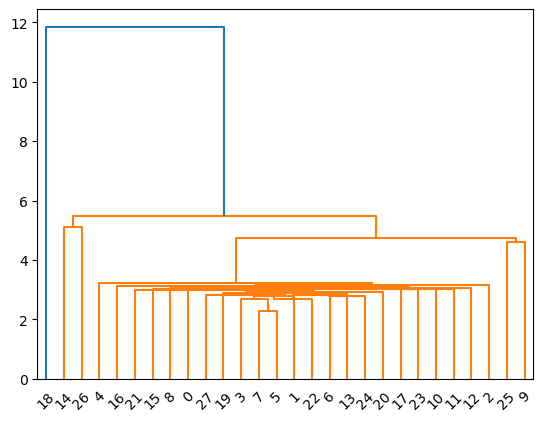

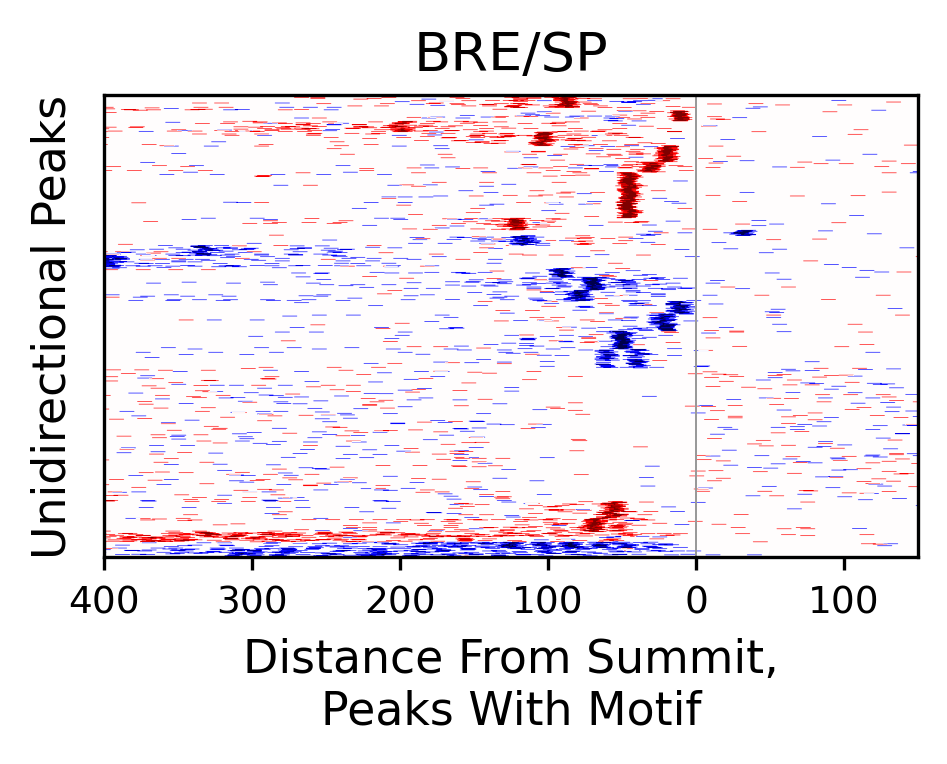

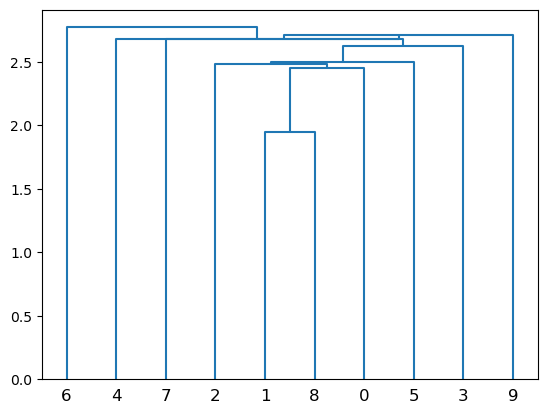

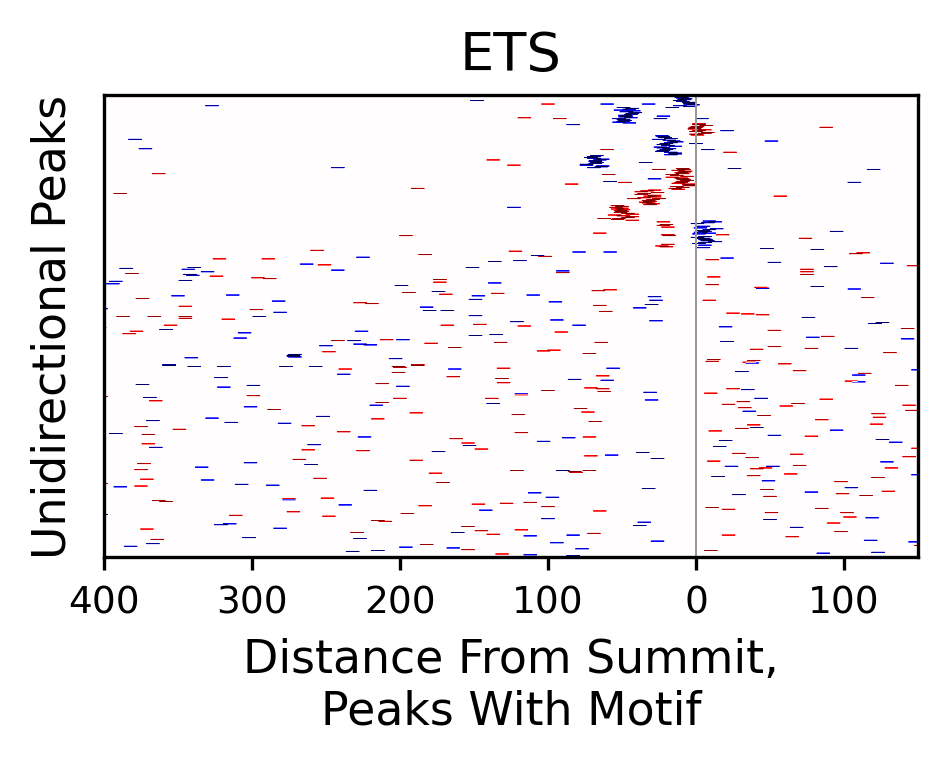

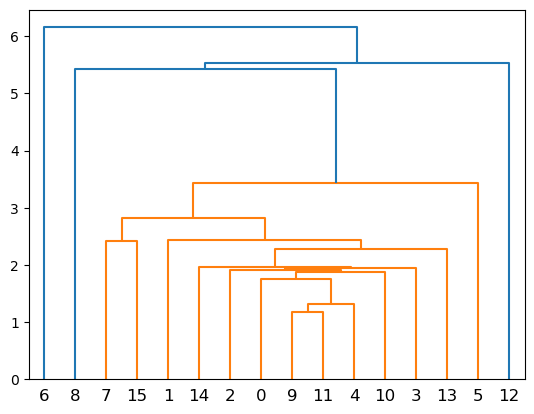

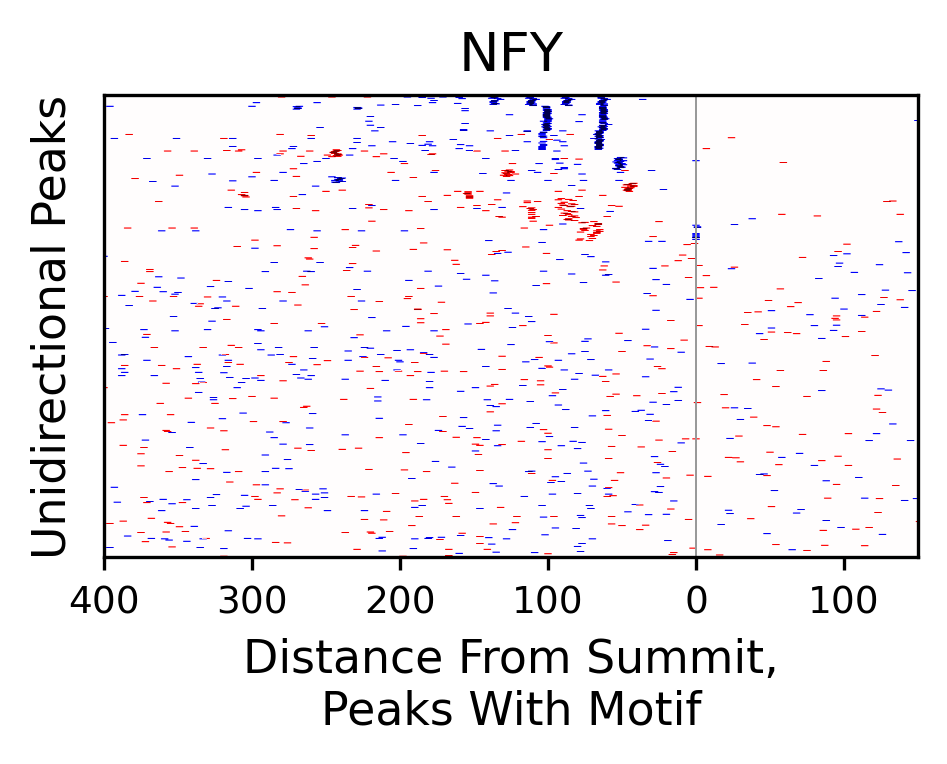

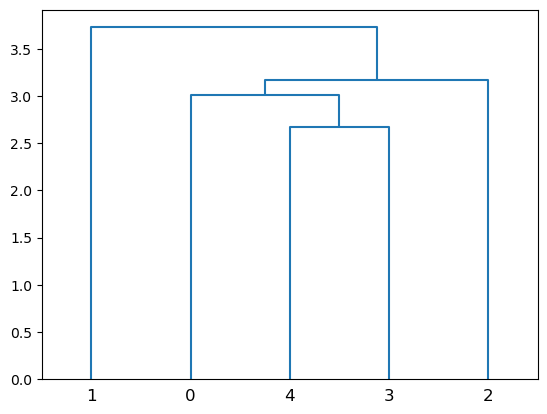

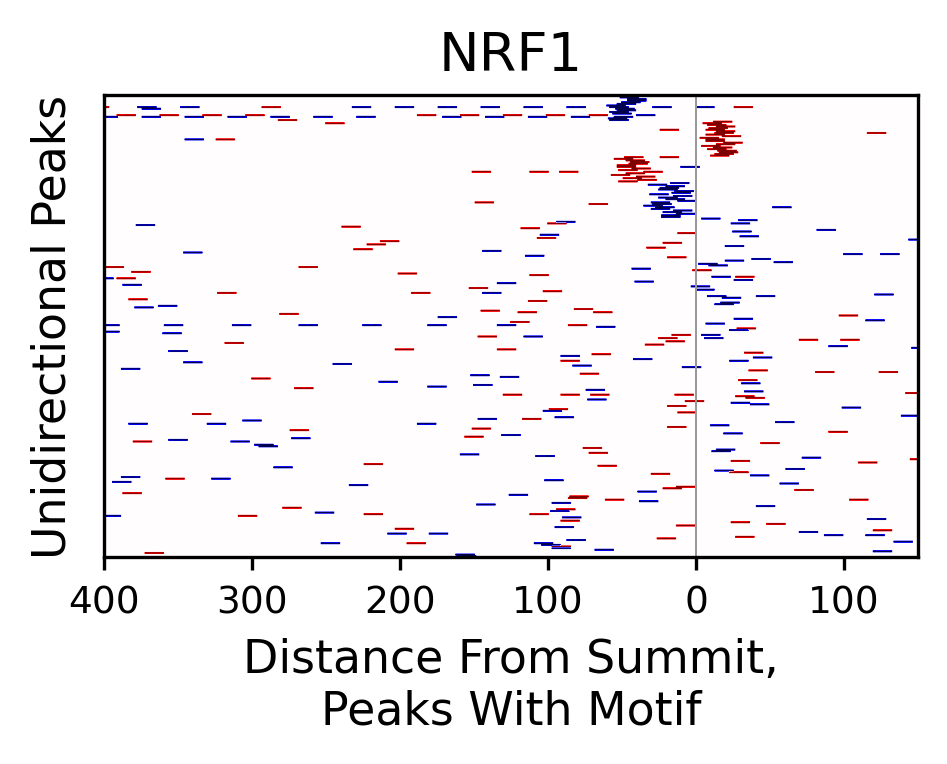

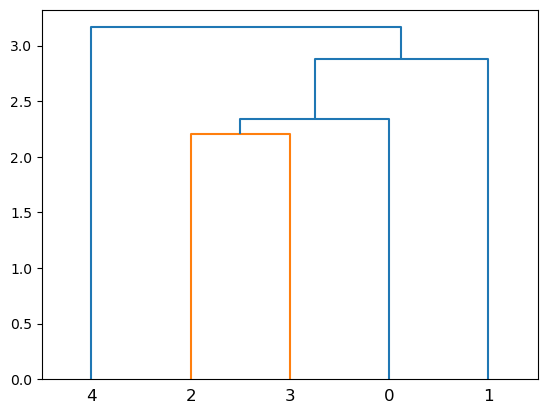

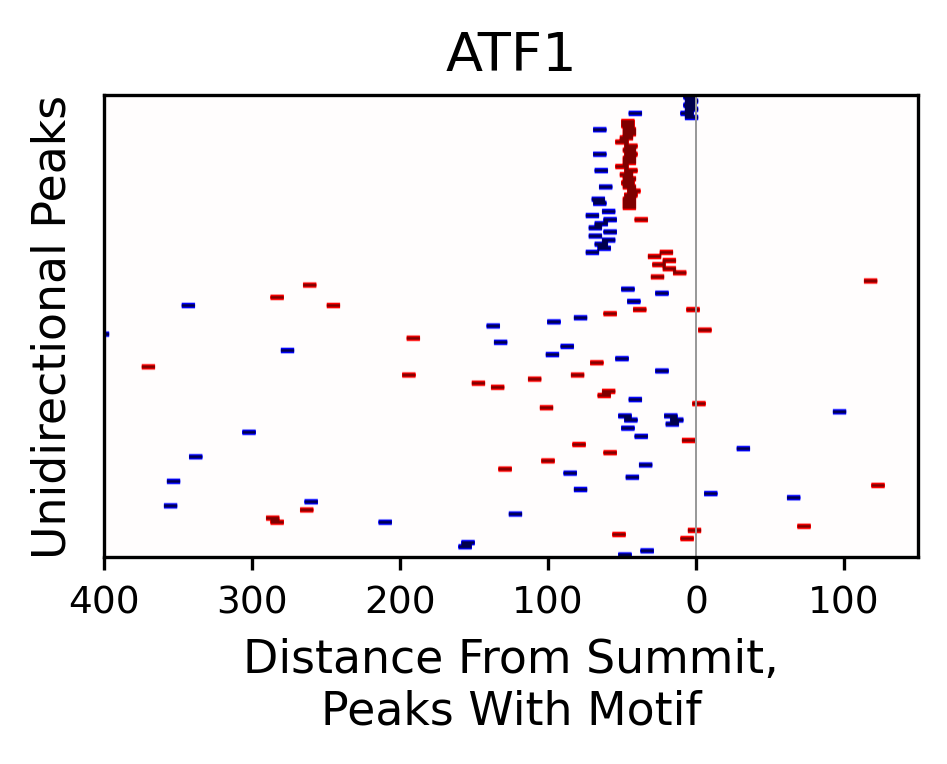

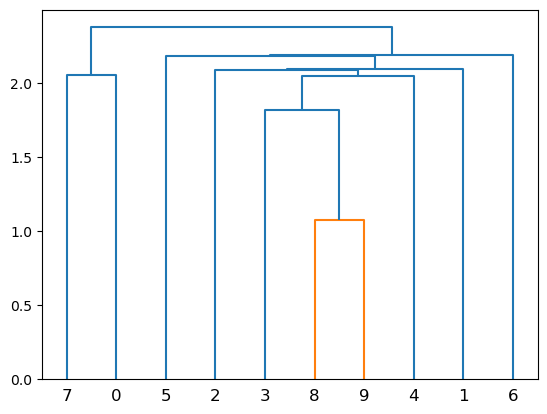

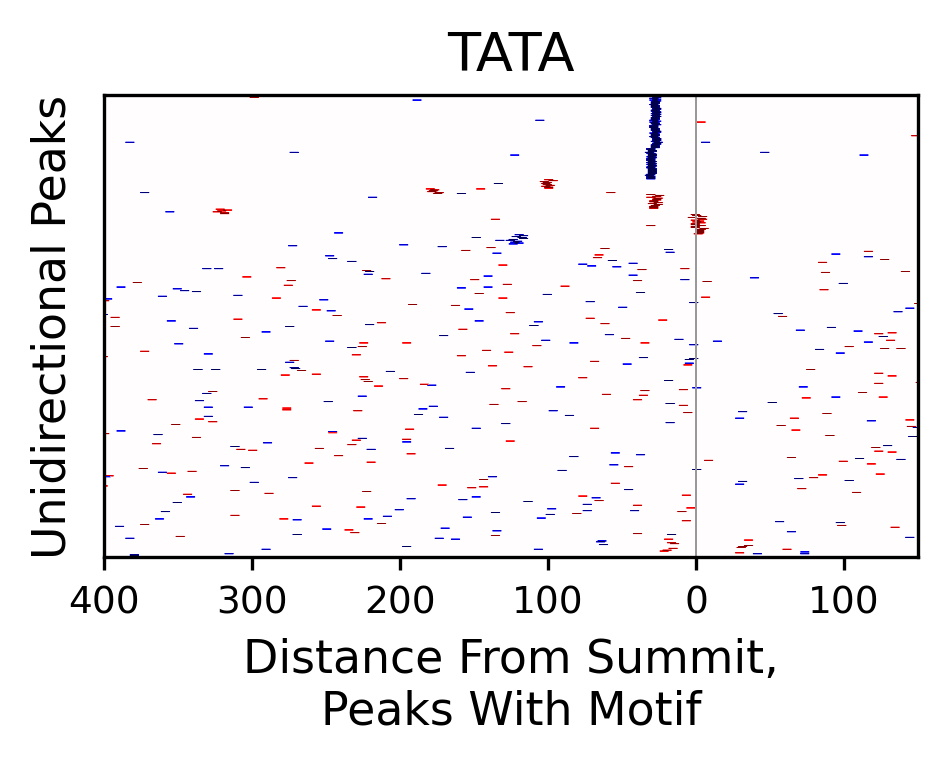

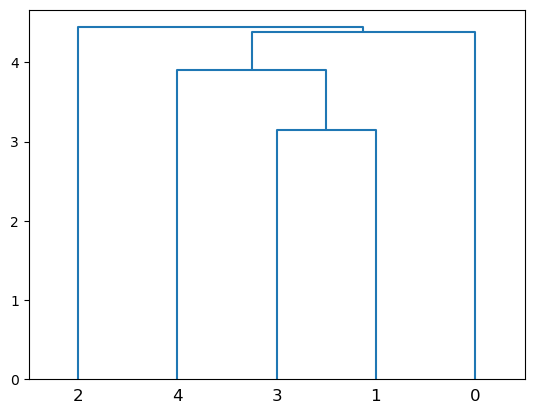

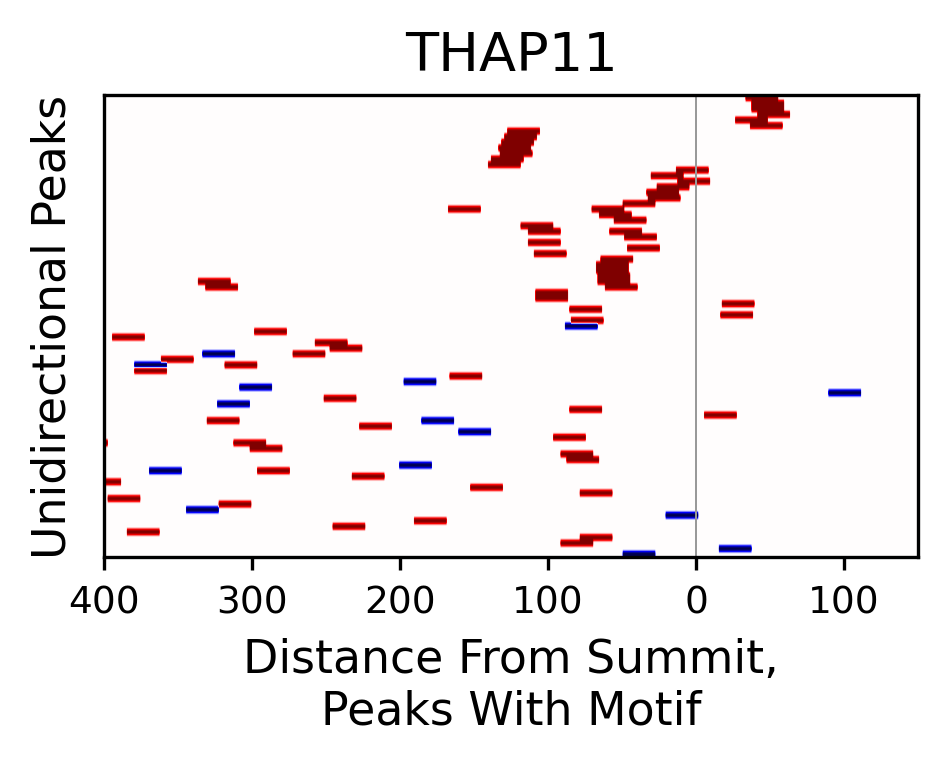

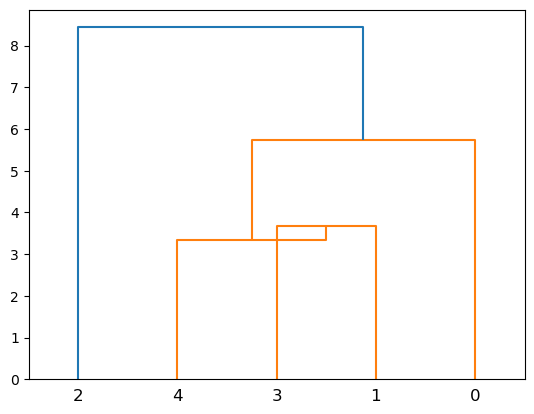

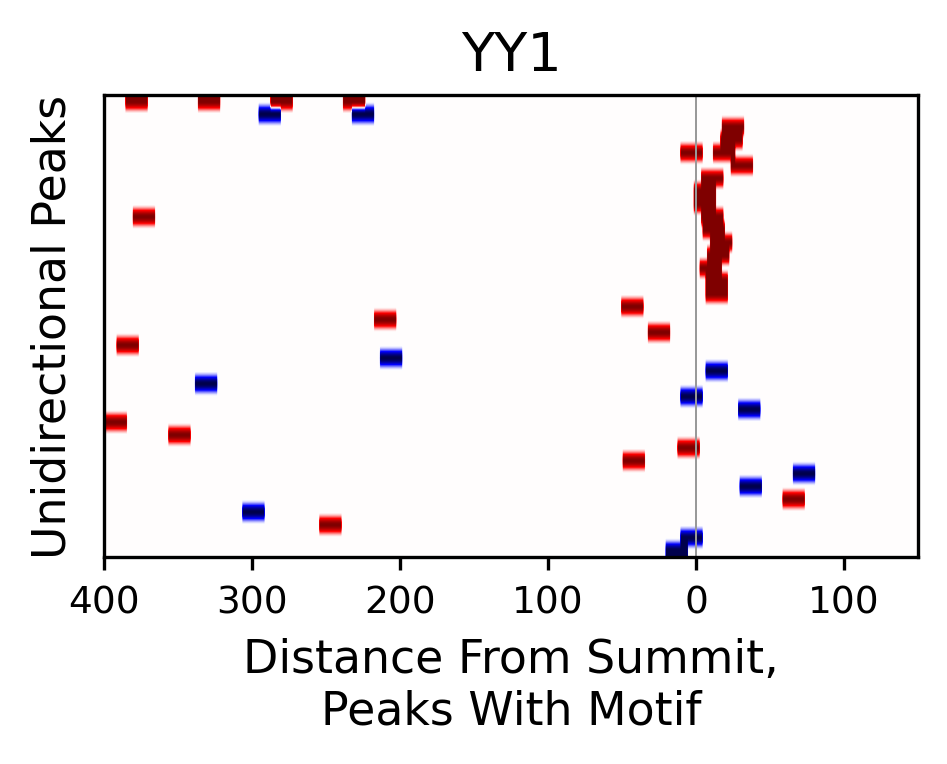

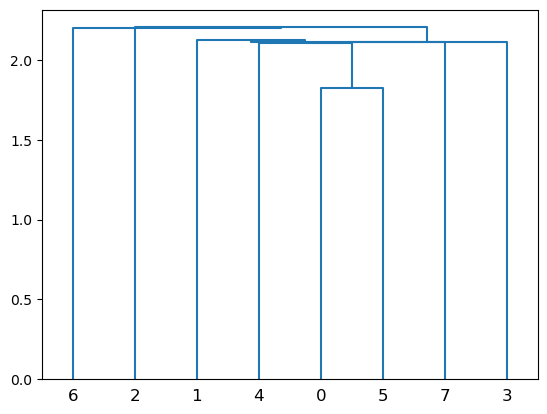

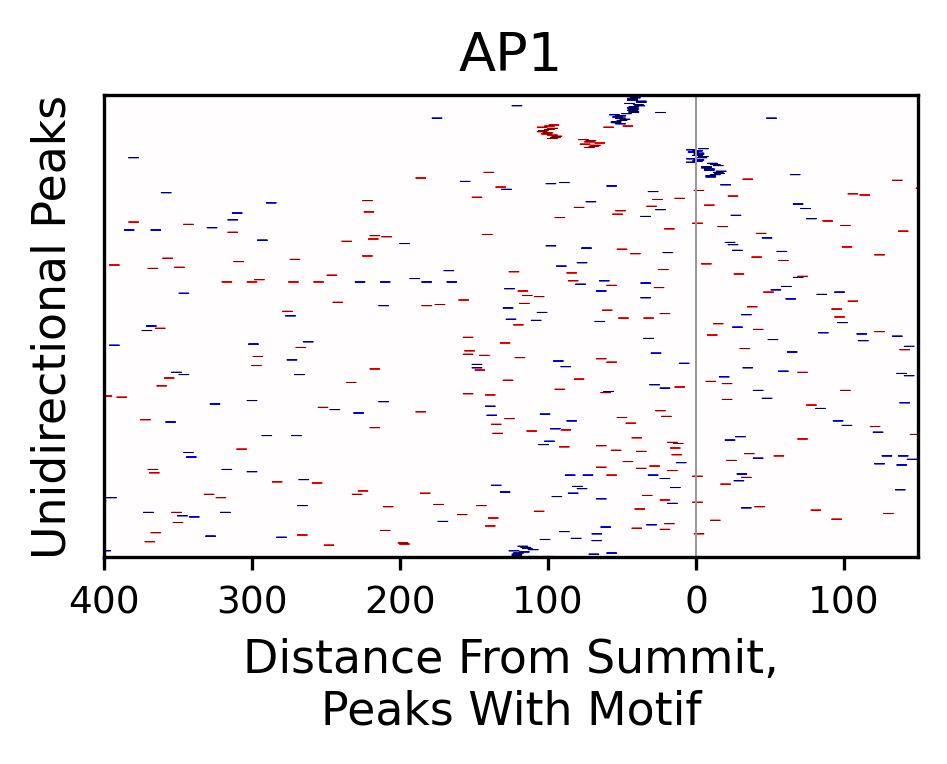

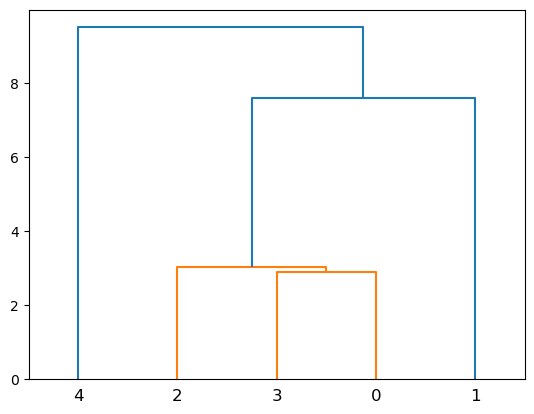

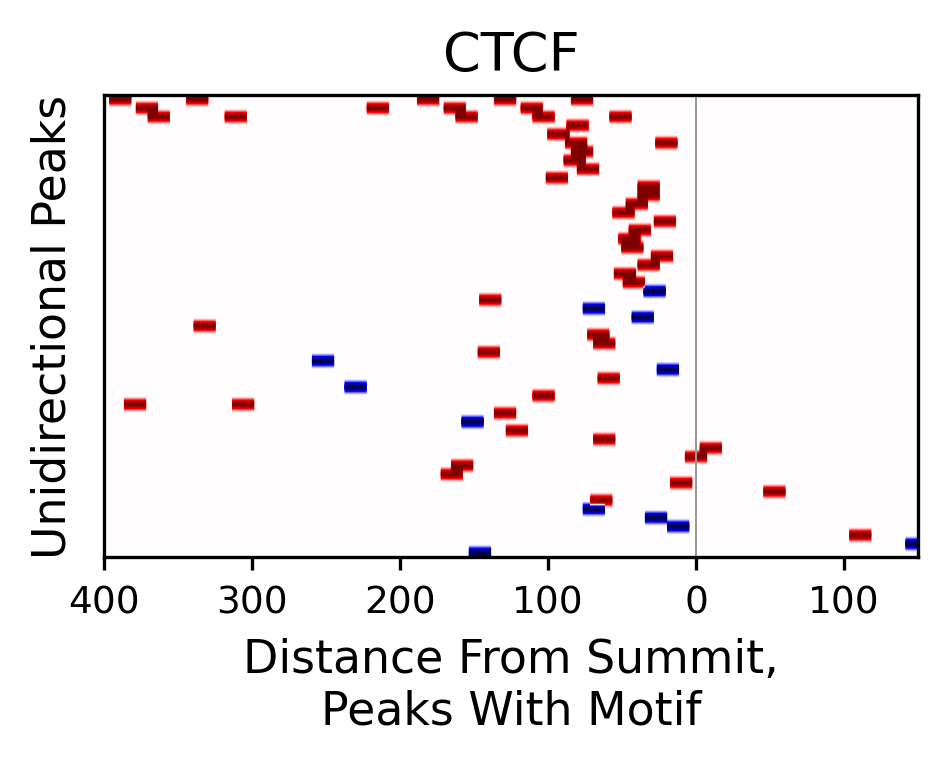

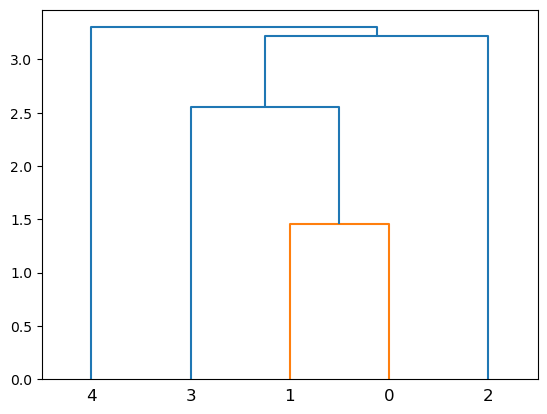

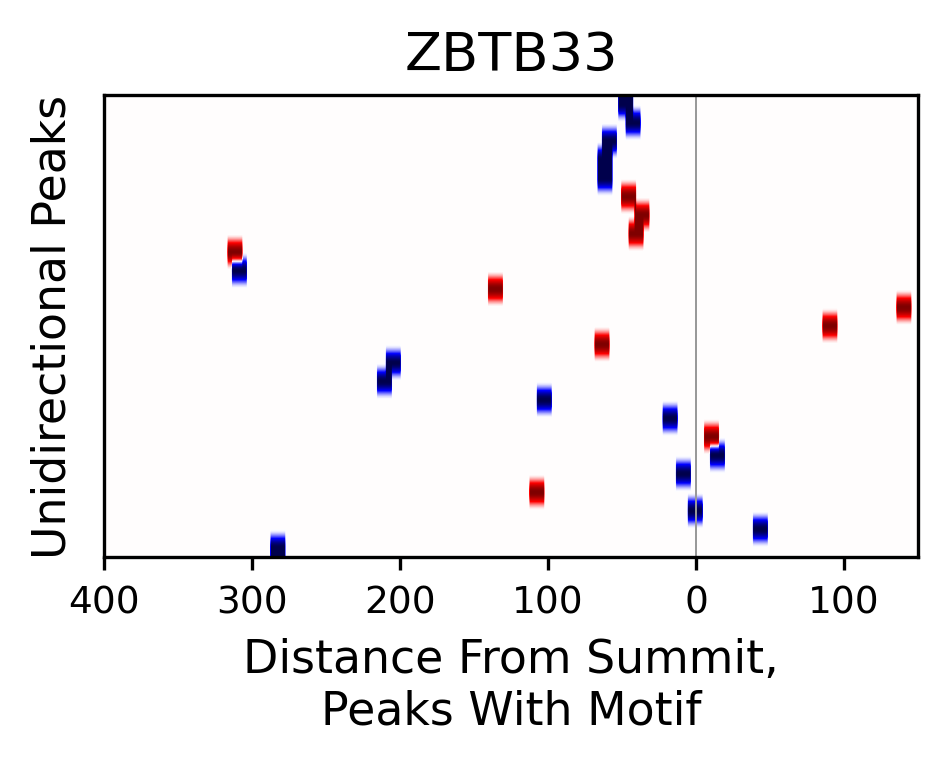

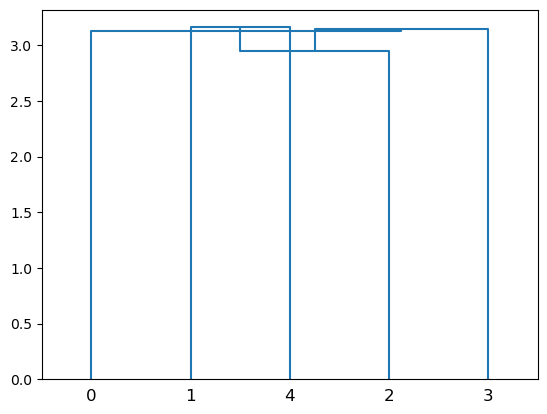

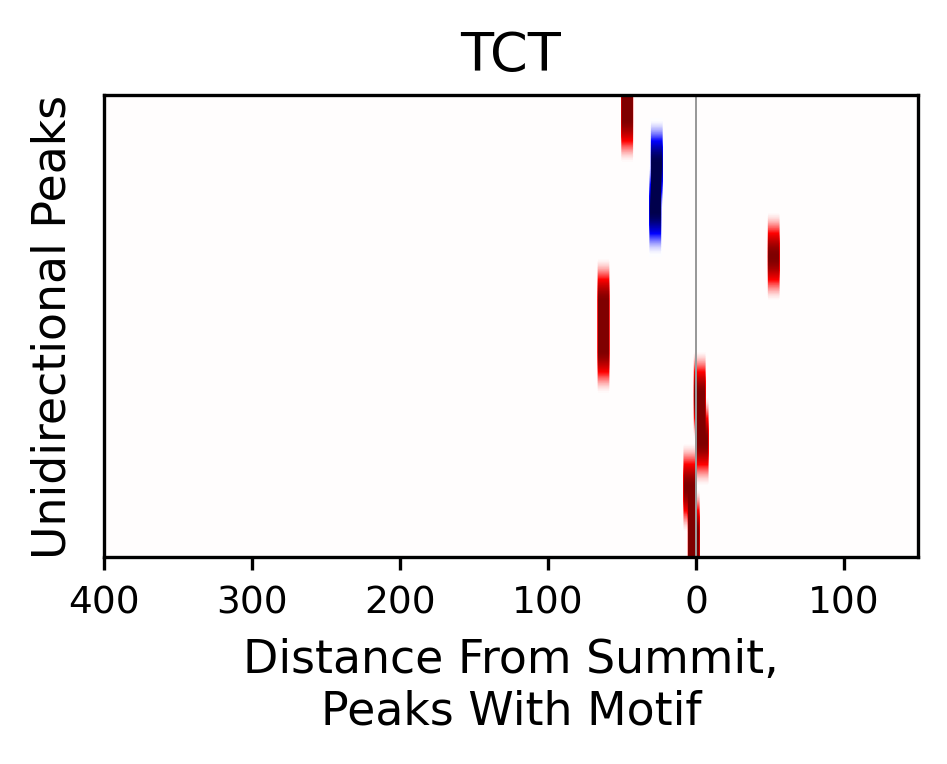

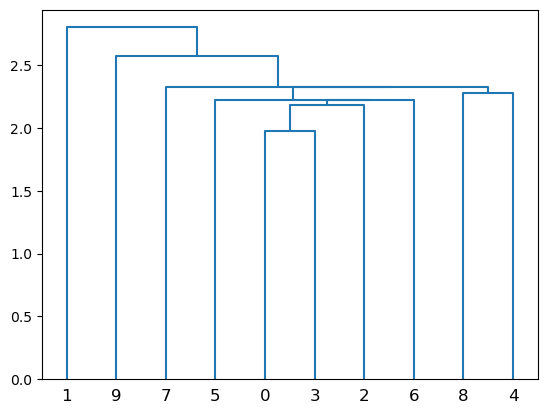

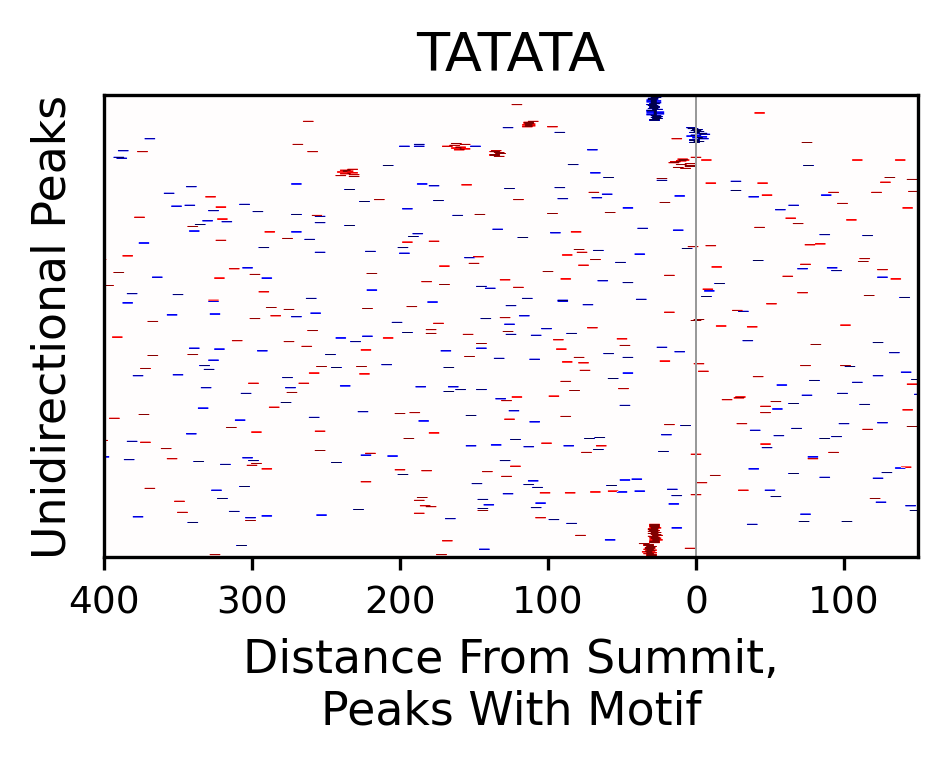

In [68]:
import matplotlib
import sklearn.cluster
import scipy.cluster.hierarchy


def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


def plot_motif_pos_dist(motif_key, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", bi_center = True, draw_summit = False, all_peaks = False,
                        save_dir = None):
    
    assert uni_or_bi in ["uni", "bi"], uni_or_bi
    assert bi_center in [False, True], bi_center
    assert draw_summit in [False, True], draw_summit
    
    
    true_counts = true_profs.sum(axis=(-2,-1))
    
    if uni_or_bi == "bi" and bi_center:
        zoom_start, zoom_end = 250, out_window - 250
    elif uni_or_bi == "bi":
        zoom_start, zoom_end = 100, out_window - 350
    else:
        zoom_start, zoom_end = 100, out_window - 350
        
    
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    peak_widths = []
    summit_bi_pairs = []
    peak_read_counts = []
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["motif_index"] == motif_key]
        
        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            if summit_pos < summit_neg:
                continue  # sometimes the bidirectional peak is backwards from the usual way...
            if bi_center:
                summit = (summit_pos + summit_neg) // 2
            else:
                summit = summit_pos
            
        summit_offset = summit - peak_start - in_window // 2
        
        if hits_of_this_motif.shape[0] > 0:
            motif_hit_positions = np.zeros((out_window,))

            for _, hit in hits_of_this_motif.iterrows():
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                hit_start = hit_start - summit_offset
                hit_end = hit_end - summit_offset
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                 
                if np.all(motif_hit_positions[zoom_start:zoom_end] == 0):
                    continue
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
                peak_read_counts.append(true_counts[peak_index])
            
            else:
                if np.all(motif_hit_positions[zoom_start:zoom_end] == 0):
                    continue
                
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
                
        elif all_peaks:
            # add empty vector
            motif_hit_positions = np.zeros((out_window,))
            
            if peak_is_unidirectional:
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
                peak_read_counts.append(true_counts[peak_index])
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    summit_bi_pairs = np.array(summit_bi_pairs)
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][np.array(peak_widths).argsort()]
    summit_bi_pairs = summit_bi_pairs[np.array(peak_widths).argsort()]
    
    
    hit_positions = motif_hit_positions_across_peaks[uni_or_bi]
    
    if uni_or_bi == "bi":
        plt.figure(figsize=(3.5, 3), dpi=300)

        if draw_summit:
            for i in range(len(hit_positions)):
                for pos in summit_bi_pairs[i]:
                    summit_spot = pos + hit_positions.shape[-1] // 2
                    if hit_positions[i, summit_spot] == 0:
                        hit_positions[i, summit_spot] = np.nan

    else:
        #plt.figure(figsize=(3.5, 2), dpi=300)
        #peak_read_counts = np.array(peak_read_counts)
                
        # code below is from Alex Tseng's modisco report code
        
        # Perform k-means clustering on the predicted profiles, with the strands pooled
        kmeans_clusters = max(5, len(hit_positions) // 50)  # Set number of clusters based on number of profiles, with minimum
        #kmeans_clusters = len(hit_positions)
        
        kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
        cluster_assignments = kmeans.fit_predict(hit_positions)
        
        kmeans_centers = kmeans.cluster_centers_
        Z = scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid")
        plt.figure()
        dn = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.optimal_leaf_ordering(Z, kmeans_centers))
        plt.show()
        #return
        
        # Perform hierarchical clustering on the cluster centers to determine optimal ordering
        kmeans_centers = kmeans.cluster_centers_
        cluster_order = scipy.cluster.hierarchy.leaves_list(
            #scipy.cluster.hierarchy.optimal_leaf_ordering(
                scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid")#, np.abs(kmeans_centers)
            #)
        )
        
        def calc_cluster_sort_order(hit_poses, cluster_is, clust_centers, counts):
            mses = []
            for cluster_i, center_vec in enumerate(clust_centers):
                #hits_in_cluster = hit_poses[cluster_is == cluster_i]
                #mses.append(np.mean(np.square(hits_in_cluster - center_vec[None,...])))
                #mses.append(np.max(np.abs(center_vec)))
                counts_for_cluster = counts[cluster_is == cluster_i]
                mses.append(np.mean(counts_for_cluster))
            cluster_order = np.argsort(mses)[::-1]
            return np.arange(0, len(clust_centers))[cluster_order]
        
        #cluster_order = calc_cluster_sort_order(hit_positions, cluster_assignments, kmeans_centers, peak_read_counts)

        # Order the profiles so that the cluster assignments follow the optimal ordering
        cluster_inds = [np.where(cluster_assignments == cluster_id)[0] for cluster_id in cluster_order]
        cluster_inds = np.concatenate(cluster_inds)
        hit_positions = hit_positions[cluster_inds]
        
        #
        #hit_positions = hit_positions[np.argsort(peak_read_counts)[::-1]]
        plt.figure(figsize=(3.5, 2), dpi=300)
        
        if draw_summit:
            for i in range(len(hit_positions)):
                hit_positions[i, 500] = np.nan
                
                
    cmap = matplotlib.cm.get_cmap("seismic").copy()
    cmap.set_bad(color='#999999')
    plt.imshow(hit_positions, aspect="auto", cmap=cmap)

    plt.title(motif_names[motif_key], fontsize=13)

    xticks = np.arange(0, out_window + 1, 100)
    plt.xticks(xticks, np.abs(xticks - out_window // 2), fontsize=9)

    if uni_or_bi == "bi" and bi_center:
        plt.xlim(250, out_window - 250)
    elif uni_or_bi == "bi":
        plt.xlim(100, out_window - 350)
    else:
        plt.xlim(100, out_window - 350)

    plt.gca().tick_params(length=3)


    if uni_or_bi == "bi":
        plt.ylabel("Bidirectional Peaks", fontsize=11)
        if all_peaks:
            plt.xlabel("Distance From Pos. Summit", fontsize=11)
        else:
            plt.xlabel("Distance From Pos. Summit,\nPeaks With Motif", fontsize=11)
    else:
        plt.ylabel("Unidirectional Peaks", fontsize=11)
        if all_peaks:
            plt.xlabel("Distance From Summit", fontsize=11)
        else:
            plt.xlabel("Distance From Summit,\nPeaks With Motif", fontsize=11)

    plt.yticks([])

    if save_dir is not None:
        fname = "_".join(["2_motif_pos_dist", motif_names[motif_key].replace("/","-"), uni_or_bi])
        plt.savefig(save_dir + fname + ".png",
                    bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()
        
for i in range(len(motif_names)):
    if motif_names[i] in ["CA-Inr", "TA-Inr"]:
        continue
        
    plot_motif_pos_dist(i, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", bi_center = True, draw_summit = True,
                        save_dir = figures_dir)

    #plot_motif_pos_dist(i, motif_hits_peaks, coords, 
    #                    uni_or_bi = "bi", bi_center = False, draw_summit = True,
    #                    save_dir = figures_dir)

# Old?

In [252]:
# old, idk should I delete

def get_motif_centers_from_cwms(modisco_results, patterns_to_keep):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    motif_keys_to_centers = dict()
    for motif_key, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        cwm = pattern["contrib_scores"][:]
        
        motif_center = np.argmax(cwm.sum(axis=-1))
        motif_keys_to_centers[motif_key] = motif_center
        
    return motif_keys_to_centers

motif_keys_to_centers = get_motif_centers_from_cwms(modisco_results, patterns_to_keep)

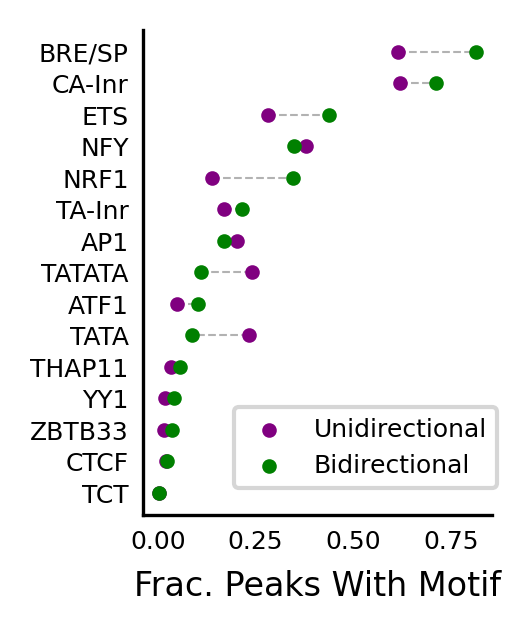

In [69]:
def plot_motif_presence_by_peak_type(motif_hit_counts, coords, motif_names = motif_names):
    
    summits_pos, summits_neg = zip(*[coord[3:5] for coord in coords])
    peak_is_unidirectional = np.array([summits_pos[i] is None or summits_neg[i] is None for i in range(len(coords))])

    motif_hit_bools = motif_hit_counts > 0
    
    uni_motif_hit_bools = motif_hit_bools[peak_is_unidirectional]
    uni_motif_counts = uni_motif_hit_bools.sum(axis=0)
    uni_motif_fracs = uni_motif_counts / np.sum(peak_is_unidirectional)
        
    bi_motif_hit_bools = motif_hit_bools[~ peak_is_unidirectional]
    bi_motif_counts = bi_motif_hit_bools.sum(axis=0)
    bi_motif_fracs = bi_motif_counts / np.sum(~ peak_is_unidirectional)
        
    plot_order = np.argsort(bi_motif_fracs)[::-1]
    #uni_motif_fracs = uni_motif_fracs[plot_order]
    #bi_motif_fracs = bi_motif_fracs[plot_order]
    
    plt.figure(figsize=(1.5,2.1), dpi=300)
    
    
    
    
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([np.median(uni_motif_fracs[plot_i]),
                  np.median(bi_motif_fracs[plot_i])],
                 [len(plot_order) - y - 1] * 2,
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        plt.scatter(np.median(uni_motif_fracs[plot_i]), len(plot_order) - y - 1,
                        label="Unidirectional" if add_to_legend else "",
                        color="purple",
                        #edgecolor=annots_to_edgecolors[key],
                        linewidth=0.5,
                        #s=annots_to_sizes[key],
                        zorder=10, marker=".")
        
        plt.scatter(np.median(bi_motif_fracs[plot_i]), len(plot_order) - y - 1,
                        label="Bidirectional" if add_to_legend else "",
                        color="green",
                        #edgecolor=annots_to_edgecolors[key],
                        linewidth=0.5,
                        #s=annots_to_sizes[key],
                        zorder=10, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1.05, 0.03))
    plt.yticks(range(len(patterns_to_keep))[::-1], np.array(motif_names)[plot_order], fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Frac. Peaks With Motif", fontsize=8)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
        
plot_motif_presence_by_peak_type(motif_hit_counts["profile"], coords)

In [70]:
def plot_oi_by_motif_presence(motif_hit_counts, true_profs, motif_names = motif_names):
    num_motifs = len(motif_names)
    
    motif_hit_bools = motif_hit_counts > 0
    
    ois = get_orientation_indexes(true_profs)
    
    oi_bools = ois > 0.85
    
    ois_with_motifs = []
    for motif_key in range(num_motifs):
        oi_bools_with_motif = oi_bools[motif_hit_bools[:, motif_key]]
        ois_with_motifs.append(np.sum(oi_bools_with_motif) / len(oi_bools_with_motif))
    
    plot_order = np.argsort(ois_with_motifs)
    ois_with_motifs_ordered = [ois_with_motifs[i] for i in plot_order]
    motif_names_ordered = [motif_names[i] for i in plot_order]
    
    plt.figure(figsize=(1.,1.7), dpi=300)
    
    plt.barh(range(num_motifs), ois_with_motifs_ordered, height=0.5, color="#7e7dde")
    
    plt.axvline(np.sum(oi_bools) / len(oi_bools), linestyle="dashed", c="k", linewidth=1, alpha=0.6)

    plt.yticks(range(num_motifs), motif_names_ordered, fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Frac. Peaks With Motif\n Where OI > 0.85", fontsize=7)
    plt.ylim(0 - 0.5, num_motifs - 0.5)
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
plot_oi_by_motif_presence(motif_hit_counts["profile"], true_profs)

NameError: name 'get_orientation_indexes' is not defined

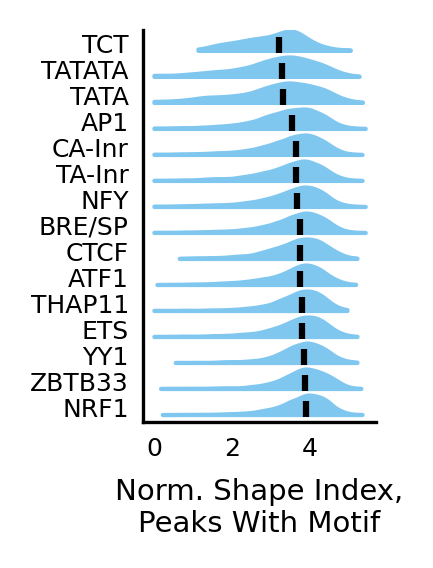

In [48]:
def get_shannon_entropies(profiles):
    assert len(profiles.shape) >= 2, profiles.shape
    profiles_strand_sum = profiles.sum(axis=-2)
    
    profiles_norm = profiles_strand_sum / profiles_strand_sum.sum(axis=-1, keepdims=True)
    profiles_norm_log = np.log(profiles_norm + 1e-20)
    
    entropies = - (profiles_norm * profiles_norm_log).sum(axis=-1)
    return entropies


def plot_shannon_entropy_by_motif_presence(motif_hit_counts, true_profs, motif_names = motif_names):
    num_motifs = len(motif_names)
    
    motif_hit_bools = motif_hit_counts > 0
    
    ses = get_shannon_entropies(true_profs)
    
    norm_ses = ses / np.log(np.log(true_profs.sum(axis=(-1,-2))))
    
    median_norm_ses = np.median(norm_ses, axis=-1)
    
    ses_with_motifs = []
    for motif_key in range(num_motifs):
        ses_with_motif = ses[motif_hit_bools[:, motif_key]]
        ses_with_motifs.append(ses_with_motif)
    
    median_ses_with_motifs = [np.median(ses_with_motif) for ses_with_motif in ses_with_motifs]
    
    plot_order = np.argsort(median_ses_with_motifs)[::-1]
    ses_with_motifs_ordered = [ses_with_motifs[i] for i in plot_order]
    motif_names_ordered = [motif_names[i] for i in plot_order]
    median_ses_with_motifs_ordered = [median_ses_with_motifs[i] for i in plot_order]
    
    plt.figure(figsize=(1.,1.7), dpi=300)
    
    v1 = plt.violinplot(ses_with_motifs_ordered, range(num_motifs),
                        showmeans=False, showextrema=False, showmedians=False,
                        widths=1.5, vert=False)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 1])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], m, np.inf)

        b.set_edgecolor("#80c7f0")
        b.set_facecolor("#80c7f0")
        b.set_alpha(1)

    plt.scatter(median_ses_with_motifs_ordered, np.arange(num_motifs) + 0.2,
                marker="|", c="k", s=15, zorder=1)
    
    #plt.barh(range(num_motifs), ois_with_motifs_ordered, height=0.5, color="#7e7dde")
    
    #plt.axvline(np.sum(oi_bools) / len(oi_bools), linestyle="dashed", c="k", linewidth=1, alpha=0.6)

    plt.yticks(np.arange(num_motifs) + 0.3, motif_names_ordered, fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Norm. Shape Index,\nPeaks With Motif", fontsize=7)
    plt.ylim(0 - 0.3, num_motifs - 0.2)
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
plot_shannon_entropy_by_motif_presence(motif_hit_counts["profile"], true_profs)

## Motif Co-occurrence

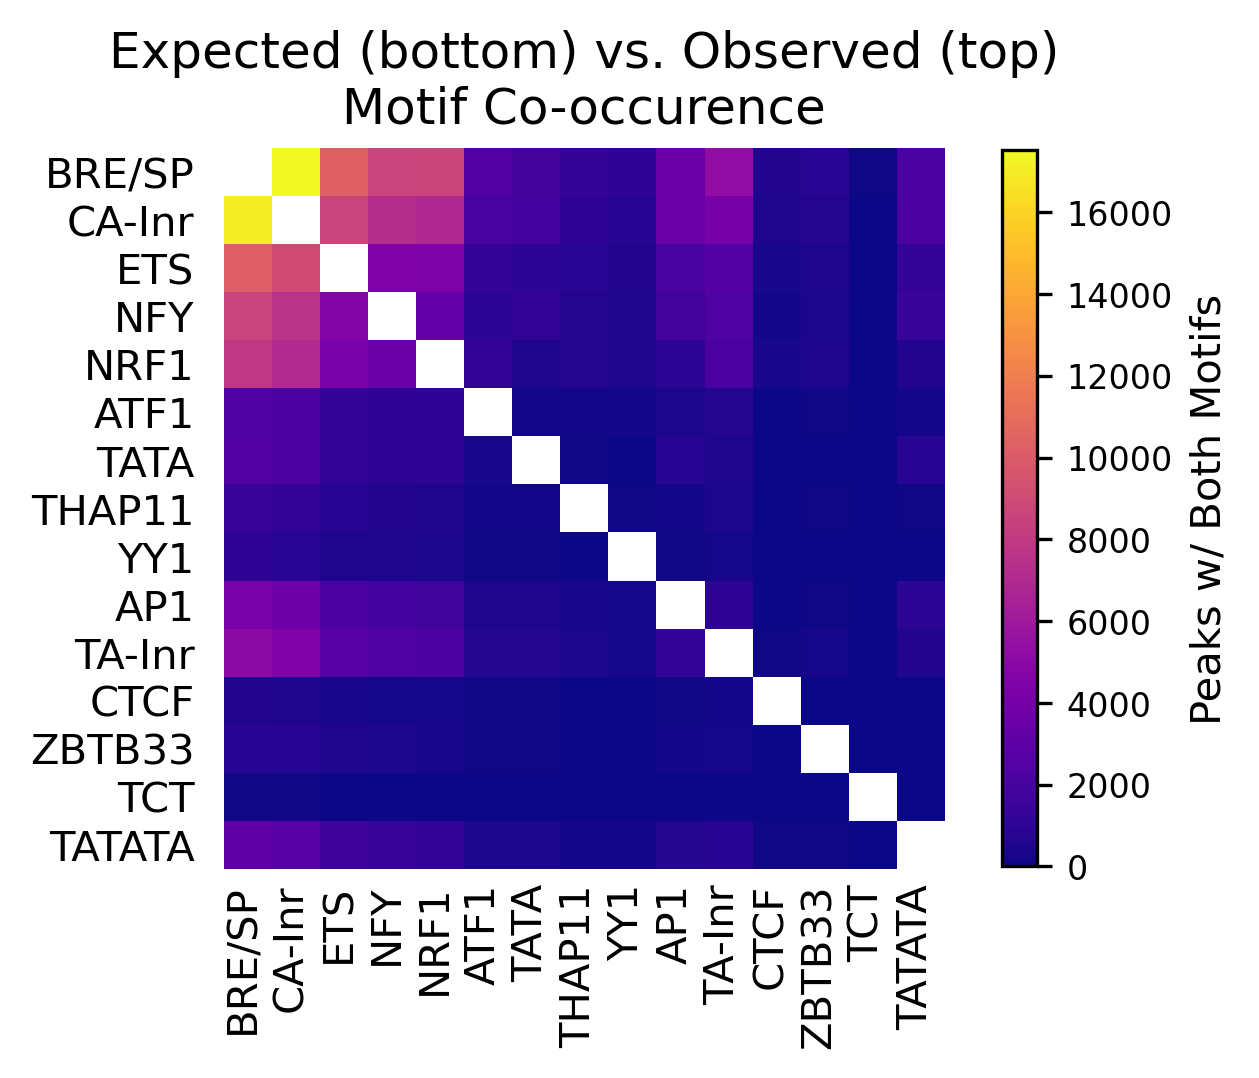

In [71]:
from collections import defaultdict


def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_names = motif_names):
    num_motifs = len(motif_names)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  #/ peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :]) * peak_hit_counts.shape[0] ####

    combo_matrix = combine_two_symmetric_matrices(motif_frac_matrix, motif_cooccur_fracs)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_names[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Peaks w/ Both Motifs",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.title("Expected (bottom) vs. Observed (top)\nMotif Co-occurence")
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])

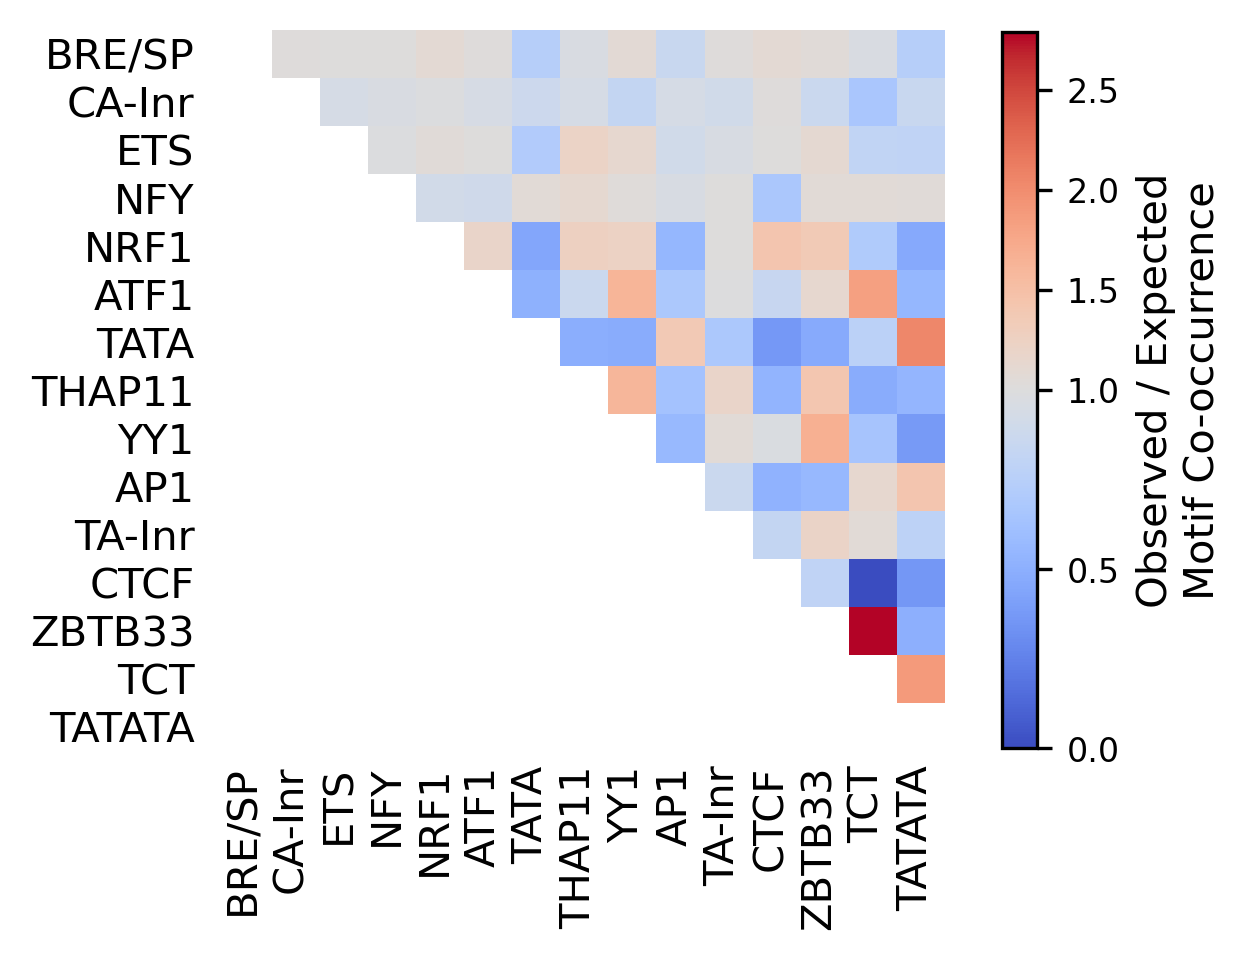

In [72]:
from collections import defaultdict
from matplotlib import colors



def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_names = motif_names):
    num_motifs = len(motif_names)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  / peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :])

    motif_cooccur_enrichment = motif_cooccur_fracs / motif_frac_matrix
    
    combo_matrix = combine_two_symmetric_matrices(np.full_like(motif_frac_matrix, np.nan),
                                                  motif_cooccur_enrichment)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_names[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=np.min(combo_matrix[~np.isnan(combo_matrix)]),
                                                                       vcenter=1.,
                                        vmax=np.max(combo_matrix[~np.isnan(combo_matrix)])))
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Observed / Expected\nMotif Co-occurrence",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])

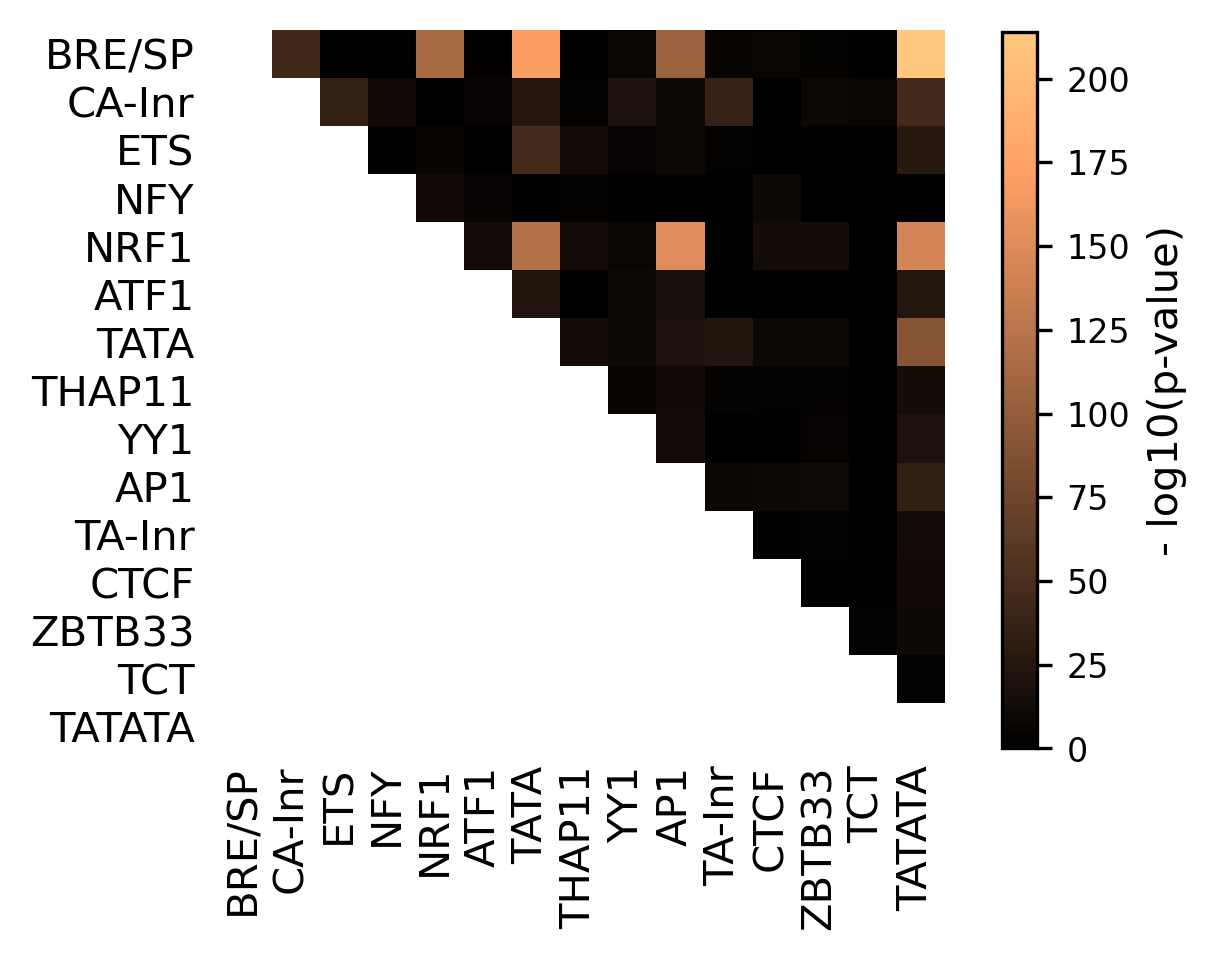

In [73]:
import scipy

def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="two-sided"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

def plot_pvals(peak_hit_counts, motif_names = motif_names):
    neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))
    
    #neg_log_pvals[neg_log_pvals < 5] = np.nan
    
    matrix_to_plot = combine_two_symmetric_matrices(np.full_like(neg_log_pvals, np.nan),
                                                    neg_log_pvals)
    
    num_motifs = len(motif_names)
    ticklabels = range(num_motifs)
    ticklabels = [motif_names[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(matrix_to_plot, cmap="copper")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="- log10(p-value)",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    

plot_pvals(motif_hit_counts["profile"])

## Supplemental

In [76]:
from data_loading import one_hot_encode
import matplotlib.colors as colors
import matplotlib.cm as cmx

from modiscolite_utils import load_sequences

# only used in supplement fig rn
onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)


def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum()


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
            #print(peak_start, peak_end, start, end, real_start)
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


# this is also in 5_modisco/report_utils.py
def compute_per_position_ic(ppm, background=np.array([0.25] * 4), pseudocount=0.001):
    alphabet_len = len(background)
    #ppm = np.abs(ppm)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)

# frankensteined together from how the hit caller code trims
def trim_by_ic(ppm, seq, target_len=25):
    per_pos_ic = compute_per_position_ic(seq)
    
    best_i = -1
    best_sum = 0
    for i in range(ppm.shape[0] - target_len + 1):
        new_sum = np.sum(per_pos_ic[i : i + target_len])
        if new_sum > best_sum:
            best_sum = new_sum
            best_i = i

    return ppm[best_i:best_i + target_len]


def plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                      patterns_to_keep, motif_hits,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    true_profs_list = []
    pred_profs_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        cwm_trimmed = trim_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=prof_width)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)
        
        
    xrange = range(-prof_width, prof_width)
    num_quantiles = 4
    alpha_range = lambda plot_i : 0.1 + plot_i * (0.9 / num_quantiles)
    
    cNorm  = colors.Normalize(vmin=0, vmax=num_quantiles+1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('winter'))
    
    fig, axes = plt.subplots(len(patterns_to_keep), figsize=(1.75,0.9 * len(patterns_to_keep)),
                             dpi=300)
    plt.subplots_adjust(hspace=0.1)
    
    middle_ax_i = len(patterns_to_keep) // 2
    
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        
        pred_profs = pred_profs_list[ax_row_i]
        seq_scores = cwm_score_list[ax_row_i]
        
        quantiles = np.arange(0,1.1,1/num_quantiles)
        q_scores = np.quantile(seq_scores, quantiles)
        quantile_tups = [(q_scores[i], q_scores[i+1]) for i in range(len(q_scores)-1)]

        
        for cat_i, (low_q, high_q) in enumerate(quantile_tups):
            in_quantile_bools = np.array([score >= low_q and score < high_q for score in seq_scores])
            avg_profs_subset = pred_profs[in_quantile_bools].mean(axis=0)
            
            axes[ax_row_i].plot(xrange, avg_profs_subset[0],
                     alpha = 0.9, linewidth=0.75,
                     c=scalarMap.to_rgba(num_quantiles - cat_i),
                     label = "Q %0.2f-%0.2f" % (quantiles[cat_i], quantiles[cat_i + 1]))
            axes[ax_row_i].plot(xrange, -1 * avg_profs_subset[1],
                     alpha = 0.9, linewidth=0.75,
                     c=scalarMap.to_rgba(num_quantiles - cat_i))
        
        axes[ax_row_i].set_ylabel(motif_names[ax_row_i], fontsize=10)
        
        if ax_row_i == middle_ax_i:
            ax2 = axes[ax_row_i].twinx()
            ax2.spines["left"].set_position(("axes", -0.6))
            
            ax2.yaxis.set_label_position('left')
            ax2.yaxis.set_ticks_position('none')
            ax2.set_yticks([])
            ax2.set_xticks([])
            for side in ["bottom", "top", "right"]:
                ax2.spines[side].set_visible(False)
                
            ax2.set_ylabel("Avg. Predicted Profile", fontsize=12)

        axes[ax_row_i].set_xlim(-prof_width - 10, prof_width + 10)
        
        if ax_row_i == len(patterns_to_keep) - 1:
            axes[ax_row_i].set_xlabel("Distance From Motif", fontsize=10)
            axes[ax_row_i].spines["bottom"].set_linewidth(1.2)
            axes[ax_row_i].spines["bottom"].set_color("#333333")
            axes[ax_row_i].tick_params("x", length=0, labelsize=6)
        else:
            axes[ax_row_i].spines["bottom"].set_visible(False)
            axes[ax_row_i].set_xticks([])
        
        axes[ax_row_i].spines["left"].set_linewidth(1.2)
        axes[ax_row_i].spines["left"].set_color("#333333")
        axes[ax_row_i].spines["top"].set_visible(False)
        axes[ax_row_i].spines["right"].set_visible(False)
        axes[ax_row_i].tick_params("y", length=3, labelsize=6)
        
    fig.align_ylabels()
    
    handles,labels = axes[-1].get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    axes[ax_row_i].legend(handles, labels,
               bbox_to_anchor=(0.5, -0.7), loc='upper center',
               frameon=False, fontsize=8)
    
    plt.show()

        
plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                  patterns_to_keep, motif_hits,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length: 2114
Num. Examples: 30534


KeyError: 'key'